# Figure 4: MHC class I vs CH risk

## Import packages

In [1]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [3]:

timestr = time.strftime("%Y%m%d") # get current date 

## Import batch data

In [4]:

folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [5]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
# okay so we have 2823 of these but then note that only 2249 are with CH variants 
# so like 20% of >= 2 reads are not v likely to be real? should conslut with Jamie 

batch_all_ns.head(n = 10)

Number of samples carrying more than a single read with the variant sequence: 2823


sample_ID chromosome  end_position       VAF  var_depth  depth  \
41     2100538      chr17       7674894  0.036364          2     55   
56     2100679       chr2      25234373  0.048780          4     82   
59     2100706       chr2      25234307  0.019417          2    103   
64     2100777       chr2      25240313  0.020833          2     96   
65     2100788       chr2      25240420  0.131148          8     61   
83     2101006       chr2      25240420  0.027778          2     72   
109    2101361      chr17      76736877  0.025641          2     78   
126    2101637       chr2      25240313  0.021739          2     92   
130    2101708      chr17       7675088  0.033898          2     59   
154    2102011      chr15      90088702  0.097561          4     41   

    Amino_acids  SYMBOL   Codons                    batch alt_variant  \
41          R/*    TP53  Cga/Tga  batch_21_annotated_data           *   
56          R/H  DNMT3A  cGc/cAc  batch_21_annotated_data           H   
59          P/L  DNMT3A  cCg/cTg  batch_21_annotated_data           L   
64          R/*  DNMT3A  Cga/Tga  batch_21_annotated_data           *   
65          Y/C  DNMT3A  tAc/tGc  batch_21_annotated_data           C   
83          Y/S  DNMT3A  tAc/tCc  batch_21_annotated_data           S   
109         P/H   SRSF2  cCc/cAc  batch_21_annotated_data           H   
126         R/*  DNMT3A  Cga/Tga  batch_21_annotated_data           *   
130         R/H    TP53  cGc/cAc  batch_21_annotated_data           H   
154         R/Q    IDH2  cGg/cAg  batch_21_annotated_data           Q   

    ref_variant  
41            R  
56            R  
59            P  
64            R  
65            Y  
83            Y  
109           P  
126           R  
130           R  
154           R

In [6]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


## Annotate samples with genetic variants carried

In [7]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 

# we have more variants than sites because for each site, we look at any change from the reference sequence (any possible variant)
# at the same time, because we have this data, we can check if we have more variants that "random" mutations

# save coordinates to a df
pd.DataFrame(num_variants.variant_coord_pos.unique().tolist()).to_csv('/Users/barbarawalkowiak/Desktop/variants_annotated.csv')

Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [8]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [9]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.sample_ID.unique()))


Number of variants identified with annotations: 32
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214


## Add age data

In [10]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'sample_ID'
age_df.columns.values[1] = 'age'
print('Number of individuals for whom age data is available:', age_df.shape[0])

Number of individuals for whom age data is available: 459385


In [11]:

# add age data to the rest of the data 

batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'sample_ID') # add age to everyone who has a variant
print("Number of sample with available CH variant:", batch_gene_vars.shape[0])
print("Number of sample with available CH variant and age:", batch_gene_age.shape[0])
# note: this is throwing away patients who have been diagnosed with cancer (this dataset is for healthy individuals only)

Number of sample with available CH variant: 2249
Number of sample with available CH variant and age: 1986


## Load MHC binding affinity prediction

In [12]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [13]:

# Import PRIME and NetMHC data 

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_file_net2 = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240221_percent_ranks_for_each_variant_by_HLA.csv' # EL rank, sum of weakly binding peptides, sum of strongly binding peptides
pred_file_prime = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/PRIME_out/scores/20240220_percent_ranks_for_each_variant_by_HLA.csv' # prediction file for PRIME

pred_filename_net = pred_file_net.split('/')[2].split('.')[0]
pred_filename_net2 = pred_file_net2.split('/')[2].split('.')[0]
pred_method_net = pred_file_net.split('_out')[0]
pred_filename_prime = pred_file_prime.split('/')[2].split('.')[0]
pred_method_prime = pred_file_prime.split('_out')[0]

# Organize NetMHC scores 
netmhc = pd.read_csv(pred_file_net)
netmhc2 = pd.read_csv(pred_file_net2)

# in the original file, I am using "STOP" to indicate stop codons
# I need to change it to "*" to ensure consistent names for variants 
netmhc2['variant'] = netmhc2['variant'].str.replace('STOP', '*')

# rename collumns in NetMHC
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'allele': 'HLA'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'min_rank': '%Rank_EL_2'}) # rename affinity column 

# uniform HLA allele naming format
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)
NET_col2 = netmhc2.HLA
NET_formatted2 = NET_col2.apply(transform_format_netmhc_2)
netmhc2 = pd.concat([netmhc2, NET_formatted2.rename('HLA_formatted')], axis = 1)

# select required columns
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc2 = netmhc2[['HLA_formatted', '%Rank_EL_2', 'sum_peptides_below_05', 'sum_peptides_below_2', 'gene', 'variant', 'genotype']]

# sort both dataframes so that is easier to compare values
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])
netmhc2 = netmhc2.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# merge two dataframes for netmhc
netmhc_all = pd.merge(netmhc, netmhc2, on = ['HLA_formatted', 'gene', 'variant', 'genotype'])

netmhc_all['gene_var_gt'] = netmhc_all['gene'] + '_' + netmhc_all['variant'] + '_' + netmhc_all['genotype'] # add complete genotype data
netmhc_all['gene_var'] = netmhc_all['gene'] + '_' + netmhc_all['variant']
netmhc_all = netmhc_all.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc_all[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest

# Organize PRIME scores 
prime = pd.read_csv(pred_file_prime)
# variants with stop codons are indicated with AposSTOP 
# this is because I couldn't write anything with * (did not accept * in path)
prime['variant'] = prime['variant'].str.replace('STOP', '*')
prime['gene_var_gt'] = prime['gene'] + '_' + prime['variant'] + '_' + prime['genotype'] # add complete genotype data
prime['gene_var'] = prime['gene'] + '_' + prime['variant']
prime = prime.rename(columns={'allele': 'HLA'}) # rename affinity column 
prime = prime.rename(columns={'min_rank': '%Rank_EL'}) # rename affinity column 

# remove columns with duplicated variants (for stop codons)
stop_to_remove = ['TP53_R213S', 'TP53_R196S', 'DNMT3A_R598S', 'DNMT3A_R771S', 'DNMT3A_R320S']
prime = prime[~prime['gene_var'].isin(stop_to_remove)]

# uniform HLA allele naming format
PRIME_col = prime.HLA
PRIME_formatted = PRIME_col.apply(transform_format_prime)
prime = pd.concat([prime, PRIME_formatted.rename('HLA_formatted')], axis = 1)

scores_prime = prime[['HLA_formatted', '%Rank_EL', 'gene', 'variant', 'genotype', 'gene_var_gt']] # select columns of interest

# Print the results 
print('Number of alleles for which predictions are available (NetMHC):', len(netmhc_all.HLA_formatted.unique()))
print('Number of unique variants (NetMHC):',  len(netmhc_all.gene_var.unique()))
print('Number of alleles for which predictions are available (PRIME):', len(prime.HLA_formatted.unique()))
print('Number of unique variants (PRIME):',  len(prime.gene_var.unique()))


Number of alleles for which predictions are available (NetMHC): 194
Number of unique variants (NetMHC): 42
Number of alleles for which predictions are available (PRIME): 194
Number of unique variants (PRIME): 42


## Load MHC class I genotyping data

In [14]:

# add MHC genotype data to CH cases

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

# clean up the dataset (filtering according to Krishna et al., 2024 Science)
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype

print("Number of samples with imputed HLA:", df_hla1.shape[0])
print("Number of samples with confidently imputed HLA:", df_clean_hla1.shape[0])

Number of samples with imputed HLA: 488377
Number of samples with confidently imputed HLA: 443620


In [15]:

# now you need to merge the data that you want to use with the allele data to get predictions
# most comprehensive dataset we have is batch_gene_age (includes genetic variant someone carries and age)
# Find IDs of CH-affected persons and match to their HLA genotype 

batch_gene_vars.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
batch_gene_age.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
ids_batch = batch_gene_age['Person_ID']
hla_batch_ids = df_clean_hla1[df_clean_hla1['Person_ID'].isin(ids_batch)] 

# add HLA genotype data to samples with annotated CH variant and age
batch_gene_age_hla = pd.merge(batch_gene_age, df_clean_hla1, on='Person_ID')
batch_gene_vars_hla = pd.merge(batch_gene_vars, df_clean_hla1, on='Person_ID')
print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print("Number of samples with available CH variant and HLA genotype:", batch_gene_vars_hla.shape[0])
print("Number of samples with available CH variant and age:", batch_gene_age.shape[0])
print('Number of samples with annotated variants CH variant and age and HLA genotype:', batch_gene_age_hla.shape[0]) # 1 HLA genotype missing 

# first, filter the df such that we only have MHC alleles for which predictions are available 
hla_ukbb = df_clean_hla1.filter(regex='\d').columns # HLA from all UKBB
print('Number of HLA alleles which have been identified in the UK BioBank:', len(hla_ukbb))


Number of samples with available CH variant: 2249
Number of samples with available CH variant and HLA genotype: 2043
Number of samples with available CH variant and age: 1986
Number of samples with annotated variants CH variant and age and HLA genotype: 1798
Number of HLA alleles which have been identified in the UK BioBank: 214


In [16]:

# define the function to find best score for variant carried by someone
def find_best_score_for_variant_carried(row, df, param):
    
    row_values = pd.to_numeric(row[1:-2], errors='coerce')
    
    # find alleles which are present 
    hla = row.index[1:-2][row_values >= 1] 
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    # print(vals)
    # print(type(vals))
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value   


In [17]:

# get predictions

# define a function to obtain dataframes with predictions for different scores 
def pred_to_scores(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    
    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # subset predictions to only include scores for available 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]

    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # subset batch_gene_age_hla file 
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    ch_hla_sub['score'] = ch_hla_sub.apply(find_best_score_for_variant_carried, df=pred_sub, param=param, axis=1) # add score for the parameter
    ch_hla_scores = ch_hla_sub.dropna() # remove NA (incorrectly annotated cases)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_hla_scores, age_vaf, on = ['Person_ID', 'gene_var'])

    # now add the columns with VAF and age 
    col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
    ch_hla_merge_sub = ch_hla_merge[col_to_select]

    return ch_hla_merge_sub


In [18]:

# run the function 
params = ["Aff_nM", 'Score_BA', 'Score_EL', '%Rank_BA', '%Rank_EL'] # allowed parameters (scores we are interested in)

scores_dict = {}

for param in params:
    key = f'ch_best_scores_net_{param}'
    df = pred_to_scores(netmhc_all, param)
    scores_dict[key] = df

# get individual dataframes
ch_best_aff = scores_dict['ch_best_scores_net_Aff_nM']
ch_best_ba_score = scores_dict['ch_best_scores_net_Score_BA']
ch_best_el_score = scores_dict['ch_best_scores_net_Score_EL']
ch_best_ba_rank = scores_dict['ch_best_scores_net_%Rank_BA']
ch_best_el_rank = scores_dict['ch_best_scores_net_%Rank_EL']

# add a column to indicate the name of the scoring system that you used
ch_best_aff['score_type'] = 'Aff_nM'
ch_best_ba_score['score_type'] = 'Score_BA'
ch_best_el_score['score_type'] = 'Score_EL'
ch_best_ba_rank['score_type'] = '%Rank_BA'
ch_best_el_rank['score_type'] = '%Rank_EL_NetMHC' # add so you can distinguish between NetMHC and PRIME as %Rank_EL is available for both

# for affinity and ranking, convert to negative log (higher -1log(rank) = tighter binding / more immunogenic)
ch_best_aff['log_score'] = -1*np.log10(ch_best_aff['score']) # convert score to -log10(score)
ch_best_ba_rank['log_score'] = -1*np.log10(ch_best_ba_rank['score']) # convert score to -log10(score)
ch_best_el_rank['log_score'] = -1*np.log10(ch_best_el_rank['score']) # convert score to -log10(score)

# we have done this for scores from NetMHC, but we can also add %Rank_EL from PRIME
prime_ch_best_el_rank = pred_to_scores(prime, '%Rank_EL')
prime_ch_best_el_rank['log_score'] = -1*np.log10(prime_ch_best_el_rank['score'])
prime_ch_best_el_rank['score_type'] = '%Rank_EL_PRIME'


In [19]:

# SANITY CHECK

# create correct order of gene variants (by median score)
# NOTE that boxplots tell you the median and IQR not mean!
ch_best_el_rank['median_log_score'] = ch_best_el_rank.groupby('gene_var')['log_score'].transform('median')
ch_best_el_rank_sort = ch_best_el_rank.sort_values(by='median_log_score', ascending = False)

order_by_mean_log = ch_best_el_rank_sort[['gene_var', 'median_log_score']].drop_duplicates().sort_values(by = 'median_log_score', ascending = False).gene_var
print('Variants with highest -log(rank) scores (most immunogenic):', order_by_mean_log[0:5])
print('Variants with lowest -log(rank) scores (least immunogenic):', order_by_mean_log[-6:])

Variants with highest -log(rank) scores (most immunogenic): 1596       MPL_W515L
232     DNMT3A_R882H
1536    DNMT3A_R736H
1682     SF3B1_K700E
825       IDH2_R140Q
Name: gene_var, dtype: category
Categories (32, object): ['DNMT3A_P904L', 'DNMT3A_R320*', 'DNMT3A_R326C', 'DNMT3A_R598*', ..., 'TP53_R213*', 'TP53_R248Q', 'TP53_R282W', 'TP53_Y220C']
Variants with lowest -log(rank) scores (least immunogenic): 756       TP53_R175H
1718      TP53_R282W
852       JAK2_V617F
1138    DNMT3A_R598*
467     DNMT3A_R771*
1333    DNMT3A_R320*
Name: gene_var, dtype: category
Categories (32, object): ['DNMT3A_P904L', 'DNMT3A_R320*', 'DNMT3A_R326C', 'DNMT3A_R598*', ..., 'TP53_R213*', 'TP53_R248Q', 'TP53_R282W', 'TP53_Y220C']


In [20]:

# PLOT THE DISTRIBUTION OF SCORES IN CARRIERS

def plot_scores_in_carries(df, color):

    score = df.score_type[0]
    score_title = score.replace('_', ' ')

    if 'log_score' in df.columns:

        # sort the dataframe so it plots with descending order
        df['median_log_score'] = df.groupby('gene_var')['log_score'].transform('median')
        df_sort = df.sort_values(by='median_log_score', ascending = False)
        order = df_sort.gene_var.unique()

        # PLOT 1: JITTER
        plt.figure(figsize=(14,4)) # set figure size
        p1 = sns.stripplot(x="gene_var", y="log_score", data=df_sort, color=color, order = order, size = 2.5, jitter = True) # jitter
        
        plt.title(f'Distribution of {score_title} of CH variants in carriers', fontsize = 14)
        plt.xlabel('CH carrier genotype', fontsize = 12)
        plt.ylabel('-log10(minimum rank)', fontsize = 12)
        p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 10)
        plt.yticks(fontsize = 10)

        if 'rank' in df.columns:
            plt.ylim(-2.5, 2.5)
            # add thresholds for strong and weak binding (from software)
            plt.axhline(y=-1*np.log10(0.5), color='red', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
            plt.axhline(y=-1*np.log10(2), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)

        # Annotate the plot with Kruskal-Wallis results 
        gene_var_categories = df['gene_var'].unique().tolist()
        kw_results = kruskal(*[df[df['gene_var'] == category]['log_score'] for category in gene_var_categories])
        formatted_p_value = f'< 0.0001' if kw_results.pvalue < 0.0001 else f'{kw_results.pvalue:.4f}'
        p_value_text = f'p-value in Kruskal-Wallis test: {formatted_p_value}'
        p1.annotate(p_value_text, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')

        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_{score}_distribution_in_carriers_stripplot.pdf', bbox_inches='tight')

        # PLOT 2: BOXPLOT
        plt.figure(figsize=(14,4)) # set figure size
        p1 = sns.boxplot(x="gene_var", y="log_score", data=df_sort, showfliers = False, order = order, color = color, boxprops=dict(edgecolor='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black')) # do not include outliers
        
        plt.title(f'Distribution of {score_title} of CH variants in carriers', fontsize = 14)
        
        plt.xlabel('CH carrier genotype', fontsize = 12)
        p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
        plt.ylabel('-log10(minimum rank)', fontsize = 12)
        
        if 'rank' in df.columns:
            plt.ylim(-2.5, 2.5)
            plt.axhline(y=-1*np.log10(0.5), color='red', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
            plt.axhline(y=-1*np.log10(2), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)

        gene_var_categories = df['gene_var'].unique().tolist()
        kw_results = kruskal(*[df[df['gene_var'] == category]['log_score'] for category in gene_var_categories])
        formatted_p_value = f'< 0.0001' if kw_results.pvalue < 0.0001 else f'{kw_results.pvalue:.4f}'
        p_value_text = f'p-value in Kruskal-Wallis test: {formatted_p_value}'
        p1.annotate(p_value_text, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_{score}_distribution_in_carriers_boxplot.pdf', bbox_inches='tight')

    else:

        # sort the dataframe so it plots with descending order
        df['median_score'] = df.groupby('gene_var')['score'].transform('median')
        df_sort = df.sort_values(by='median_score', ascending = False)
        order = df_sort.gene_var.unique()

        # PLOT 1: JITTER
        plt.figure(figsize=(14,4)) # set figure size
        p1 = sns.stripplot(x="gene_var", y="score", data=df_sort, color=color, size = 2.5, jitter = True, order = order) # jitter
        
        plt.title(f'Distribution of {score_title} of CH variants in carriers', fontsize = 14)
        plt.xlabel('CH carrier genotype', fontsize = 12)
        plt.ylabel('best score', fontsize = 12)
        p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 10)
        plt.yticks(fontsize = 10)
        # Annotate the plot with Kruskal-Wallis results 
        gene_var_categories = df['gene_var'].unique().tolist()
        kw_results = kruskal(*[df[df['gene_var'] == category]['score'] for category in gene_var_categories])
        formatted_p_value = f'< 0.0001' if kw_results.pvalue < 0.0001 else f'{kw_results.pvalue:.4f}'
        p_value_text = f'p-value in Kruskal-Wallis test: {formatted_p_value}'
        p1.annotate(p_value_text, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')

        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_{score}_distribution_in_carriers_stripplot.pdf', bbox_inches='tight')

        # PLOT 2: BOXPLOT
        plt.figure(figsize=(14,4)) # set figure size
        p1 = sns.boxplot(x="gene_var", y="score", data=df_sort, showfliers = False, color = color, order = order, 
            boxprops=dict(edgecolor='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black')) # do not include outliers
        
        plt.title(f'Distribution of {score_title} of CH variants in carriers', fontsize = 14)
        plt.xlabel('CH carrier genotype', fontsize = 12)
        p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
        plt.ylabel('best score', fontsize = 12)
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)

        # honestly it is crystal clear there is a difference in these scores we dont need the test
        # gene_var_categories = df['gene_var'].unique().tolist()
        # kw_results = kruskal(*[df[df['gene_var'] == category]['score'] for category in gene_var_categories])
        # formatted_p_value = f'< 0.0001' if kw_results.pvalue < 0.0001 else f'{kw_results.pvalue:.4f}'
        # p_value_text = f'p-value in Kruskal-Wallis test: {formatted_p_value}'
        # p1.annotate(p_value_text, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')

        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_{score}_distribution_in_carriers_boxplot.pdf', bbox_inches='tight')

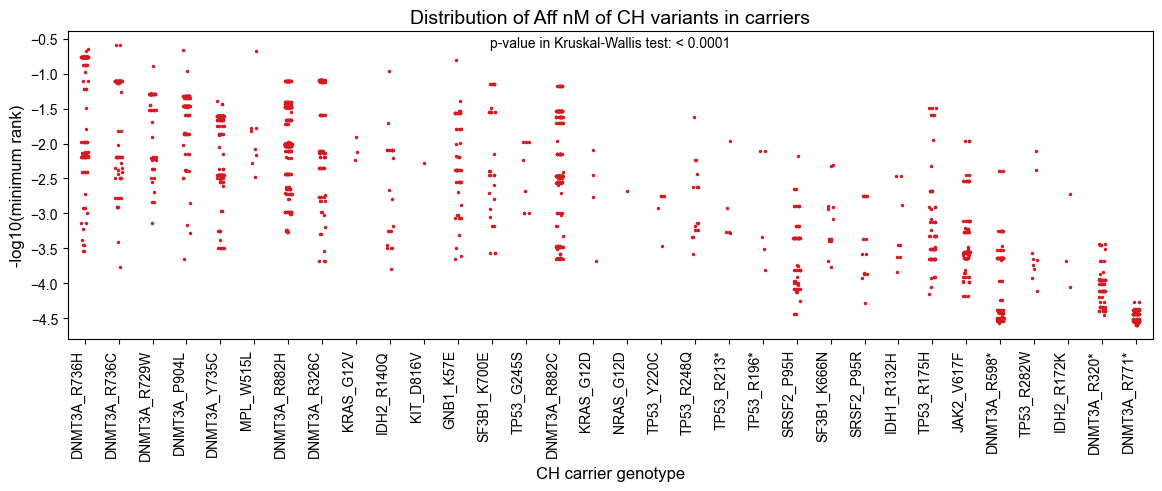

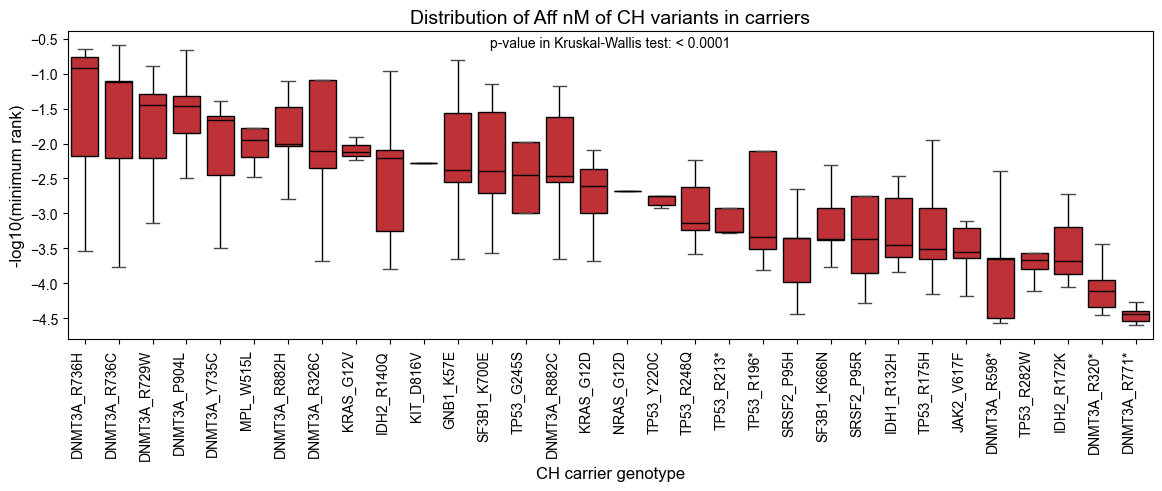

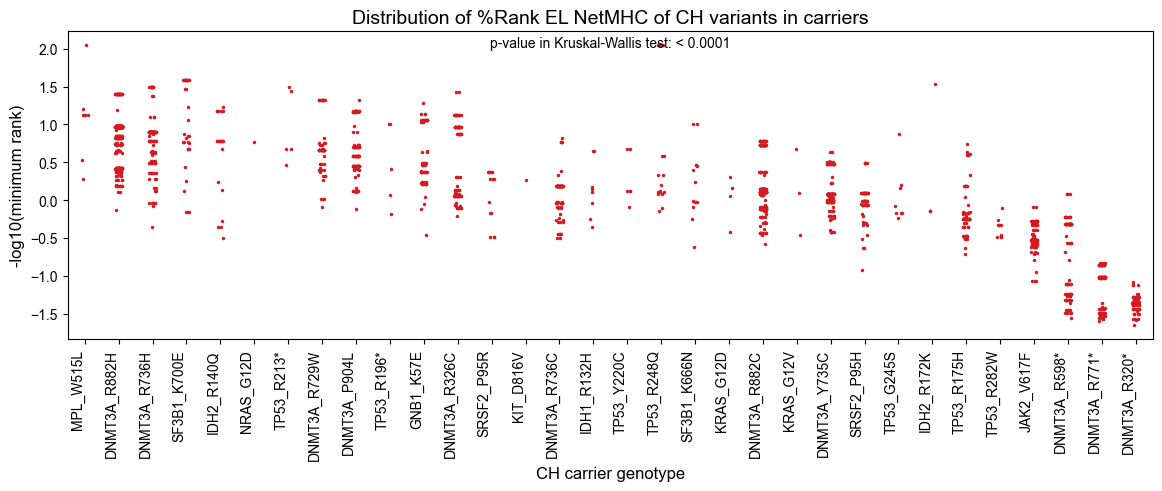

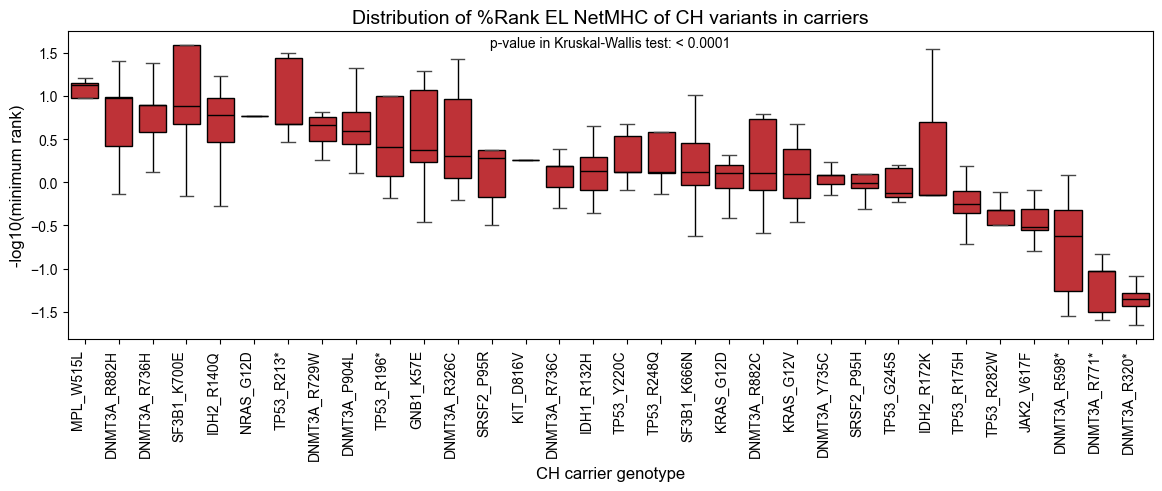

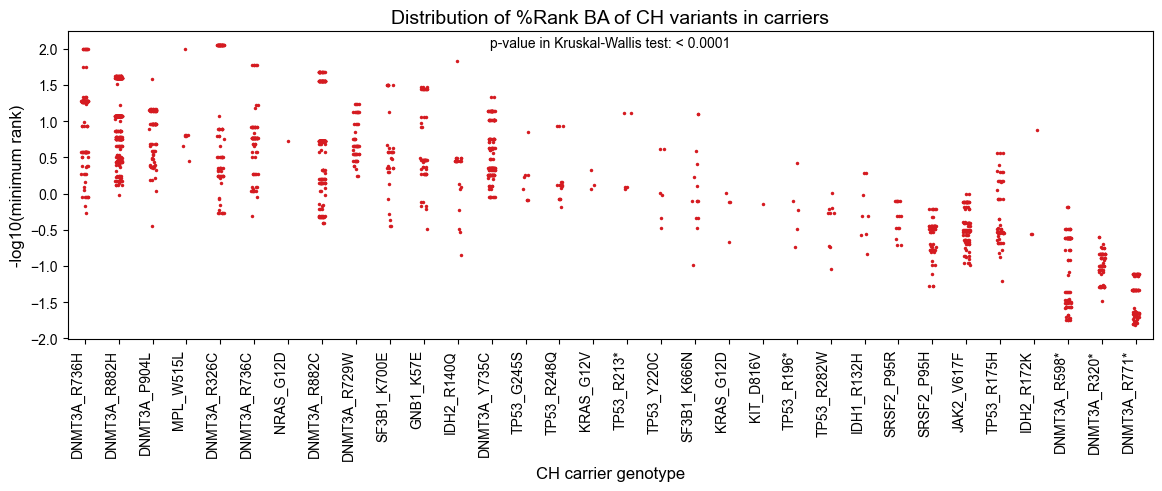

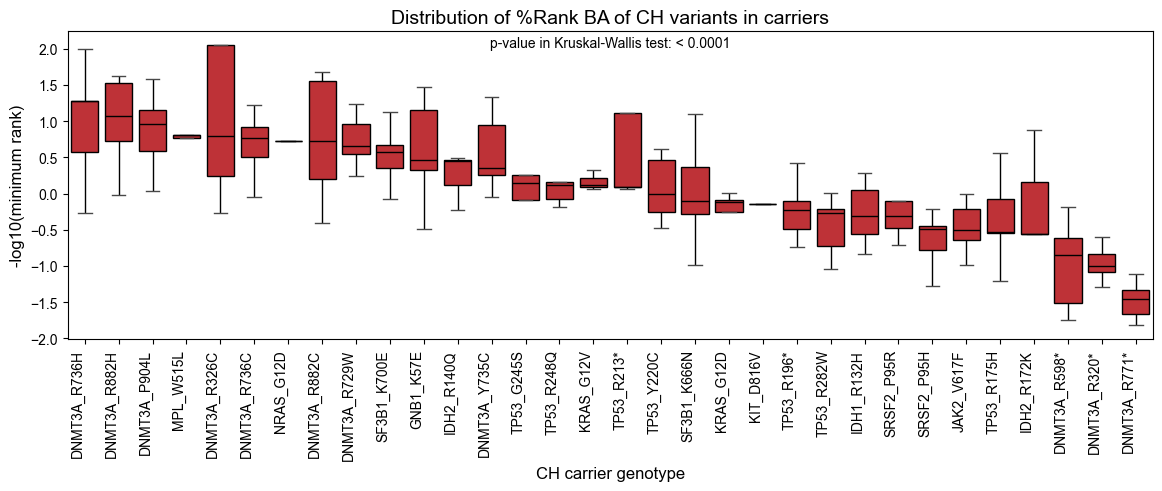

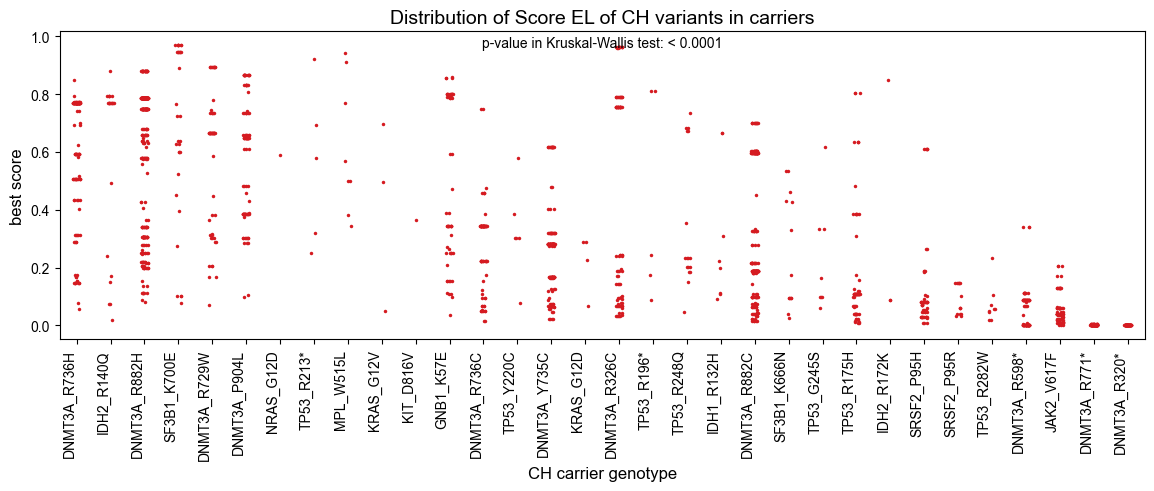

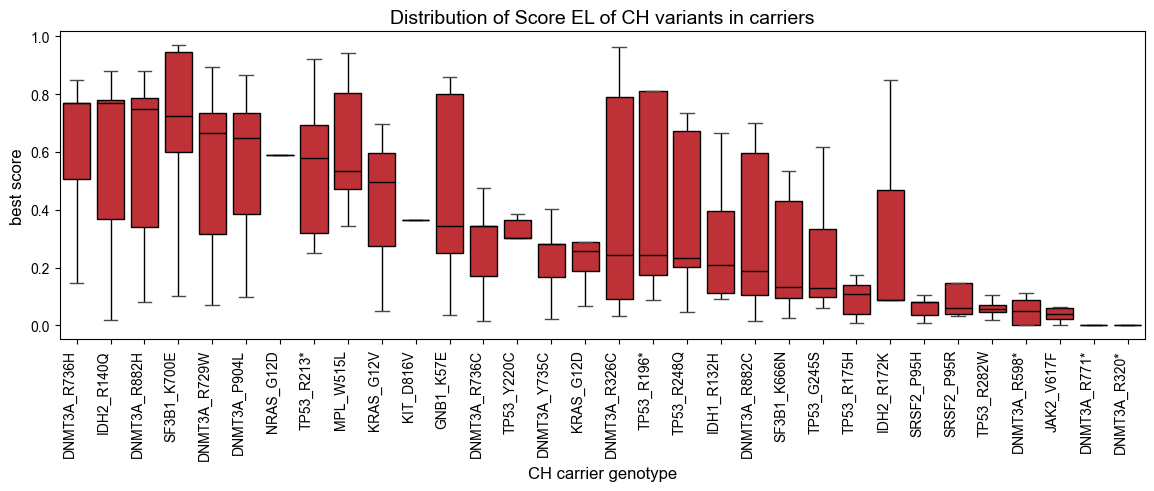

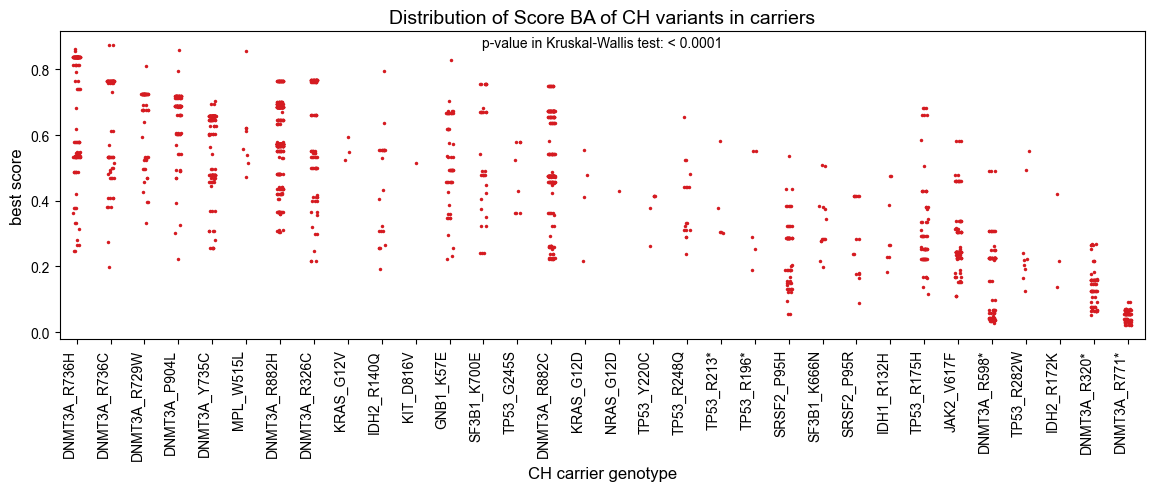

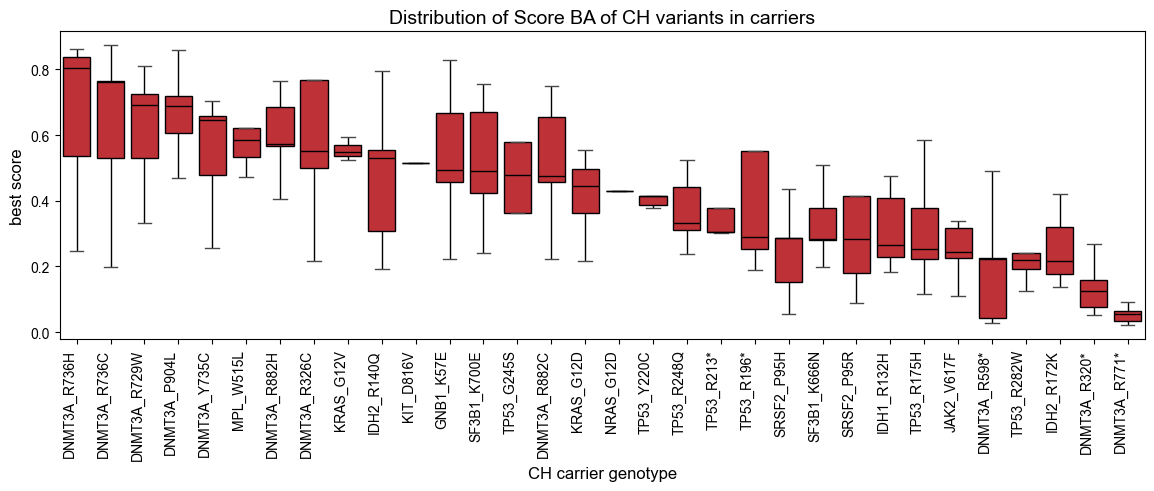

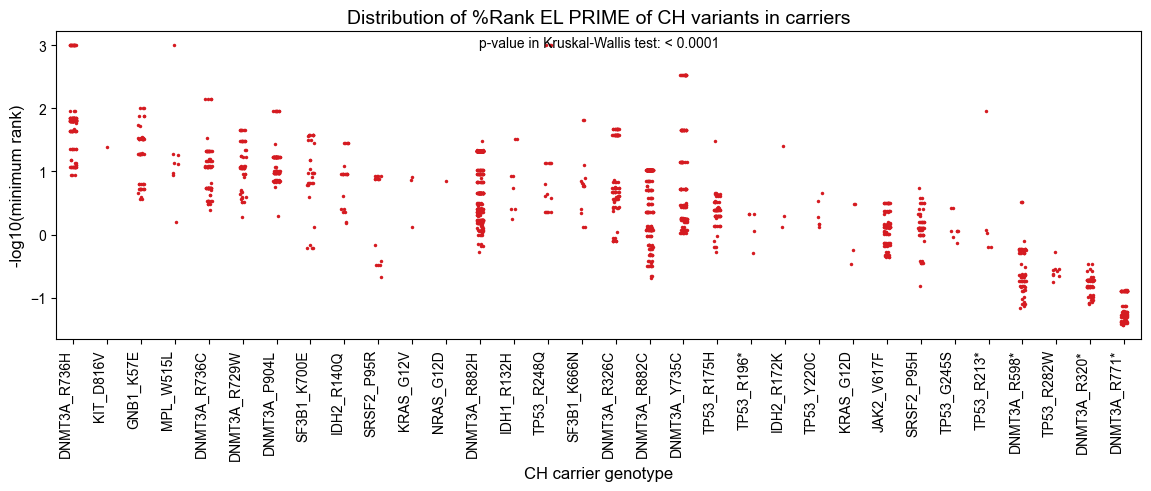

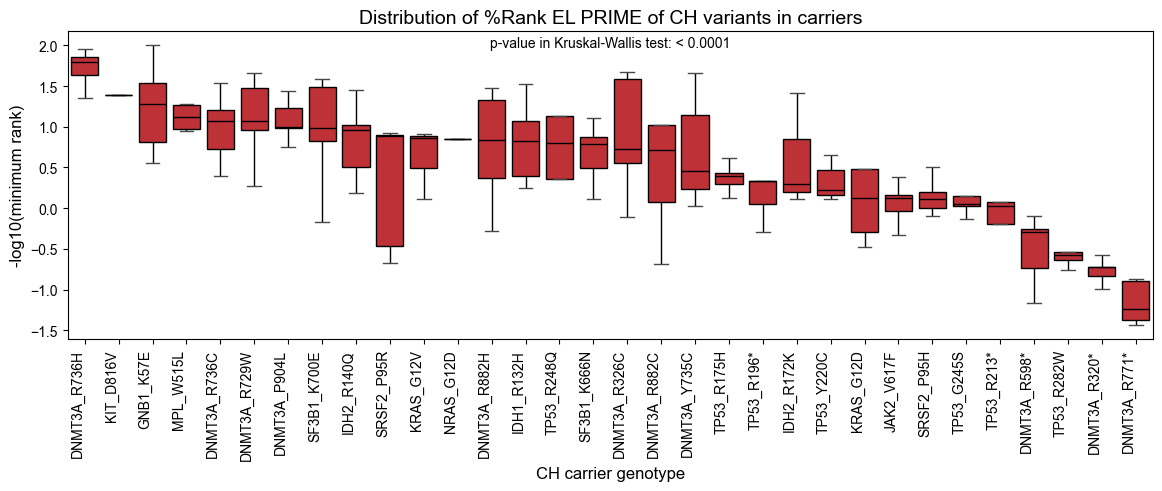

In [21]:

# EXTRA FIGURE: this is just to visualise the scores in carriers 
# COLOR SCHEME: reddish for CH / carriers, blue for non-carriers 

df_names = ['ch_best_aff', 'ch_best_el_rank', 'ch_best_ba_rank', 'ch_best_el_score', 'ch_best_ba_score', 'prime_ch_best_el_rank']
color = '#d51b21' # this is the color for scores that we are also using on figure 1

for name in df_names:

    df = globals()[name] 
    plot_scores_in_carries(df, color)


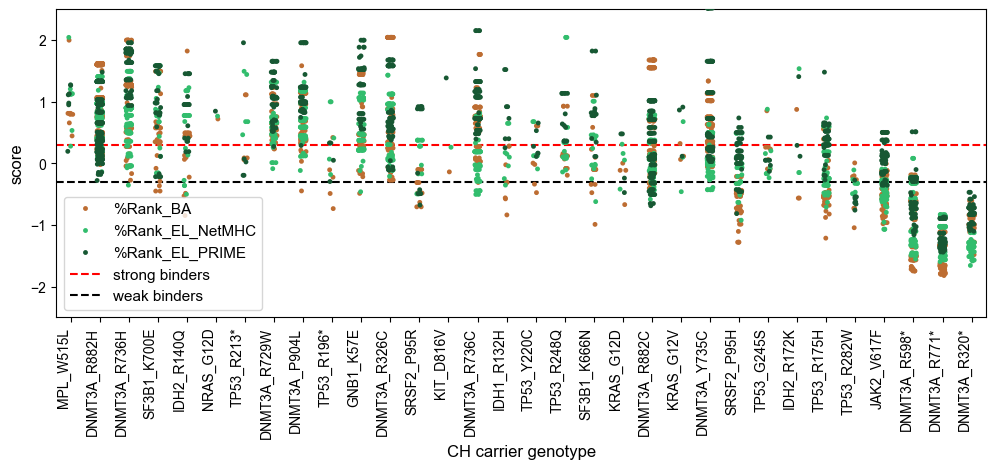

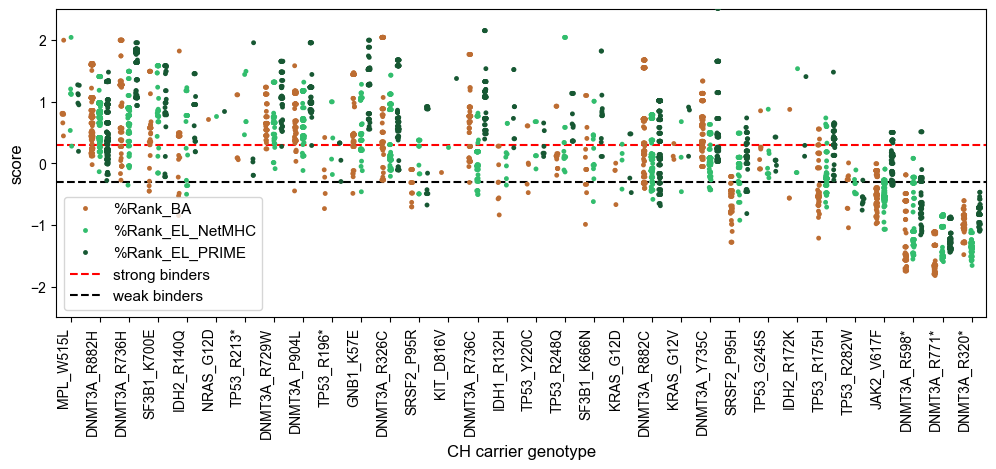

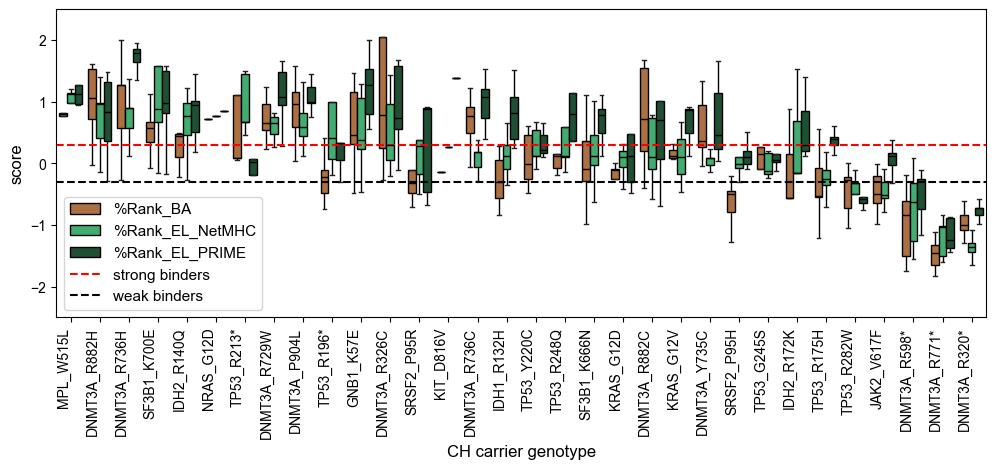

In [22]:

# EXTRA FIGURE to compare distribution of different types of scores (PRIME and NetMHC)
# ok so it's very pretty plotting this separately but tbf would be better to have this together side by side
# we will want to use %Rank_EL in the end, so let's use this to create the ordering 

# sort the dataframe so it plots with descending order
order = ch_best_el_rank_sort.gene_var.unique()

# we want to have: %Rank_BA, %Rank_EL NetMHC, %Rank_EL PRIME on one plot side by side 
df_scores_concat = pd.concat([ch_best_ba_rank, ch_best_el_rank, prime_ch_best_el_rank], axis = 0)
df_scores_sub = df_scores_concat[['Person_ID', 'gene_var', 'log_score', 'score_type']]
df_scores_melt = pd.melt(df_scores_sub, id_vars = ['Person_ID', 'gene_var', 'score_type'])

palette = ['#bd6d32', '#32bd6d', '#175833'] # make sure scores for PRIME and NetMHC are consistent with figure 1 

# PLOT 1: JITTER
plt.figure(figsize=(12,4)) # set figure size
p1 = sns.stripplot(x="gene_var", y="value", data=df_scores_melt, hue = "score_type", palette=palette, order = order, size = 3.5) # jitter
plt.xlabel('CH carrier genotype', fontsize = 12)
plt.ylabel('score', fontsize = 12)
plt.ylim(-2.5, 2.5)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
plt.yticks(fontsize = 10)
# add thresholds for strong and weak binding (from software)
plt.axhline(y=-1*np.log10(0.5), color='red', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='black', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)
plt.legend(fontsize = 11)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_comparison_distribution_in_carriers_stripplot.pdf', bbox_inches='tight')

plt.figure(figsize=(12,4)) # set figure size
p1 = sns.stripplot(x="gene_var", y="value", data=df_scores_melt, hue = "score_type", palette=palette, order = order, dodge = True, size = 3.5) # jitter
plt.xlabel('CH carrier genotype', fontsize = 12)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
plt.ylabel('score', fontsize = 12)
plt.ylim(-2.5, 2.5)
# add thresholds for strong and weak binding (from software)
plt.axhline(y=-1*np.log10(0.5), color='red', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='black', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)
plt.legend(fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_comparison_distribution_in_carriers_stripplot_dodged.pdf', bbox_inches='tight')

# PLOT 2: BOXPLOT
plt.figure(figsize=(12,4)) # set figure size
p1 = sns.boxplot(x="gene_var", y="value", data=df_scores_melt, hue = "score_type", showfliers = False, order = order, palette = palette, boxprops=dict(edgecolor='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black')) # do not include outliers
plt.xlabel('CH carrier genotype', fontsize = 12)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
plt.ylabel('score', fontsize = 12)
plt.ylim(-2.5, 2.5)
plt.axhline(y=-1*np.log10(0.5), color='red', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='black', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)
plt.legend(fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_{param}_comparison_distribution_in_carriers_boxplot.pdf', bbox_inches='tight')


In [23]:

## Plot as individual histograms  

def plot_score_dist_in_carrier(df, color):

    score = df.score_type[0]
    score_title = score.replace('_', ' ')

    ch_scores_melted = pd.melt(df, id_vars=['Person_ID', 'gene_var'])

    for var in ch_scores_melted['gene_var'].unique():
    
        df = ch_scores_melted[ch_scores_melted['variable'] == 'log_score'] # first, select log score 

        plt.figure(figsize=(6,3)) # set figure size
        
        var_name = var.split('_')[0:2]
        var_name = ' '.join(var_name)

        plt.title(f'{score_title} for {var_name} in carriers', fontsize = 14)
        
        plt.ylabel('Number of CH cases', fontsize = 12)
        
        # if you calculated log scores, use log scores 
        if 'log_score' in df.columns:
            sns.histplot(data=df[df['gene_var'] == f'{var}'], x=f'value', color=color, edgecolor = 'black')
            
            # add lines to indicate weak / strong binding 
            plt.axvline(x=-1 * np.log10(0.5), color='red', linestyle='--', label='Strong binders (< 0.5)')
            plt.axvline(x=-1 * np.log10(2), color='blue', linestyle='--', label='Weak binders (< 2)')
            plt.legend(fontsize = 8, loc = 'upper right')
            
            # specify x axis limits
            plt.xlim(-2.5, 3)
            plt.xlabel(f'-log10({score})', fontsize = 12)

        else:
            sns.histplot(data=df[df['gene_var'] == f'{var}'], x=f'value', color=color, edgecolor = 'black')
            plt.xlabel(f'{score}', fontsize = 12)
        
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_histogram_{score}_distribution_{var}.pdf', bbox_inches='tight')
        plt.close()

        

In [24]:

df_names = ['ch_best_aff', 'ch_best_el_rank', 'ch_best_ba_rank', 'ch_best_el_score', 'ch_best_ba_score', 'prime_ch_best_el_rank']
color = '#d51b21'

for name in df_names:

    df = globals()[name] 
    plot_score_dist_in_carrier(df, color)
    

# Find best scores for all CH variants examined

In [25]:

# define the function to find best scores 

def find_best_score_for_all_variants(row, df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries
   
    # it may be that we don't have this column in case we are doing this for non-CH cases
   
    variants = df['gene_var'] # get out variants which are present 
   
    scores = {} # initialise empy dictionaries

    # depending on the parameter, pick the minimum of maximum value 
    if param == "Aff_nM":
        for var in variants:
            # Find the minimum value for each variant in the category that is present
            best_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
            # Update the dictionary with the minimum value for the corresponding variant
            scores[f'score_{var}'] = best_value
        return pd.Series(scores)

    elif param == "Score_BA":
        for var in variants:
            
            best_value = max(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value
        
        return pd.Series(scores)

    elif param == "Score_EL":
        for var in variants:
           
            best_value = max(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            best_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_EL":
        for var in variants:
            
            best_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


In [27]:

# define a function to find best scores for all examined CH variants
def pred_to_scores_all_variants(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides

    For df, you can supply the dataframe with predictions either for NetMHC or PRIME
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    pred_sub_wide.columns = map(transform_format, pred_sub_wide.columns)

    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # create the prediction dataset 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1)
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    
    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # apply the function to find, for each participant, the best score for each examined CH variant 
    ch_scores_all_var = pd.concat([ch_hla_sub, ch_hla_sub.apply(find_best_score_for_all_variants, df=pred_sub, param=param, axis=1)], axis=1)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_scores_all_var, age_vaf, on = ['Person_ID', 'gene_var'])

    return ch_hla_merge


In [28]:

# run the function 
params = ["Aff_nM", 'Score_BA', 'Score_EL', '%Rank_BA', '%Rank_EL'] # allowed parameters (scores we are interested in)

scores_dict = {}

for param in params:

    key = f'ch_all_scores_{param}'
    df = pred_to_scores_all_variants(netmhc_all, param)

    scores_dict[key] = df

# get individual dataframes
ch_all_aff = scores_dict['ch_all_scores_Aff_nM']
ch_all_ba_score = scores_dict['ch_all_scores_Score_BA']
ch_all_el_score = scores_dict['ch_all_scores_Score_EL']
ch_all_ba_rank = scores_dict['ch_all_scores_%Rank_BA']
ch_all_el_rank = scores_dict['ch_all_scores_%Rank_EL']

# add a column to indicate the name of the scoring system that you used
ch_all_aff['score_type'] = 'Aff_nM'
ch_all_ba_score['score_type'] = 'Score_BA'
ch_all_el_score['score_type'] = 'Score_EL'
ch_all_ba_rank['score_type'] = '%Rank_BA'
ch_all_el_rank['score_type'] = '%Rank_EL_NetMHC'

prime_ch_all_el_rank = pred_to_scores_all_variants(prime, param)
prime_ch_all_el_rank['score_type'] = '%Rank_EL_PRIME'

In [29]:

# now let's also get best log_scores 
def find_best_score_all_variants_log(row, df, param):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries

    variants = df['gene_var']
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":
        for var in variants:

            # take maximum of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            # take maxium of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "Aff_nM":
        for var in variants:

            # take maxium of the negative log score (low aff = more immunogenic)
            best_value = max(-1 * np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


# define a function to find best scores for all examined CH variants
def pred_to_scores_all_variants_log(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    pred_sub_wide.columns = map(transform_format, pred_sub_wide.columns)

    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # create the prediction dataset 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1)
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    
    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # apply the function to find, for each participant, the best score for each examined CH variant 
    ch_scores_all_var = pd.concat([ch_hla_sub, ch_hla_sub.apply(find_best_score_all_variants_log, df=pred_sub, param=param, axis=1)], axis=1)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_scores_all_var, age_vaf, on = ['Person_ID', 'gene_var'])

    return ch_hla_merge


In [30]:

# run the function 
params = ['%Rank_BA', '%Rank_EL', 'Aff_nM'] # allowed parameters (scores we are interested in)
scores_dict_log = {}

for param in params:

    key = f'ch_all_scores_{param}'
    df = pred_to_scores_all_variants_log(netmhc_all, param)

    scores_dict[key] = df

# get individual dataframes
ch_all_ba_rank_log = scores_dict['ch_all_scores_%Rank_BA']
ch_all_el_rank_log = scores_dict['ch_all_scores_%Rank_EL']
ch_all_aff_log = scores_dict['ch_all_scores_Aff_nM']

# add a column to indicate the name of the scoring system that you used
ch_all_ba_rank_log['score_type'] = '%Rank_BA_log'
ch_all_el_rank_log['score_type'] = '%Rank_EL_log_NetMHC'
ch_all_aff_log['score_type'] = 'Aff_nM_log'

# do the same for PRIME (%EL_rank)
prime_ch_all_el_rank_log = pred_to_scores_all_variants_log(prime, '%Rank_EL')
prime_ch_all_el_rank_log['score_type'] = '%Rank_EL_log_PRIME'


In [31]:

# melt the dataset 
df_all_names = ['ch_all_aff', 'ch_all_ba_score', 'ch_all_el_score', 'ch_all_ba_rank', 'ch_all_el_rank', 'ch_all_ba_rank_log', 
'ch_all_el_rank_log', 'ch_all_aff_log', 'prime_ch_all_el_rank',  'prime_ch_all_el_rank_log']
dict_melted = {}

for name in df_all_names:

    df = globals()[name] 
    key = f'df_melted_{name}'

    score_columns = [col for col in df.columns if col.startswith('score_')]
    score_columns.remove('score_type') # get rid of this column, we don't want that 
    col_to_select = ['Person_ID', 'gene_var'] + score_columns
    df = df[col_to_select]

    df_melted = pd.melt(df, id_vars=['Person_ID', 'gene_var'])
    dict_melted[key] = df_melted

# get individual dataframes
ch_all_aff_melted = dict_melted['df_melted_ch_all_aff']
ch_all_ba_score_melted = dict_melted['df_melted_ch_all_ba_score']
ch_all_el_score_melted = dict_melted['df_melted_ch_all_el_score']
ch_all_ba_rank_melted = dict_melted['df_melted_ch_all_ba_rank']
ch_all_el_rank_melted = dict_melted['df_melted_ch_all_el_rank']
ch_all_aff_log_melted = dict_melted['df_melted_ch_all_aff_log']
ch_all_ba_rank_log_melted = dict_melted['df_melted_ch_all_ba_rank_log']
ch_all_el_rank_log_melted = dict_melted['df_melted_ch_all_el_rank_log']

prime_ch_all_el_rank_melted = dict_melted['df_melted_prime_ch_all_el_rank']
prime_ch_all_el_rank_log_melted = dict_melted['df_melted_prime_ch_all_el_rank_log']

# add a column to indicate the name of the scoring system that you used
ch_all_aff_melted['score_type'] = 'Aff_nM'
ch_all_ba_score_melted['score_type'] = 'Score_BA'
ch_all_el_score_melted['score_type'] = 'Score_EL'
ch_all_ba_rank_melted['score_type'] = '%Rank_BA'
ch_all_el_rank_melted['score_type'] = '%Rank_EL_NetMHC'
ch_all_aff_log_melted['score_type'] = 'Aff_nM_log'
ch_all_ba_rank_log_melted['score_type'] = '%Rank_BA_log'
ch_all_el_rank_log_melted['score_type'] = '%Rank_EL_log_NetMHC'

prime_ch_all_el_rank_melted['score_type'] = '%Rank_EL_PRIME'
prime_ch_all_el_rank_log_melted['score_type'] = '%Rank_EL_log_PRIME'

# In this dataset, for everyone you have the variant they carry (gene_var)
# and the score for each possible CH variant (variable)
# to find the score for the variant they have, need to find all cases where gene_var == log_score_gene_var_ch


In [32]:


# plot distribution of variant scores for each variant (histogram)
def plot_dist_variant_scores_all(df):

    score = df.score_type[0]
    score_title = score.replace('_', ' ')

    for var in df.gene_var.unique():
    
        var_name = var.split('_')[0:2]
        var_name = ' '.join(var_name)

        data = df[df['variable'] == f'score_{var}']
        data_carrier = data[data['gene_var'] == var]
        data_noncarrier = data[data['gene_var'] != var]

        # plot 1 (distribution)
        plt.figure(figsize=(6,3)) # set figure size
        sns.histplot(data, x=f'value', color='#27958d')
        plt.title(f'{score_title} for {var_name}', fontsize = 14)
        plt.xlabel(f'{score_title}', fontsize = 12)
        plt.ylabel('Number of CH cases', fontsize = 12)

        if "log" in score:
            plt.axvline(x=-1 * np.log10(0.5), color='red', linestyle='--', label='Strong binders (< 0.5)')
            plt.axvline(x=-1 * np.log10(2), color='black', linestyle='--', label='Weak binders (< 2)')
        
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_histogram_{score}_distribution_{var}.pdf', bbox_inches='tight')
        plt.close()

        # plot 2 (distribution splitting by carrier / non-carrier)
        # maybe better do a violin plot than a histogram 

        plt.figure(figsize=(6,3)) # set figure size

        # Plot violin plots
        values_noncarrier = data_noncarrier['value'].tolist()
        values_carrier = data_carrier['value'].tolist()
        combined_values = [values_noncarrier, values_carrier]
        ax = sns.violinplot(data=combined_values, palette = ['#323dbd', '#bd6d32'])
        plt.title(f'{score_title} for {var_name}', fontsize = 14)
        plt.xlabel(f'{score}', fontsize = 12)
        plt.ylabel('Value', fontsize = 12)

        # add kruskall test 
        statistic, p_value = kruskal(values_carrier, values_noncarrier)
        plt.text(0.5, 0.9, f'Kruskal-Wallis p-value: {p_value:.4f}', ha='center', va='center', transform=ax.transAxes)
        
        if "log" in score:
            plt.axhline(y=-1 * np.log10(0.5), color='red', linestyle='--', label='Strong binders (< 0.5)')
            plt.axhline(y=-1 * np.log10(2), color='black', linestyle='--', label='Weak binders (< 2)')
            
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_histogram_{score}_distribution_{var}_split.pdf', bbox_inches='tight')
        plt.close()


In [33]:

df_names_melted = ['ch_all_aff_melted', 'ch_all_ba_score_melted', 'ch_all_el_score_melted', 
    'ch_all_ba_rank_melted', 'ch_all_el_rank_melted', 'ch_all_aff_log_melted', 'ch_all_ba_rank_log_melted', 'ch_all_el_rank_log_melted',
    'prime_ch_all_el_rank_melted', 'prime_ch_all_el_rank_log_melted']

for name in df_names_melted:

    df = globals()[name] 
    plot_dist_variant_scores_all(df)
    

In [34]:

# add is_variant_present column

dict_melt_add = {}

for name in df_names_melted:

    df = globals()[name] 
    df['is_variant_present'] = df.apply(lambda row: row['gene_var'] in row['variable'], axis=1)

    levels = [True, False] # set order of levels for plotting
    df['is_variant_present'] = pd.Categorical(df['is_variant_present'].astype(bool), categories=levels, ordered=True) # convert to categorical
    df['gene_var'] = df['gene_var'].astype('category') # convert to categorical

    # NOTE: I want to sort by log score for present variants
    df['gene_var'] = df['gene_var'].astype(str) # convert gene_var to string (not category)
    df['variable'] = df['variable'].astype(str)
    df['mean_variant_score'] = df.groupby('variable')['value'].transform('mean')
    df_sort = df.sort_values(by='mean_variant_score', ascending = False)

    key = f'df_melted_{name}'
    dict_melt_add[key] = df_sort

ch_all_aff_melted_sort = dict_melt_add['df_melted_ch_all_aff_melted']
ch_all_ba_score_melted_sort = dict_melt_add['df_melted_ch_all_ba_score_melted']
ch_all_el_score_melted_sort = dict_melt_add['df_melted_ch_all_el_score_melted']
ch_all_ba_rank_melted_sort = dict_melt_add['df_melted_ch_all_ba_rank_melted']
ch_all_el_rank_melted_sort = dict_melt_add['df_melted_ch_all_el_rank_melted']
ch_all_aff_log_melted_sort = dict_melt_add['df_melted_ch_all_aff_log_melted']
ch_all_ba_rank_log_melted_sort = dict_melt_add['df_melted_ch_all_ba_rank_log_melted']
ch_all_el_rank_log_melted_sort = dict_melt_add['df_melted_ch_all_el_rank_log_melted']
prime_ch_all_el_rank_melted_sort = dict_melt_add['df_melted_prime_ch_all_el_rank_melted']
prime_ch_all_el_rank_log_melted_sort = dict_melt_add['df_melted_prime_ch_all_el_rank_log_melted']


# Compare variant scores between carriers and non-carriers 

In [35]:

# note: this is comparison between carriers of variant X and other CH carriers 
from scipy.stats import mannwhitneyu

# PLOT1: is there a difference in variant scores in carriers vs non-carriers?
def plot_carries_vs_non_score_diff(df):
    
    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    colors = ['#d51b21', '#1b7ed5']
    df['is_variant_present2'] = df['is_variant_present'].map({True: 'Carrier', False: 'Non-carrier'})
    xaxis_scores = df.variable
    plot_labels = [category[6:] for category in xaxis_scores]
    
    df['median_score'] = df[df['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
    df_sort = df.sort_values(by='median_score', ascending = False)
    order = df_sort.gene_var.unique()
    
    # plot 1 (boxplot)
    plt.figure(figsize = (20,5))
    p = sns.boxplot(y='value', x=plot_labels, hue='is_variant_present2', data=df, showfliers = False, palette = colors, order = order)
    plt.title(f'{score_title}', fontsize = 10)
    plt.xlabel('CH variant', fontsize = 18)
    plt.ylabel(f'{score_title}', fontsize = 18)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation = 90, fontsize = 14)   
    plt.yticks(fontsize = 14)
    plt.legend(title = 'Carrier status', loc = 'upper right', fontsize = 14, title_fontsize = 16)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant.pdf', bbox_inches='tight')

    # plot 2 (stripplot)
    plt.figure(figsize = (20,5))
    p = sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df, jitter = True, dodge = True, size = 2, palette = colors, order = order, alpha = 0.2)
    plt.title(f'{score_title}', fontsize = 10)
    plt.xlabel('CH variant', fontsize = 18)
    plt.ylabel(f'{score_title}', fontsize = 18)
    plt.xticks(rotation = 90, fontsize = 14)   
    plt.yticks(fontsize = 14)
    plt.legend(title = 'Carrier status', markerscale=6, loc = 'upper right', fontsize = 14, title_fontsize = 16)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.ylim(-2.5, 3.5)

    # okay we also want to add a line to indicate where the mean is for each category + hue
    # btw I am doing mean but can do median too - tho doing both on one plots seems like too much?

    for i, category in enumerate(order):
        
        median_carrier = df[(df['variable'] == f'score_{category}') & (df['is_variant_present'] == True)].value.median()
        median_noncarrier = df[(df['variable'] == f'score_{category}') & (df['is_variant_present'] == False)].value.median()

        # Plot text for each hue group
        plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#d51b21')
        plt.text(i + 0.5, median_noncarrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#1b7ed5')

    # okay no we want to add the kruskall-wallis test to this to see if there are any differences between variant scores 
    for i, category in enumerate(order):
        category_data = df[df['variable'] == f'score_{category}']
        max_value = category_data['value'].max()
        groups = [group['value'].values for name, group in category_data.groupby('is_variant_present')]
        statistic, p_value = mannwhitneyu(*groups)
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant.pdf', bbox_inches='tight')

    # jitter but without all the fancy add-ons just in case 
    plt.figure(figsize = (20,5))
    p = sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df, jitter = True, dodge = True, size = 2, palette = colors, order = order, alpha = 0.2)
    plt.title(f'Distribution of {score_title} across CH variants', fontsize = 10)
    plt.xlabel('CH variant', fontsize = 18)
    plt.ylabel(f'{score_title}', fontsize = 18)
    plt.xticks(rotation = 90, fontsize = 14)   
    plt.yticks(fontsize = 14)
    plt.legend(title = 'Carrier status', markerscale=6, loc = 'upper right', fontsize = 14, title_fontsize = 16)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.ylim(-2.5, 3.5)
    
    # still add median but no statistical testing stuff 
    for i, category in enumerate(order):
            
            median_carrier = df[(df['variable'] == f'score_{category}') & (df['is_variant_present'] == True)].value.median()
            median_noncarrier = df[(df['variable'] == f'score_{category}') & (df['is_variant_present'] == False)].value.median()

            # Plot text for each hue group
            plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#d51b21')
            plt.text(i + 0.5, median_noncarrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#1b7ed5')

    # okay no we want to add the kruskall-wallis test to this to see if there are any differences between variant scores 
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_no_pvalue.pdf', bbox_inches='tight')


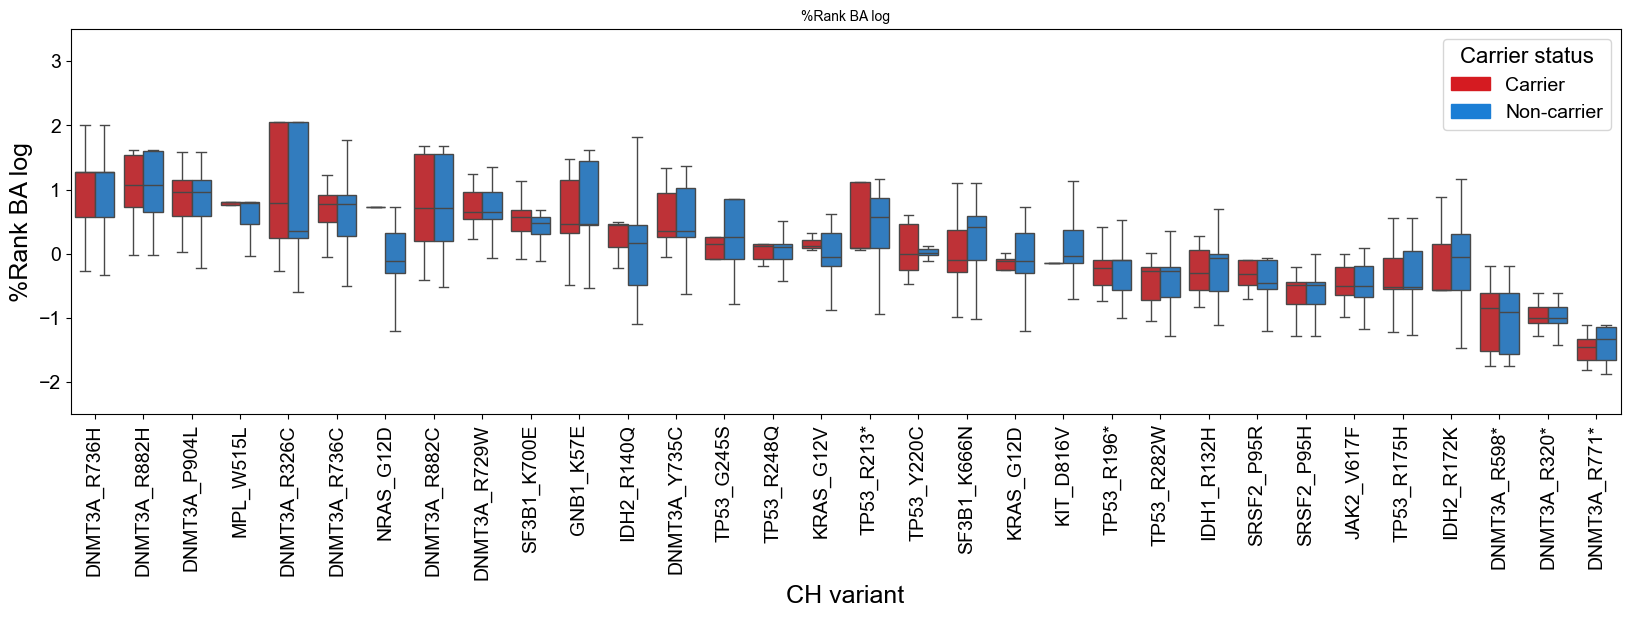

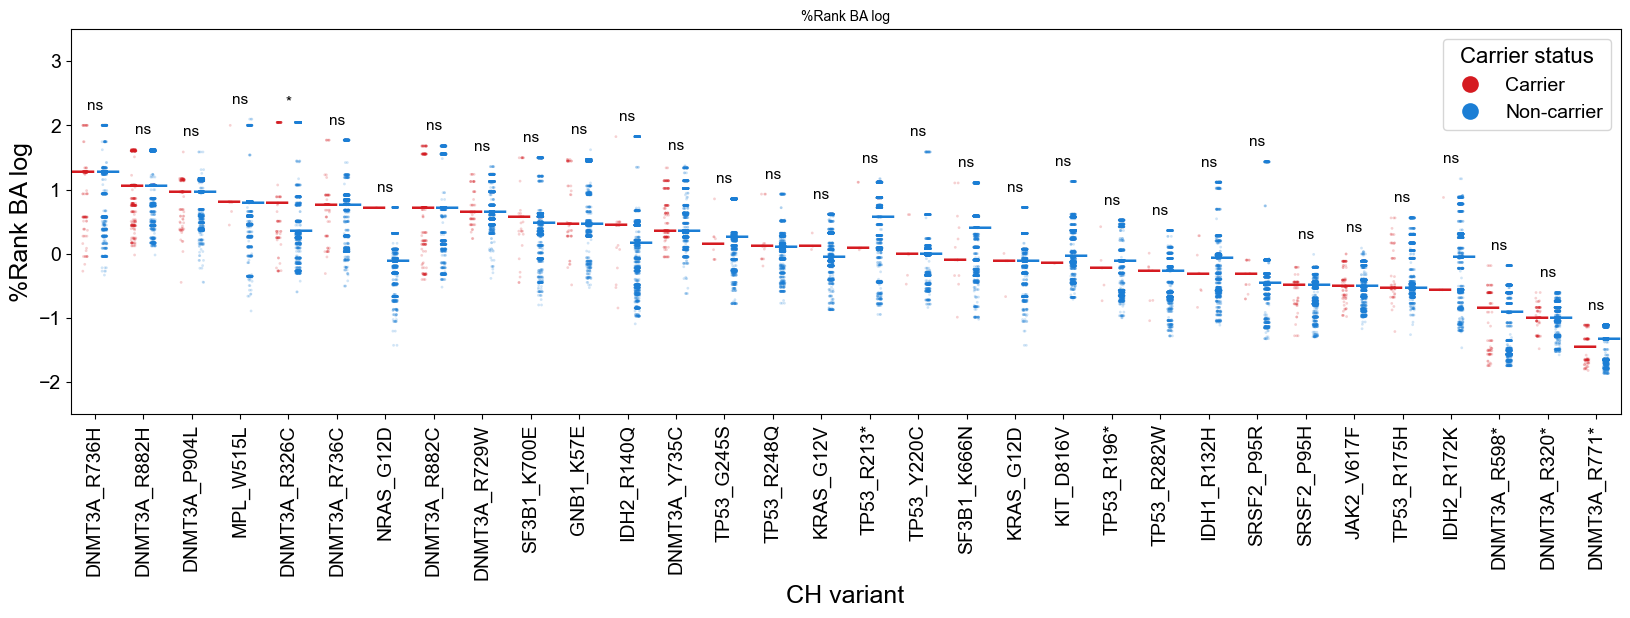

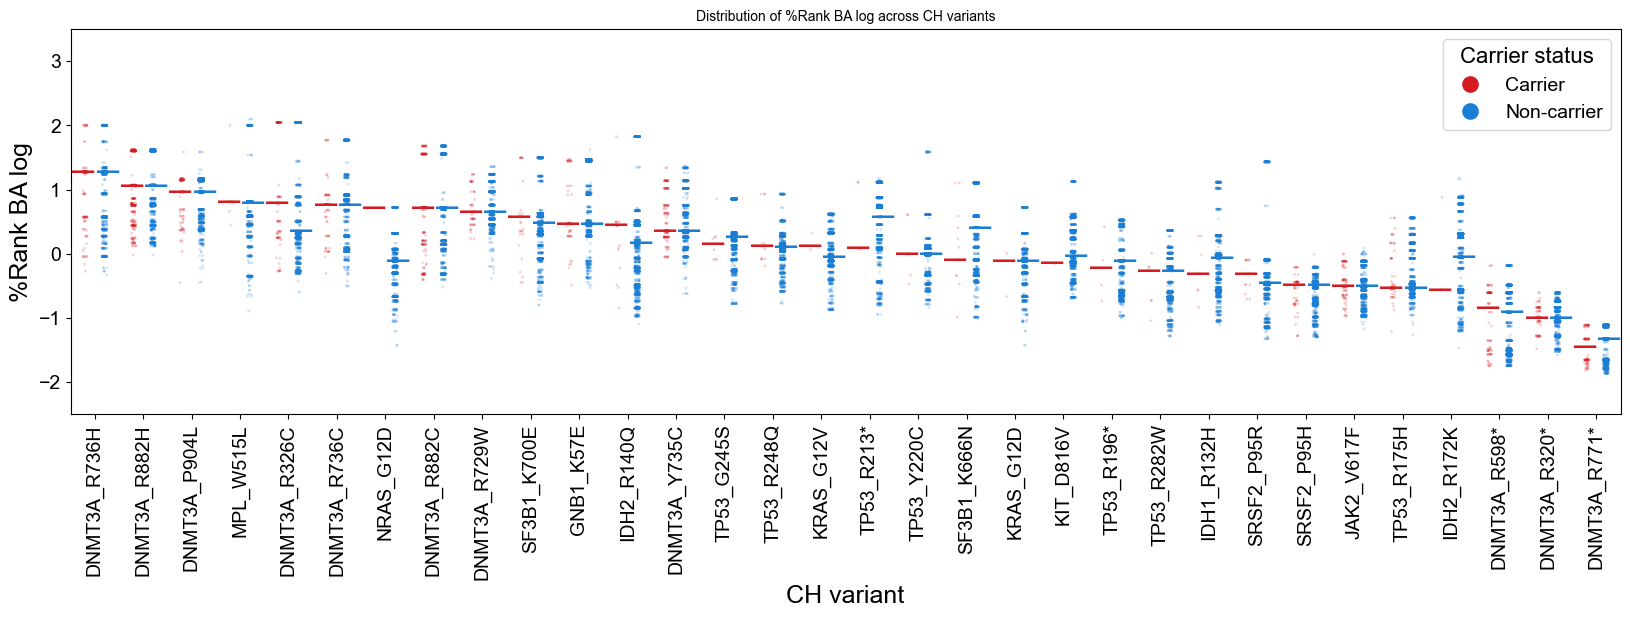

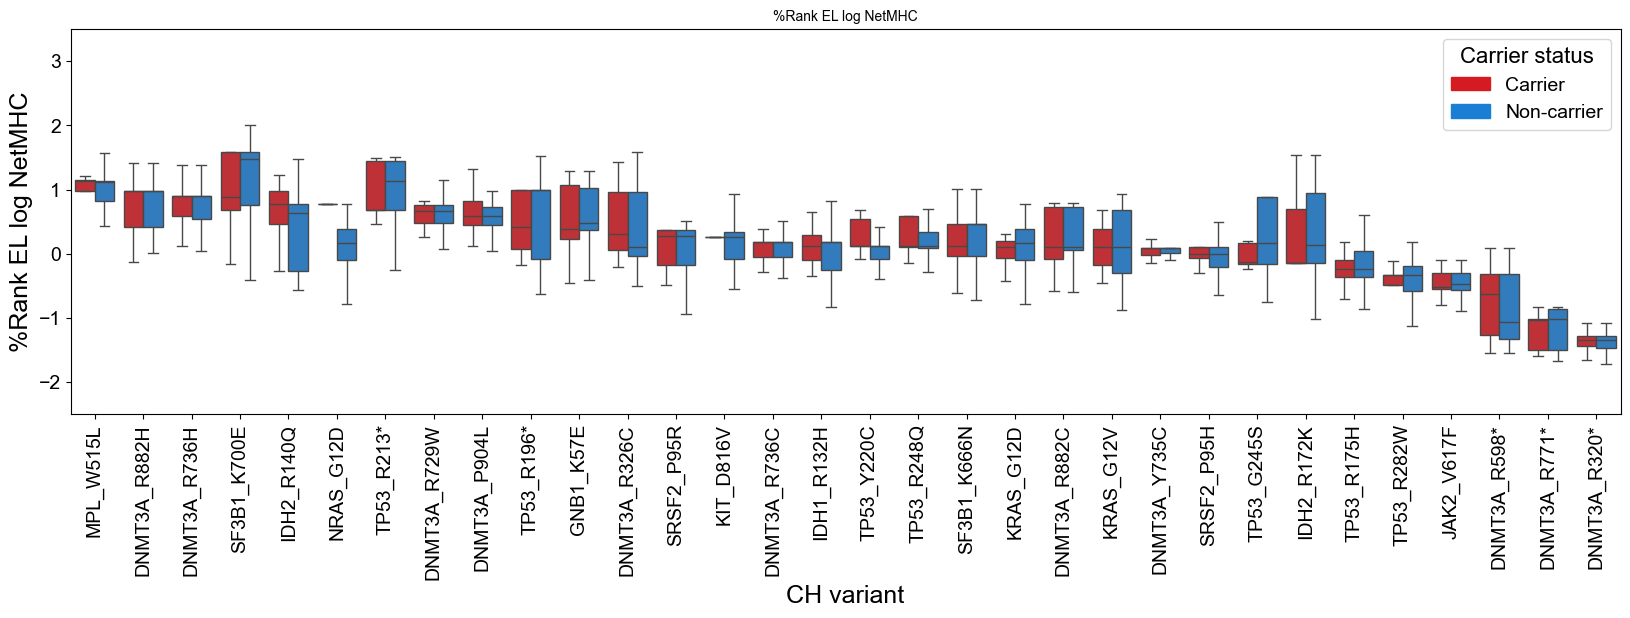

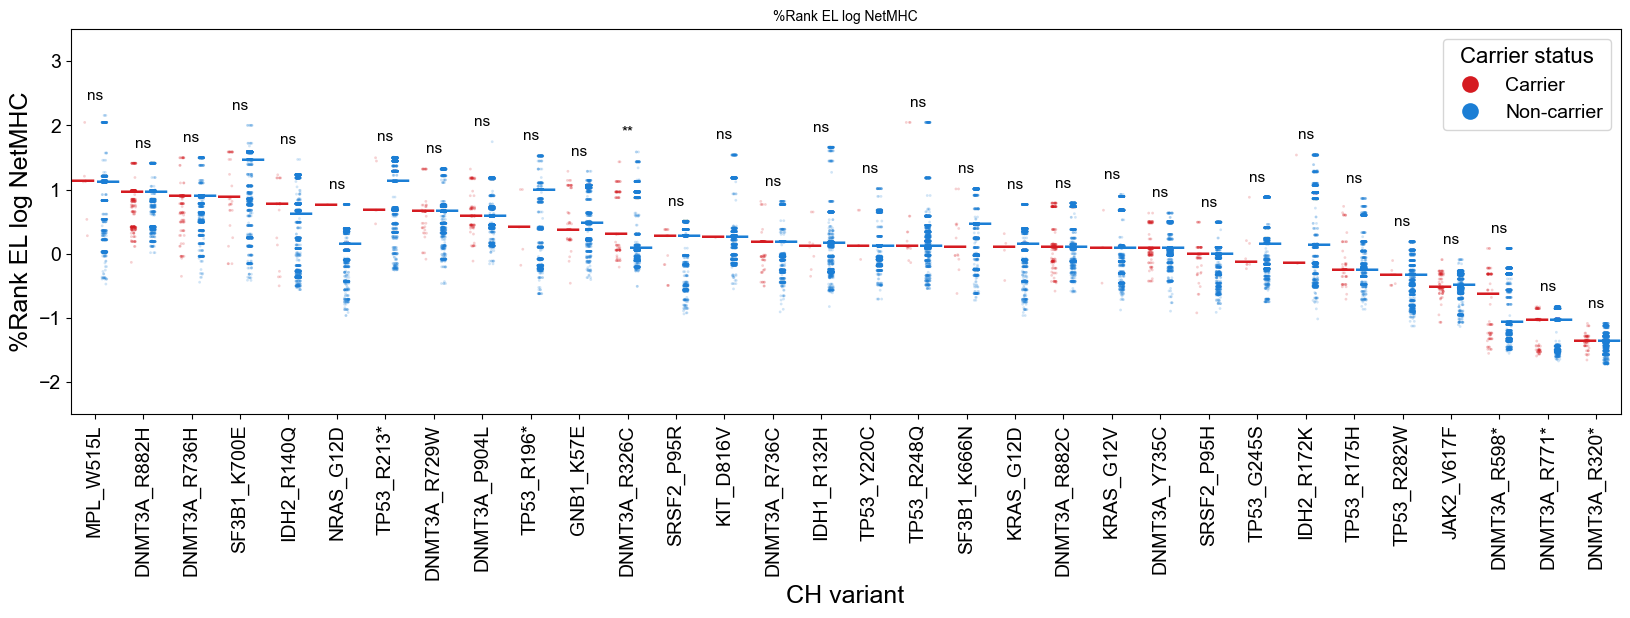

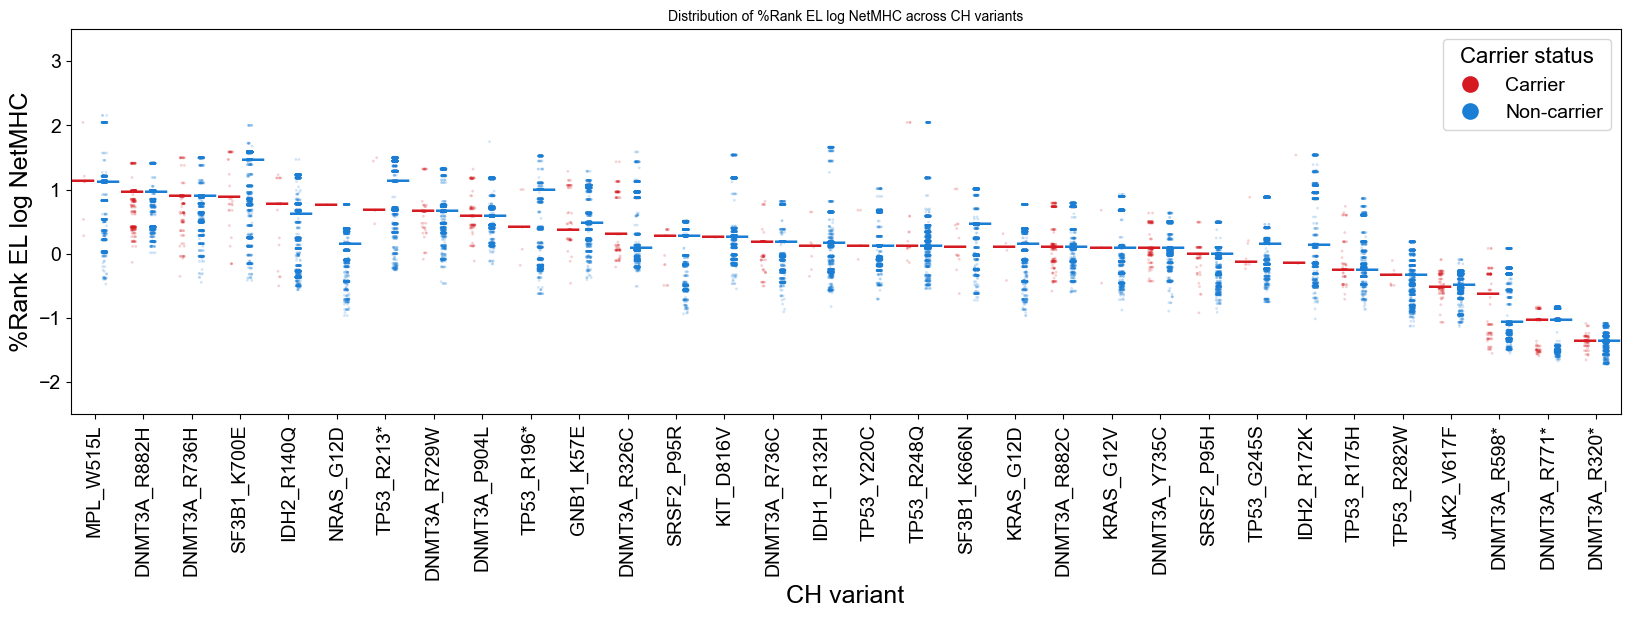

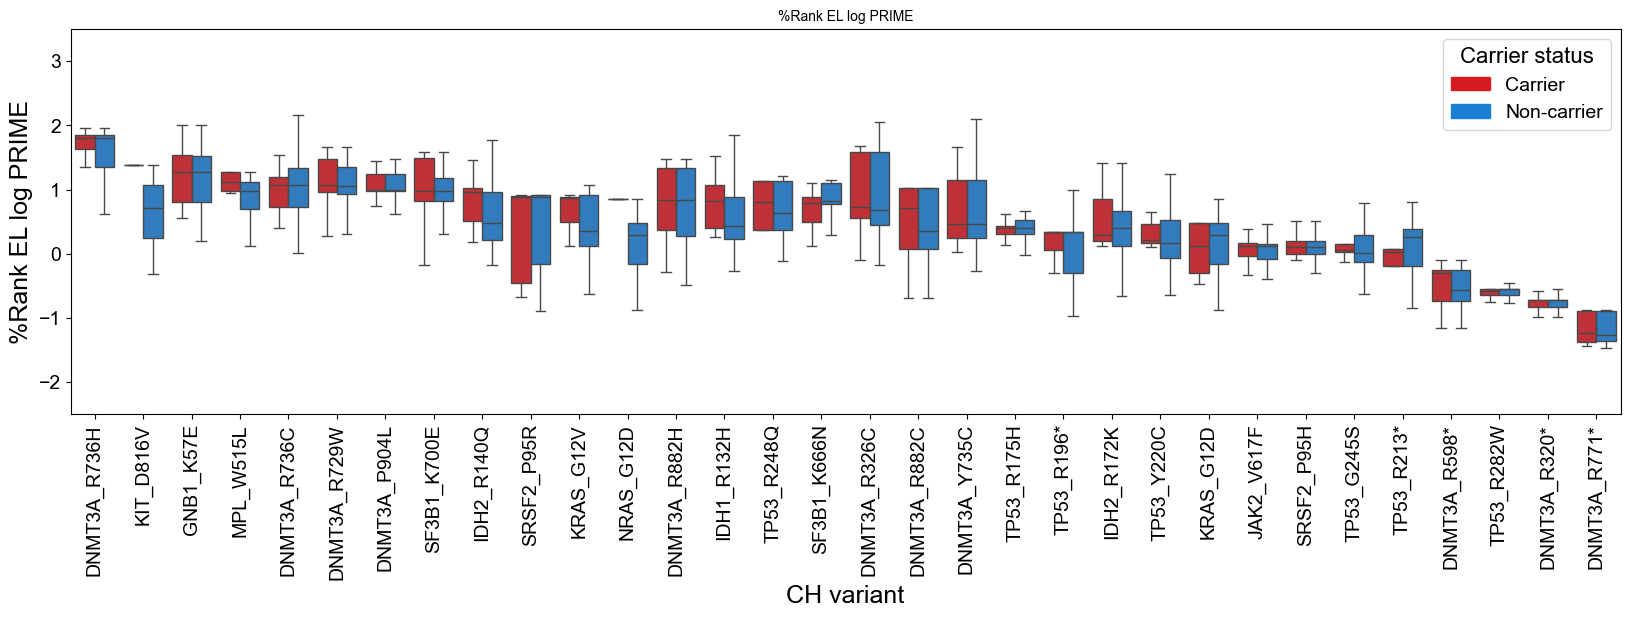

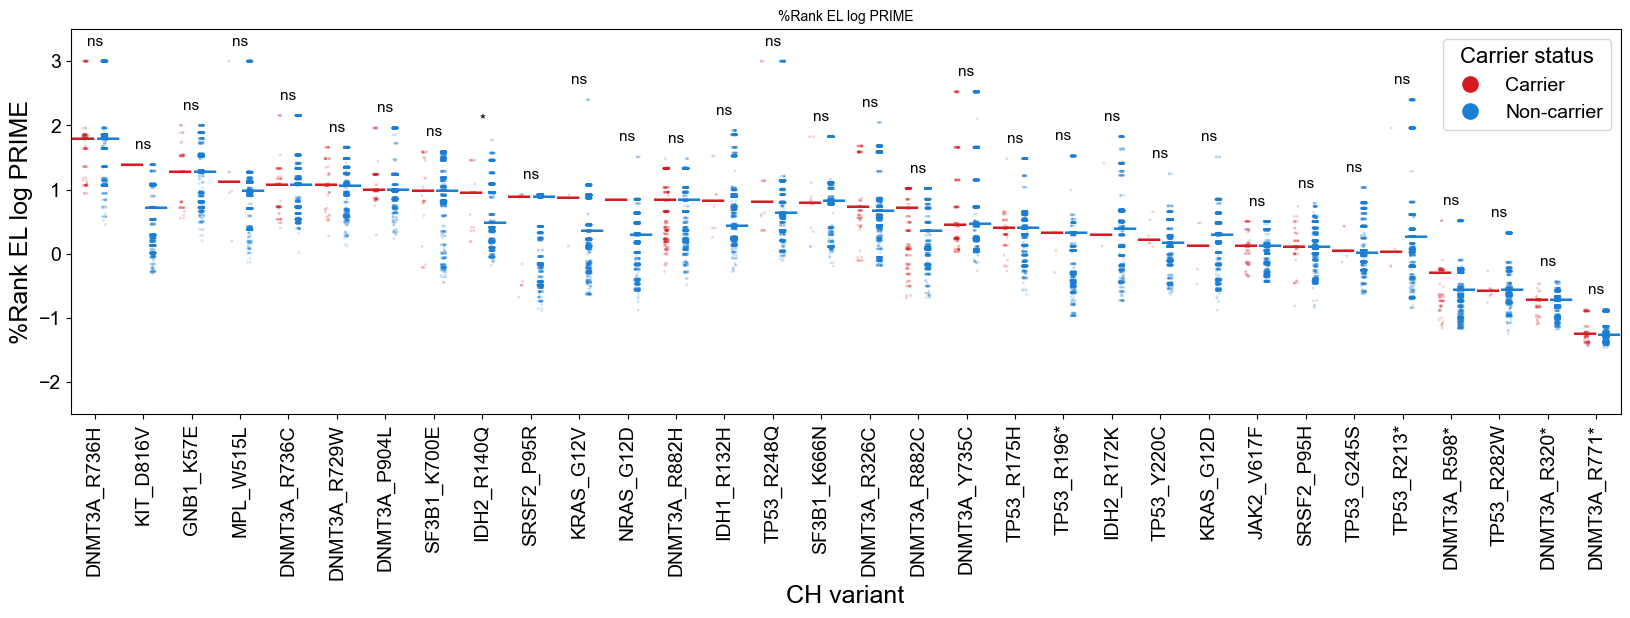

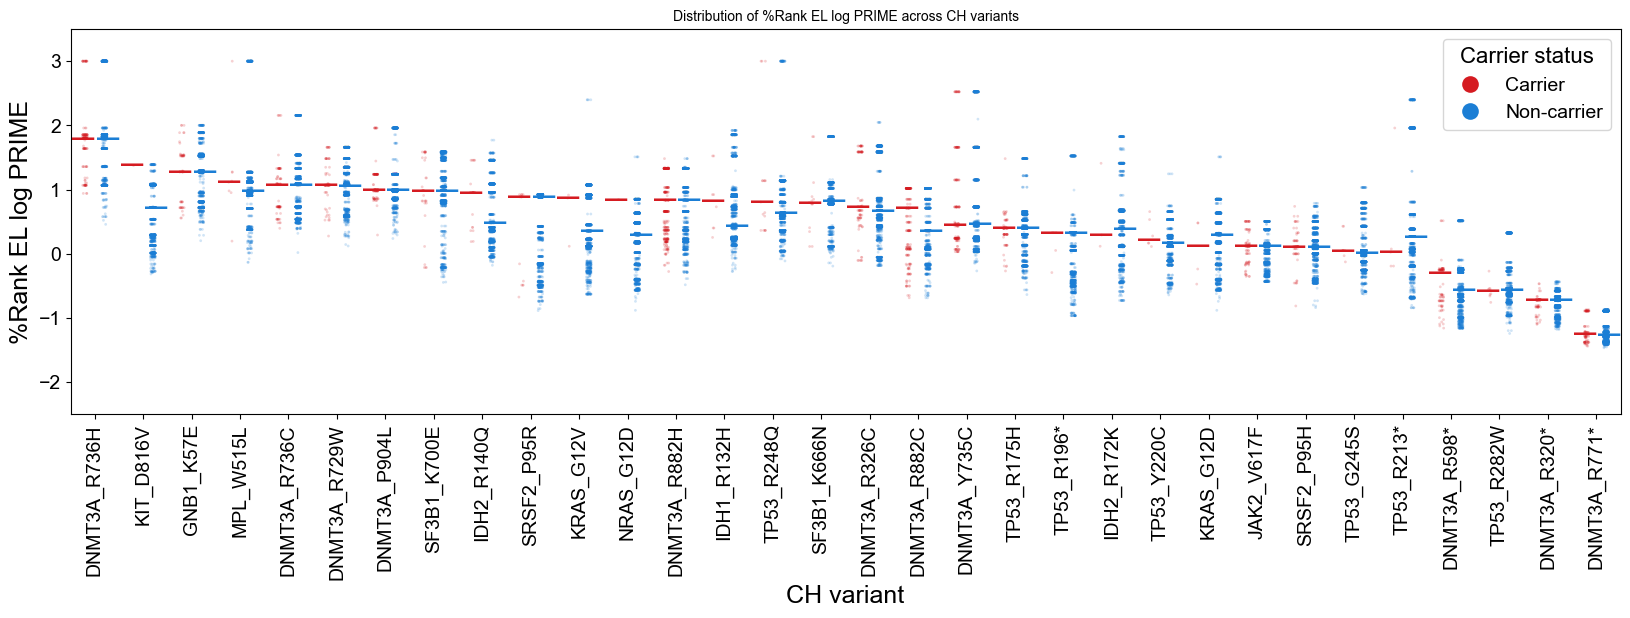

In [36]:

df_names_melted_sorted = ['ch_all_ba_rank_log_melted_sort', 'ch_all_el_rank_log_melted_sort', 'prime_ch_all_el_rank_log_melted_sort']

variants_present = ch_all_aff_melted_sort[ch_all_aff_melted_sort['is_variant_present']==True].variable.unique().tolist()

for name in df_names_melted_sorted:

    # get the dataframe 
    df = globals()[name] 

    # first of all, for each dataframe, ONLY get the 'variable' which we have actually typed 
    df = df[df['variable'].isin(variants_present)]

    # create the plot
    plot_carries_vs_non_score_diff(df)
    

In [37]:

# separate stop codons (not immunogenic) and substitutions (immunogenic)

# PLOT1: is there a difference in variant scores in carriers vs non-carriers?

def plot_carries_vs_non_score_diff_facets(df):
    
    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    colors = ['#d51b21', '#1b7ed5']
    df['is_variant_present2'] = df['is_variant_present'].map({True: 'Carrier', False: 'Non-carrier'})

    # split by mutation order
    df_stop = df[df['mutation_type'] == 'nonsense']
    df_sub = df[df['mutation_type'] == 'missense']
        
    # STOP CODONS (NONSENSE)
    df_stop['median_score'] = df_stop[df_stop['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_stop_sort = df_stop.sort_values(by='median_score', ascending = False)
    df_stop_sort['gene_var'] = df_stop_sort['gene_var'].astype(str)
    order = df_stop_sort.variable.unique()
    
    xaxis_scores = df_stop_sort.variable
    plot_labels = [category[6:] for category in xaxis_scores]
    
    # JITTER
    plt.figure(figsize = (5,5))
    sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_stop_sort, jitter = True, dodge = True, size = 2, palette = colors, alpha = 0.4)
    plt.title(f'Nonsense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation=90, fontsize = 11)
    plt.yticks(fontsize = 11)
    
    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):
            
        median_carrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == True)].value.median()
        median_noncarrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == False)].value.median()

        # Plot text for each hue group
        plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=20, fontweight='bold', color = '#d51b21')
        plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=20, fontweight='bold', color = '#1b7ed5')

        # add results of a statistical test (Mann-Whitney)
        max_value = df_stop_sort[df_stop_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.legend(title = 'Carrier status', markerscale = 4, loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend() 
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_stop.pdf', bbox_inches='tight')

    # BOXPLOT

    plt.figure(figsize = (5,5))
    sns.boxplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_stop_sort, showfliers = False, palette = colors)
    plt.title(f'Nonsense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation=90, fontsize = 12)  
    plt.yticks(fontsize = 12)  

    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):

        # add results of a statistical test (Mann-Whitney)
        max_value = df_stop_sort[df_stop_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.1+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.legend(title = 'Carrier status', loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_stop.pdf', bbox_inches='tight')
  
    # SUBSTITUTIONS (MISSENSE)
    
    df_sub['median_score'] = df_sub[df_sub['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_sub_sort = df_sub.sort_values(by='median_score', ascending = False)
    order = df_sub_sort.variable.unique()

    xaxis_scores = df_sub_sort.variable
    plot_labels = [category[6:] for category in xaxis_scores]
    
    # JITTERPLOT 
    
    plt.figure(figsize = (15,5))
    sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_sub_sort, jitter = True, dodge = True, size = 2, palette = colors, alpha = 0.4)
    plt.title(f'Missense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)

    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):
        
        median_carrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == True)].value.median()
        median_noncarrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == False)].value.median()

        # Plot text for each hue group
        plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=15, fontweight='bold', color = '#d51b21')
        plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=15, fontweight='bold', color = '#1b7ed5')

        # add results of a statistical test (Mann-Whitney)
        max_value = df_sub_sort[df_sub_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.xticks(rotation=90, fontsize = 12)  
    plt.yticks(fontsize = 12)  
    plt.legend(title = 'Carrier status', markerscale = 6, loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_sub.pdf', bbox_inches='tight')
  
    # BOXPLOT

    plt.figure(figsize = (15,5))
    sns.boxplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_sub_sort, showfliers = False, palette = colors)
    plt.title(f'Missense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation=90, fontsize = 12)  
    plt.yticks(fontsize = 12)  
        
    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):
        
        # add results of a statistical test (Mann-Whitney)
        max_value = df_sub_sort[df_sub_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.1+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.legend(title = 'Carrier status', loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_sub.pdf', bbox_inches='tight')
  

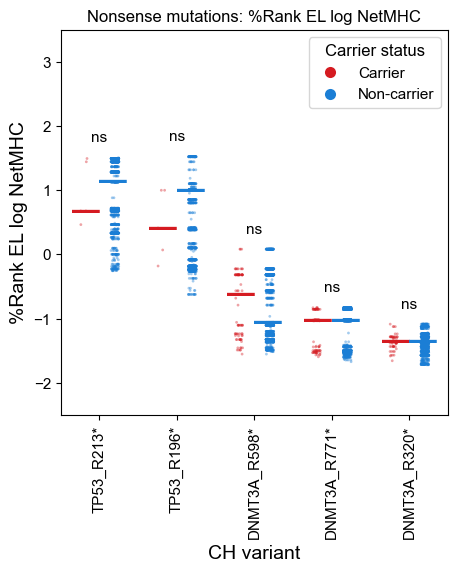

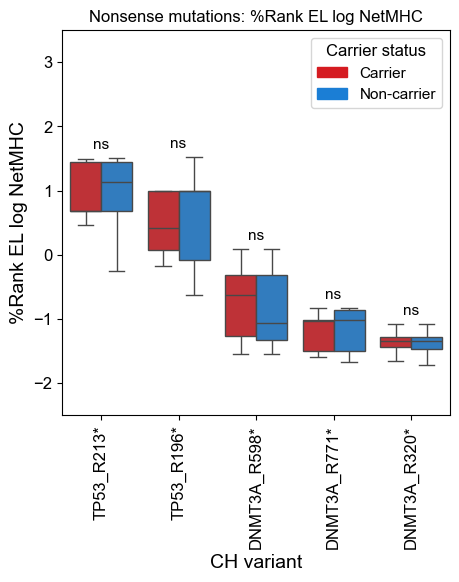

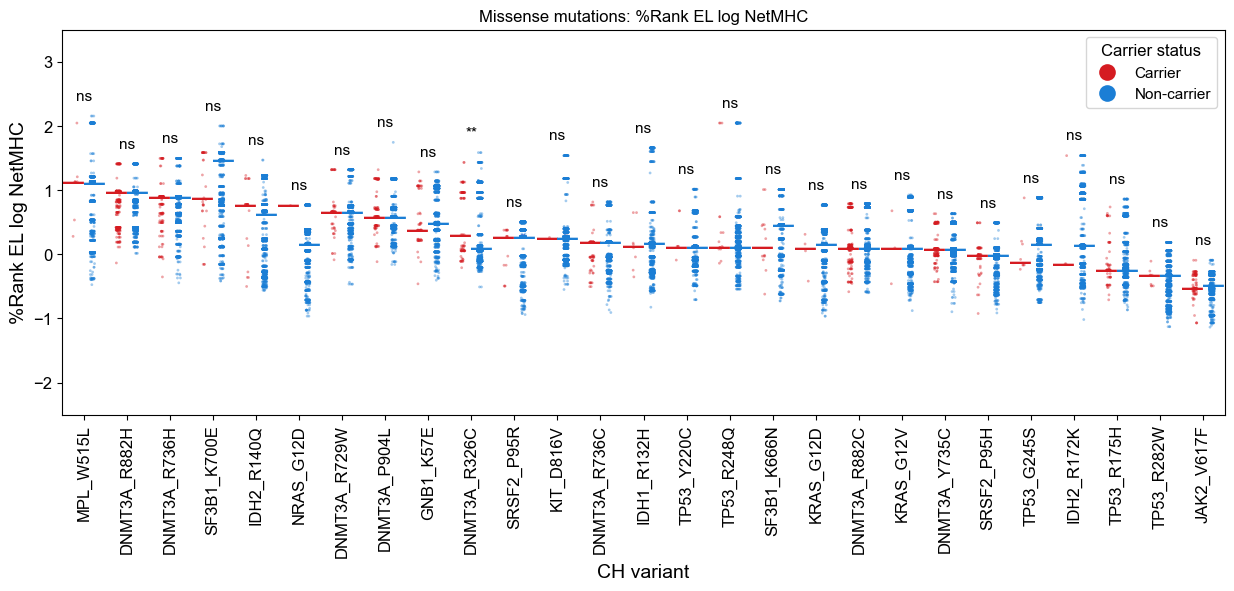

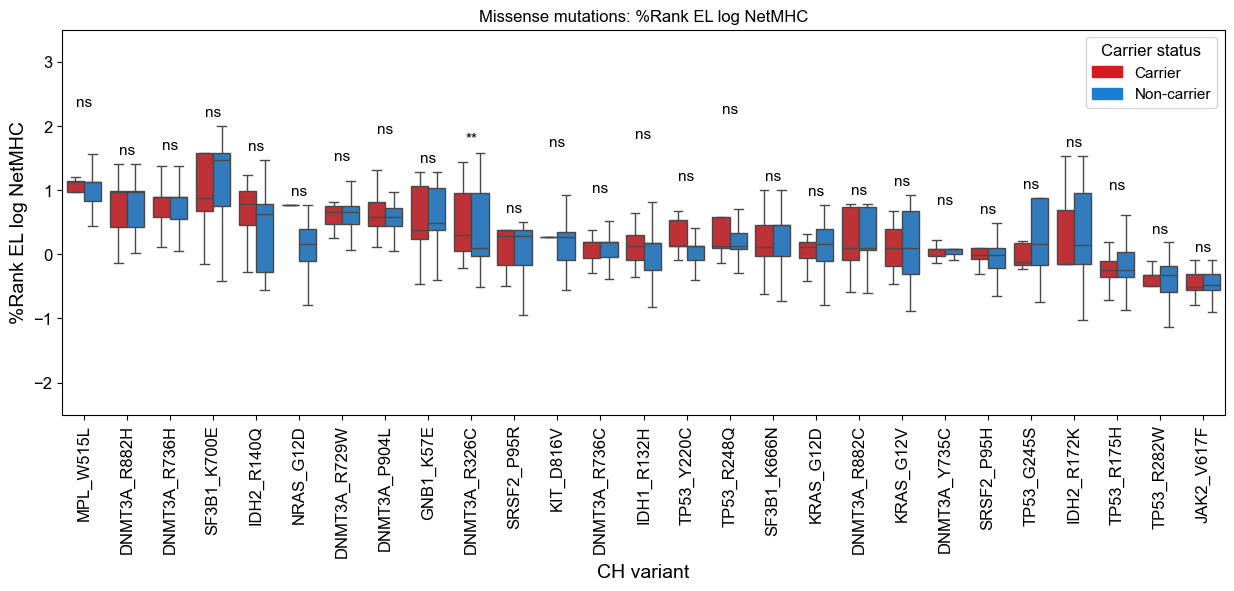

In [38]:

# okay I would also like to split this by STOP codons vs substitutions because you can treat stop as negative control (no surveillance)
# df_names_melted_sorted = ['ch_all_ba_rank_log_melted_sort', 'ch_all_el_rank_log_melted_sort', 'prime_ch_all_el_rank_log_melted_sort']
df_names_melted_sorted = ['ch_all_el_rank_log_melted_sort']

variants_present = ch_all_aff_melted_sort[ch_all_aff_melted_sort['is_variant_present']==True].variable.unique().tolist()

for name in df_names_melted_sorted:

    # get the dataframe 
    df = globals()[name] 

    df = df[df['variable'].isin(variants_present)] # only plot this for variants we actually typed

    # add column with mutation type 
    df['mutation_type'] = df['variable'].apply(lambda x: 'nonsense' if x[-1] == '*' else 'missense') # non-sense: stop codon, mis-sense: substitution

    # plot with facets
    plot_carries_vs_non_score_diff_facets(df)
    

In [39]:
    
# aggregate

def plot_carrier_vs_non_aggregate(df):
    
    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    colors = ['#f00071', '#0497ed']
    df['is_variant_present2'] = df['is_variant_present'].map({True: 'Carrier', False: 'Non-carrier'})

    # split by mutation order
    df_stop = df[df['mutation_type'] == 'nonsense']
    df_sub = df[df['mutation_type'] == 'missense']

    colors = ['#d51b21', '#1b7ed5']

    # JITTER

    # Non-sense (STOP codons)
    df_stop['median_score'] = df_stop[df_stop['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_stop_sort = df_stop.sort_values(by='median_score', ascending = False)
    order = df_stop_sort.variable.unique()

    plt.figure(figsize = (4,4))
    sns.stripplot(y='value', x='is_variant_present2', data=df_stop_sort, jitter = True, size = 3, palette = colors, alpha = 0.2)
    plt.title(f'Nonsense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11)  

    statistic, p_value = mannwhitneyu(df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'], 
            df_stop[df_stop['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    median_carrier = df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'].median()
    median_noncarrier = df_stop[df_stop['is_variant_present2'] == 'Non-carrier']['value'].median()
    plt.text(0, median_carrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#d51b21')
    plt.text(1, median_noncarrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#1b7ed5')


    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_all_agg_stop.pdf', bbox_inches='tight')

    # Mis-sense (Substitutions)
    colors = ['#d51b21', '#1b7ed5']

    df_sub['median_score'] = df_sub[df_sub['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_sub_sort = df_sub.sort_values(by='median_score', ascending = False)
    order = df_sub_sort.variable.unique()

    plt.figure(figsize = (4,4))
    sns.stripplot(y='value', x='is_variant_present2', data=df_sub_sort, jitter = True, size = 3, palette = colors, alpha = 0.2)
    plt.title(f'Missense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11)  

    statistic, p_value = mannwhitneyu(df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'], 
            df_sub[df_sub['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    # add median values
    median_carrier = df_sub[df_sub['is_variant_present2'] == 'Carrier']['value'].median()
    median_noncarrier = df_sub[df_sub['is_variant_present2'] == 'Non-carrier']['value'].median()
    plt.text(0, median_carrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#d51b21')
    plt.text(1, median_noncarrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#1b7ed5')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_all_agg_sub.pdf', bbox_inches='tight')

    # BOXPLOT

    # Non-sense (STOP codons)
    plt.figure(figsize = (4,4))
    sns.boxplot(y='value', x='is_variant_present2',  data=df_stop, showfliers = False, palette = colors)
    plt.title(f'Nonsense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11) 

    statistic, p_value = mannwhitneyu(df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'], 
            df_stop[df_stop['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_all_agg_stop.pdf', bbox_inches='tight')
  
    # Mis-sense (Substitution)
    plt.figure(figsize = (4,4))
    sns.boxplot(y='value', x='is_variant_present2',  data=df_sub, showfliers = False, palette = colors)
    plt.title(f'Missense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11) 

    statistic, p_value = mannwhitneyu(df_sub[df_sub['is_variant_present2'] == 'Carrier']['value'], 
            df_sub[df_sub['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_all_agg_sub.pdf', bbox_inches='tight')
  

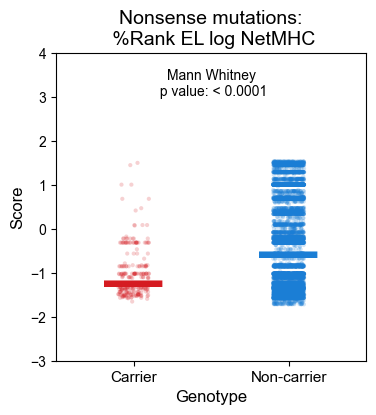

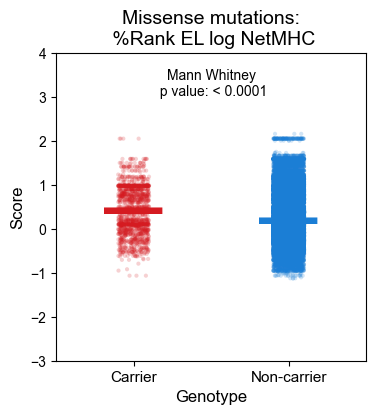

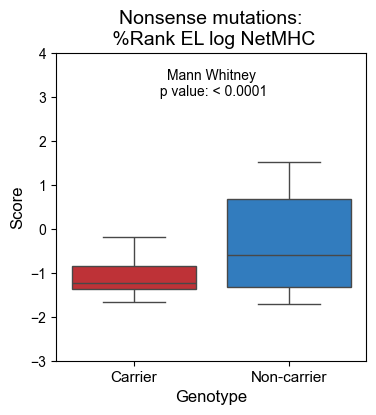

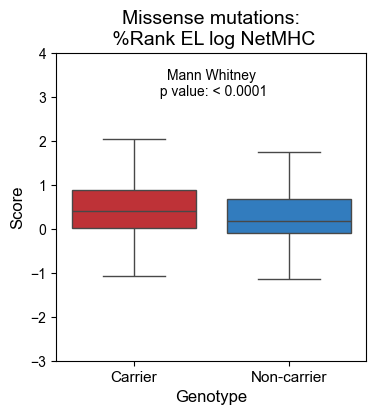

In [40]:

df_names_melted_sorted = ['ch_all_ba_rank_log_melted_sort', 'ch_all_el_rank_log_melted_sort', 'prime_ch_all_el_rank_log_melted_sort']
df_names_melted_sorted = ['ch_all_el_rank_log_melted_sort']

variants_present = ch_all_aff_melted_sort[ch_all_aff_melted_sort['is_variant_present']==True].variable.unique().tolist()

for name in df_names_melted_sorted:

    # get the dataframe 
    df = globals()[name] 

    df = df[df['variable'].isin(variants_present)] # only plot this for variants we actually typed
    df['is_variant_present2'] = df['is_variant_present'].map({True: 'Carrier', False: 'Non-carrier'})
    df['mutation_type'] = df['variable'].apply(lambda x: 'nonsense' if x[-1] == '*' else 'missense') # non-sense: stop codon, mis-sense: substitution

    # plot with facets
    plot_carrier_vs_non_aggregate(df)
    

# Compare score of variant carried to scores of other variants 

In [1]:

# PLOT2: Is the score of the variant in people who carry it different from scores of other variants?
# for this plot, order the df by score for present variants

def plot_scores_variant_carried_vs_other(df):

    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    colors = ['#911216', '#f1979a'] # I want similar colors but I guess not identical ones?

    # specify format of x axis labels
    xaxis_scores = df.variable
    plot_labels = [category[6:] for category in xaxis_scores]
    
    df['median_score'] = df[df['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
    df_sort = df.sort_values(by='median_score', ascending = False)
    order = df_sort.gene_var.unique()

    df_true = df[df['is_variant_present']==True]
    df_false = df[df['is_variant_present']==False]
    df['is_variant_present3'] = df['is_variant_present'].map({True: 'Variant carried', False: 'Other variants'})

    # plot 1: boxplot
    plt.figure(figsize = (16,4))
    sns.boxplot(x="gene_var", y="value", hue = 'is_variant_present3', data=df, showfliers = False, order = order, palette = colors)
    plt.ylim(-2.5, 3.5)
    plt.title(f'{score_title}', fontsize = 14)
    plt.xlabel('CH carrier genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.xticks(rotation = 90, fontsize = 11)
    plt.yticks(fontsize = 11)
    plt.legend(title='Variant in the CH case', loc = 'upper right', fontsize = 11, title_fontsize = 11)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_genotype.pdf', bbox_inches='tight')

    # plot 2: stripplot (side by side, I scrapped overlay because it looks terrible)
    plt.figure(figsize = (16,4))
    p = sns.stripplot(x="gene_var", y="value", hue = 'is_variant_present', data=df, dodge=True, size = 4, order = order, palette = colors, alpha = 0.3)
    plt.ylim(-2.5, 3.5)
    plt.title(f'{score_title}')
    plt.xlabel('CH carrier genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.xticks(rotation = 90, fontsize = 11)
    plt.yticks(fontsize = 11)
    plt.legend(title='Variant in the CH case', labels=['Variant carried', 'Other variants'], markerscale=2, loc = 'upper right', fontsize = 11, title_fontsize = 11)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)

    for i, category in enumerate(order):

        median_present = df[(df['gene_var'] == category) & (df['is_variant_present'] == True)]['value'].median()
        median_absent = df[(df['gene_var'] == category) & (df['is_variant_present'] == False)]['value'].median()
        plt.text(i, median_present, '—', ha='right', va='center', fontsize=13, fontweight='bold', color = '#911216')
        plt.text(i, median_absent, '—', ha='left', va='center', fontsize=13, fontweight='bold', color = '#f1979a')
        
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_jitter_correct_genotype_sidebyside.pdf', bbox_inches='tight')

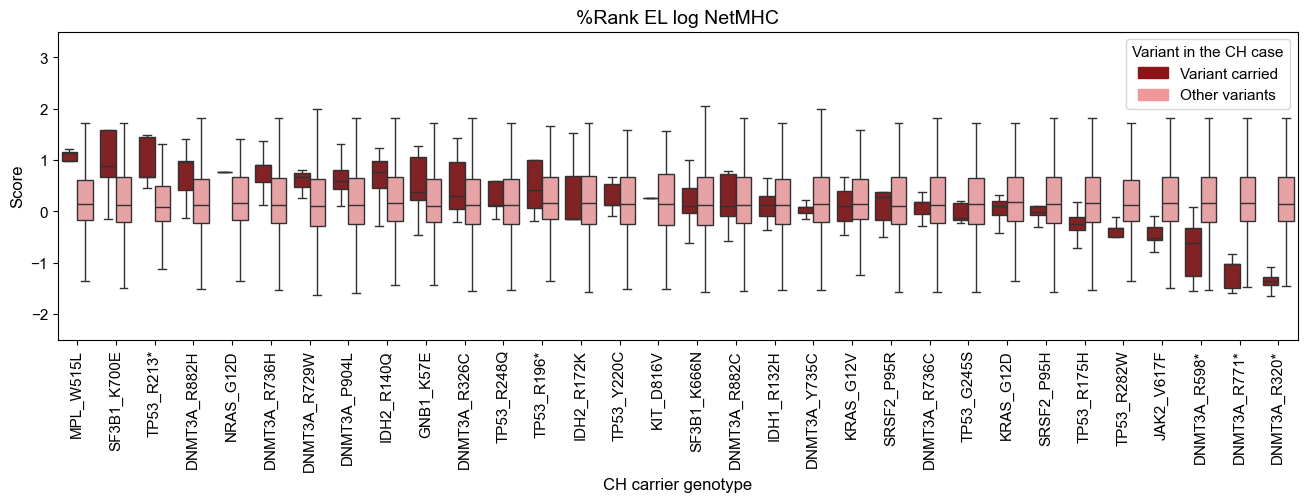

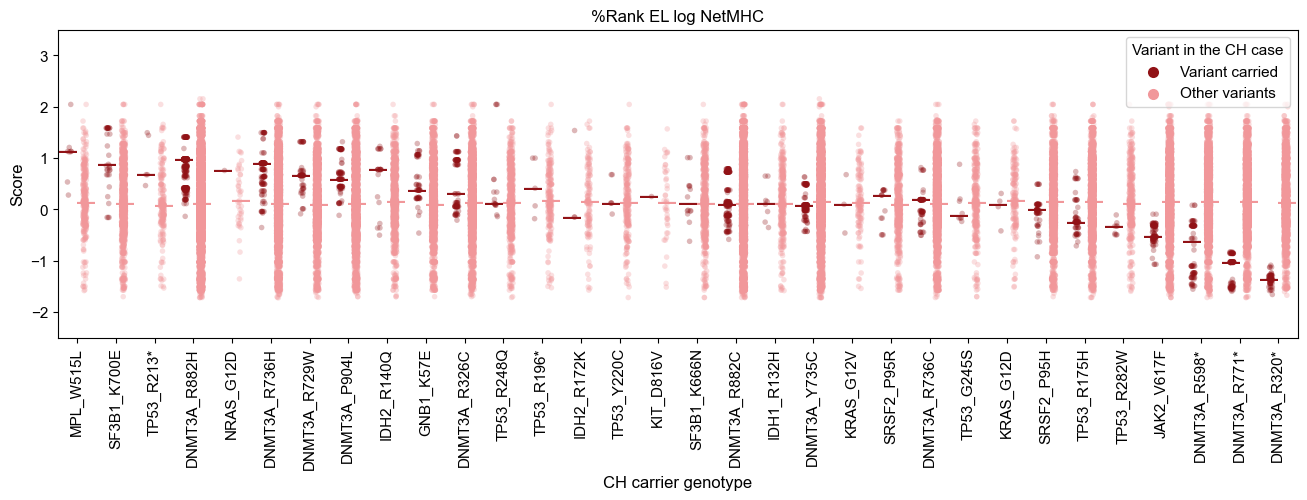

In [42]:

plot_scores_variant_carried_vs_other(ch_all_el_rank_log_melted_sort)

# Present vs absent variants 

In [43]:

# plot separately for each variant 

def plot_observed_vs_unobserved(data, x, y, xlabel, name, var, score, score_title):
    
    colors = ['#911216', '#f1979a']

    # BOXPLOT
    plt.figure(figsize=(4,4)) 
    p = sns.boxplot(x=x, y=y, data=data, hue=x, palette=colors, legend=False, showfliers = False)
    plt.title(f'{var}: {score_title}', fontsize = 14)
    plt.xlabel('Variant', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylim(-2.5, 3.5)
    
    # Mann-Whitney test (two groups, non-parametric)
    statistic, p_value = mannwhitneyu(data[data[x] == 'Present'][y], 
        data[data[x] == 'Absent'][y])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.93), xycoords='axes fraction', ha='center', va='center', fontsize=10)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_mutation_observed_vs_not_{name}_boxplot.pdf', bbox_inches='tight')

    # JITTER
    plt.figure(figsize=(4,4)) 
    p = sns.stripplot(x=x, y=y, data=data, hue=x, palette=colors, legend=False, dodge = False, size = 4, alpha = 0.3)
    plt.title(f'{var}: {score_title}', fontsize = 14)
    plt.xlabel('Variant', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-2.5, 3.5)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Mann-Whitney test (two groups, non-parametric)
    statistic, p_value = mannwhitneyu(data[data[x] == 'Present'][y], 
        data[data[x] == 'Absent'][y])
    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.93), xycoords='axes fraction', ha='center', va='center', fontsize=10)
    
    # add annotation to indicate median
    median_present = data[data[x] == 'Present'][y].median()
    median_absent = data[data[x] == 'Present'][y].median()
    plt.text(0, median_present, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#911216')
    plt.text(1, median_absent, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#f1979a')
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_mutation_observed_vs_not_{name}_boxplot.pdf', bbox_inches='tight')


# define function to plot across dataframes 
def observed_unobserved(df):

    score = df.score_type[0]
    score_title = score.replace('_', ' ')

    variants = []

    for var in variants:
        
        var_name = var.split('_')[0:2]
        var_name = ' '.join(var_name)

        data = df[df['variable'] == f'score_{var}'] # select entries with the variant 
        plot_observed_vs_unobserved(data, 'is_variant_present3', 'value', 'Mutation observed', 'score', var, var_name, score, score_title)

    # plot all variants together
    plot_observed_vs_unobserved(df, 'is_variant_present3', 'value', 'Mutation observed', 'all_32variants', 'All CH cases', score, score_title)
    

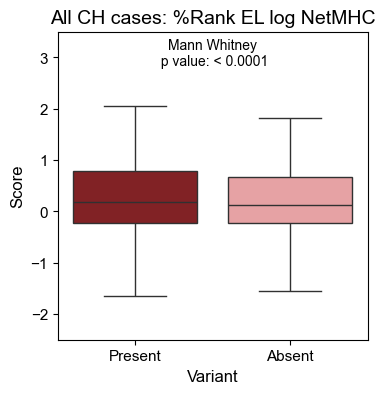

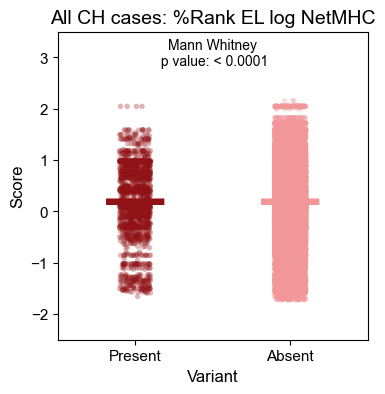

In [44]:

for name in df_names_melted_sorted:

    df = globals()[name] 
    df['is_variant_present3'] = df['is_variant_present'].map({True: 'Present', False: 'Absent'})
    observed_unobserved(df)
    

# VAF distribution comparison based on presentation

In [45]:

# OLD FUNCTIONS JUST IN CASE
def get_score(row):
    
    category = row['gene_var']
    return row[f'score_{category}']

# split by label 
def assign_labels(group):

    total_samples = group.shape[0]
    ordered_group = group.sort_values('score', ascending = True)
    # Assign "bottom" to the first half of the entries and "top" to the rest
    ordered_group['label'] = ['bottom half'] * (total_samples // 2) + ['top half'] * (total_samples - (total_samples // 2))
    
    return ordered_group

def calculate_groups3(group):
    group['group'] = pd.cut(group['score'], bins=3, labels=['bottom', 'middle', 'top'])
    return group

def calculate_groups4(group):
    group['group'] = pd.cut(group['score'], bins=4, labels=['bottom', 'mid-low', 'mid-high', 'top'])
    return group


In [46]:

# Okay, first, we need to get a score column so that will be a log score which matches the gene var someone has 
def get_score(row):
    
    category = row['gene_var']
    return row[f'score_{category}']

# split into a desired number of groups
def split_into_equal_groups(df, num_groups):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    df['rank'] = df['score'].rank(method='first', ascending=False)
    
    # assign groups based on rank 

    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    df_sort = df.sort_values(by = 'rank')
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    df_sort['group'] = group_assignments
    
    return df_sort

In [47]:

# assign labels using the function within each category
df_names_to_label = ['ch_all_ba_rank_log', 'ch_all_el_rank_log', 'ch_all_aff_log', 'prime_ch_all_el_rank_log']
dict_names_to_label = {}

for name in df_names_to_label:

    # get score for each dataframe
    df = globals()[name] 
    df['score'] = df.apply(get_score, axis = 1)

    # find median score for each variant 
    median_score = df.groupby('gene_var')['score'].transform('median')
    df['median_score_for_group'] = median_score

    # first, add an extra column, group ('top half', 'bottom halfs' for each variant)
    df['group_score'] = 'bottom half'  # everyone gets the low score

    # Note: TOP people will have a HIGHER score than median because we have done negative log transform 
    df.loc[df['score'] >= median_score, 'group_score'] = 'top half'  # top 50% presenters if index is higher than median 

    # make sure ordering is correct
    df['gene_var'] = df['gene_var'].astype('category') 

    # add labels
    df = df.groupby('gene_var', group_keys=False).apply(assign_labels)

    # add the df to the dictionary 
    key = f'df_labels_{name}'
    dict_names_to_label[key] = df

ch_all_aff_log_labels = dict_names_to_label['df_labels_ch_all_aff_log']
ch_all_ba_rank_log_labels = dict_names_to_label['df_labels_ch_all_ba_rank_log']
ch_all_el_rank_log_labels = dict_names_to_label['df_labels_ch_all_el_rank_log']
prime_ch_all_el_rank_log_labels = dict_names_to_label['df_labels_prime_ch_all_el_rank_log']


In [48]:

# define function to plot
def plot_ranks(data, x, y, hue, colors, order, plt_type, hue_order = None):

    score = data.score_type[0]
    score_title = score.replace('_', ' ')

    plt.figure(figsize = (12, 4))

    if hue_order is None:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.title(f'{y} distribution; split by {score_title}', y=1.02, fontsize = 14)
            plt.legend(title = 'Group', loc = 'upper right', fontsize = 11, title_fontsize = 11)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, size = 4, alpha = 0.6)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.title(f'{y} distribution; split by {score_title}', y=1.02, fontsize = 14)
            plt.legend(title = 'Group', markerscale = 2, loc = 'upper right', fontsize = 11, title_fontsize = 11)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')

    else:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order, hue_order=hue_order)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.title(f'{y} distribution; split by {score_title}', y=1.02, fontsize = 14)
            plt.legend(title = 'Group', loc = 'upper right', fontsize = 11, title_fontsize = 11)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, hue_order=hue_order, size = 4, alpha = 0.6)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.title(f'{y} distribution; split by {score_title}', y=1.02, fontsize = 14)
            plt.legend(title = 'Group', loc = 'upper right', markerscale = 2, fontsize = 11, title_fontsize = 11)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')


In [49]:
col0 = '#910e0e'
col1 = '#ed5d5d'
col1b = '#fab9b2'
col2 = '#65e6f5'
col3 = '#1091af'

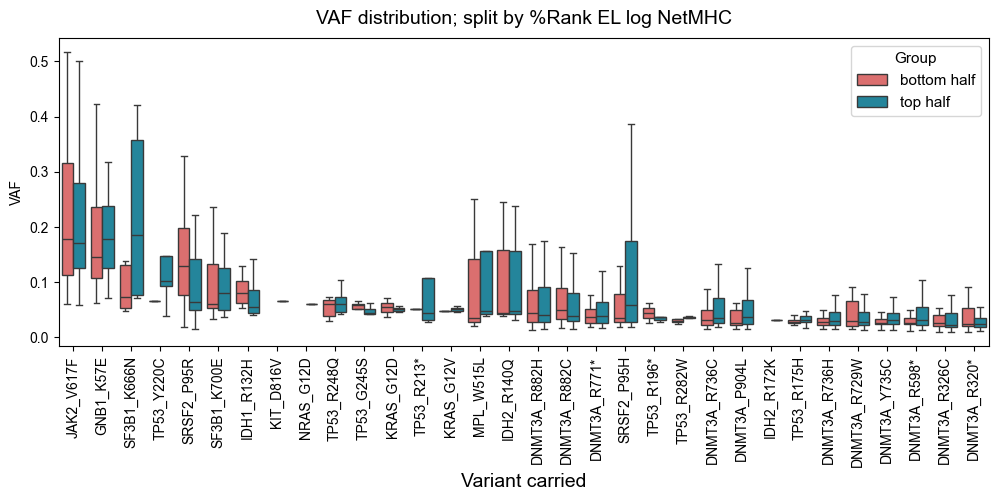

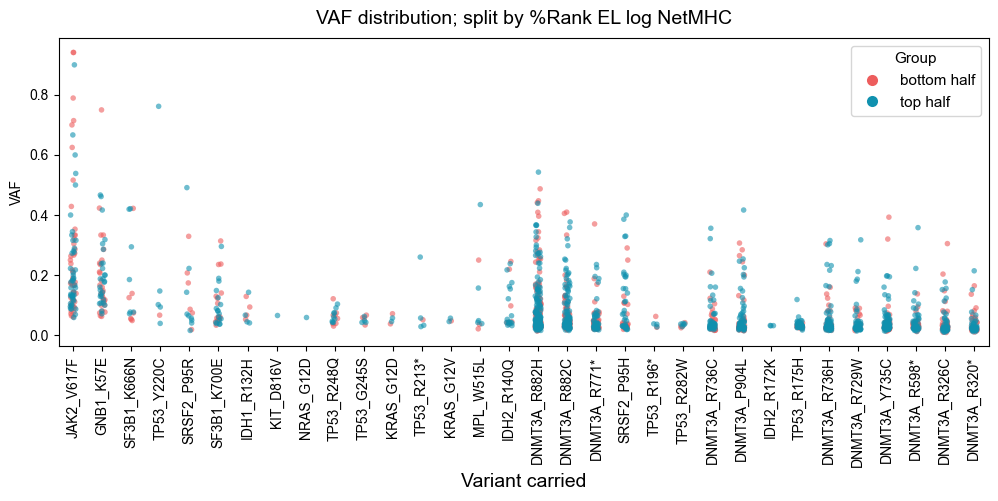

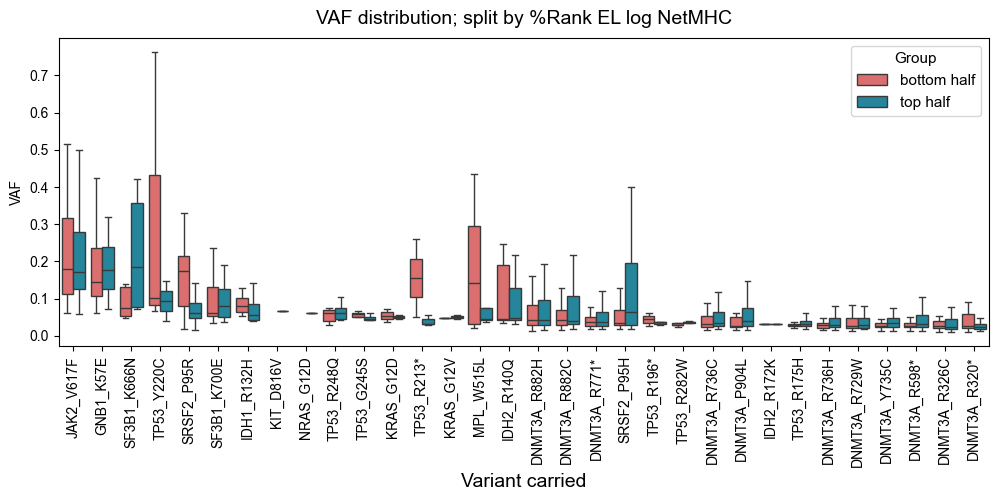

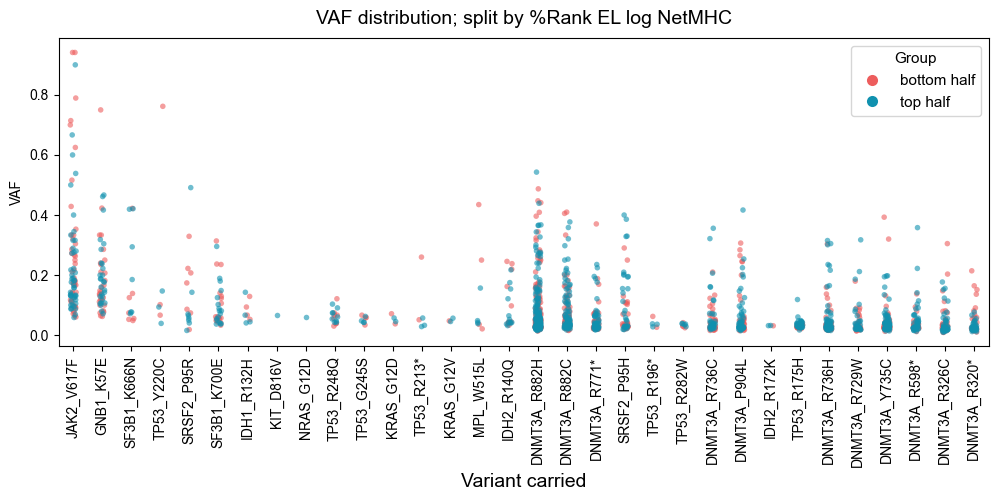

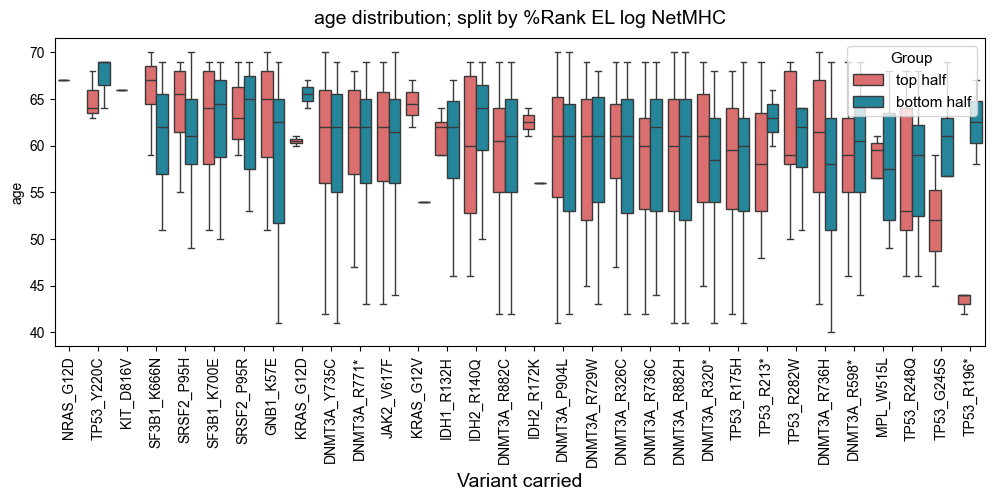

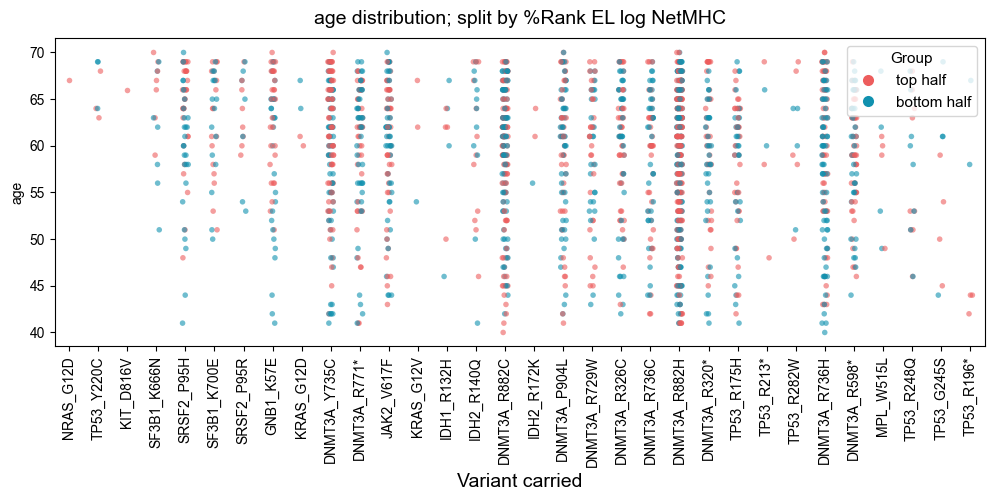

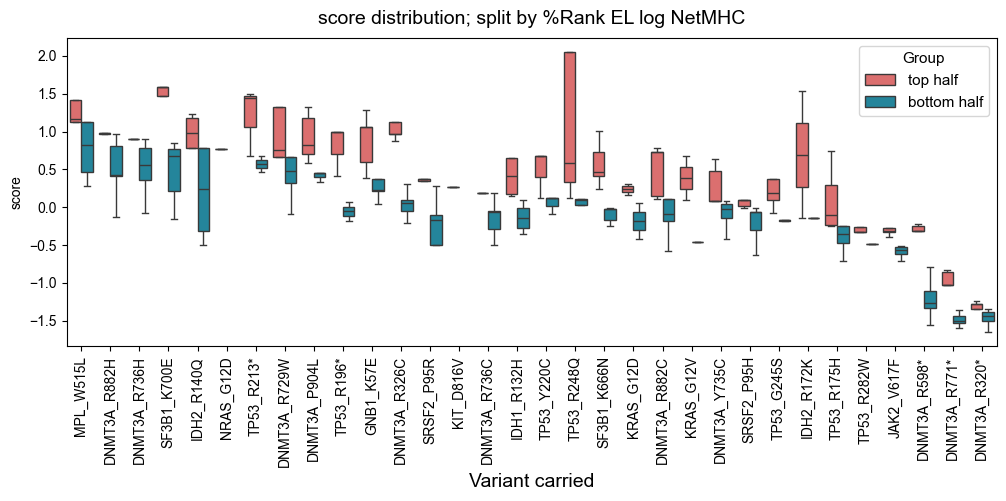

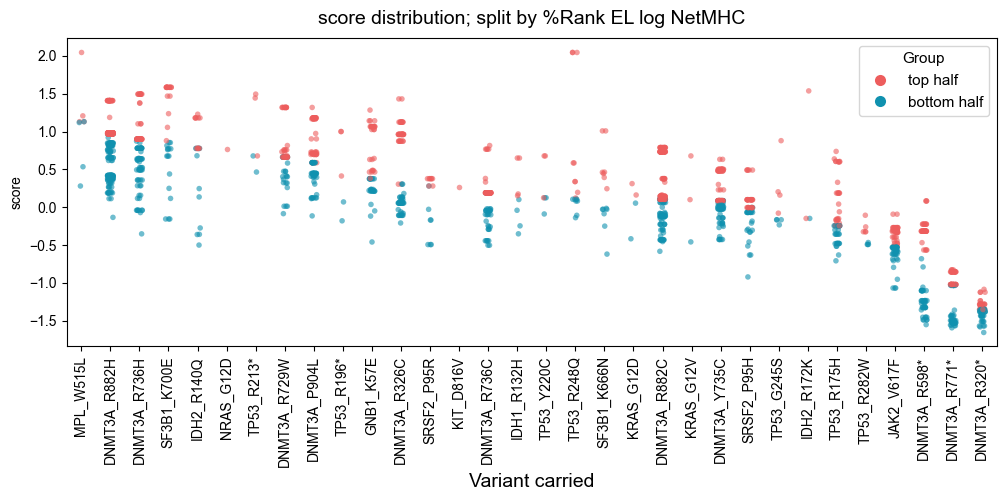

In [50]:

# okay now we need to add the variant depth and VAF to this dataframe
# df_names_to_label = ['ch_all_aff_log_labels', 'ch_all_ba_rank_log_labels', 'ch_all_el_rank_log_labels', 'prime_ch_all_el_rank_log_labels']
df_names_to_label = ['ch_all_el_rank_log_labels']

colors = [col1, col3]
plt.rcParams.update({'font.size': 10})

for name in df_names_to_label:

    df = globals()[name]
    
    df['median_vaf'] = df.groupby('gene_var')['VAF'].transform('median') # we are ordering by median so it may look a bit funny at times
    df_sort = df.sort_values(by = 'median_vaf', ascending = False)
    order = df_sort.gene_var.unique()
    
    plot_ranks(df, 'gene_var', 'VAF', 'group_score', colors, order, 'box')
    plot_ranks(df, 'gene_var', 'VAF', 'group_score', colors, order, 'jitter')
    plot_ranks(df, 'gene_var', 'VAF', 'label', colors, order, 'box')
    plot_ranks(df, 'gene_var', 'VAF', 'label', colors, order, 'jitter')

    df['median_age'] = df.groupby('gene_var')['age'].transform('median') # we are ordering by median so it may look a bit funny at times
    df_sort2 = df.sort_values(by = 'median_age', ascending = False)
    order2 = df_sort2.gene_var.unique()

    plot_ranks(df_sort2, 'gene_var', 'age', 'label', colors, order2, 'box')
    plot_ranks(df_sort2, 'gene_var', 'age', 'label', colors, order2, 'jitter')

    df['median_age'] = df.groupby('gene_var')['score'].transform('median') # we are ordering by median so it may look a bit funny at times
    df_sort3 = df.sort_values(by = 'median_age', ascending = False)
    order3 = df_sort3.gene_var.unique()
    plot_ranks(df_sort3, 'gene_var', 'score', 'label', colors, order3, 'box')
    plot_ranks(df_sort3, 'gene_var', 'score', 'label', colors, order3, 'jitter')


In [51]:

# define function to determine if a given case presents the variant well (top 50%)
def presents_variant(row, param):
    scores = {}
    if row[param] == 'top half': # indicates strong binding
       scores[f'presents_variant_{param}'] = True
    elif row[param] == 'top':
        scores[f'presents_variant_{param}'] = True
    else:
        scores[f'presents_variant_{param}'] = False
    return pd.Series(scores)

In [52]:

# define function to plot cumulative probability
def plot_cumulative(data, x, y, hue, colors, xlabel, ylabel, var, score, score_title, name):

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)

    plt.figure(figsize=(4,4)) 
    sns.lineplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = True)
    sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = False, alpha = 0.5, linewidth=0)

    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.title(f'Cumulative VAF distribution: {var_name},\n split by {score_title}', fontsize = 14)

    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    plt.legend(title = 'Variant presentation', loc = 'lower left')
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_VAF_{hue}_{name}_{score}_{var}.pdf', bbox_inches='tight')
    plt.close()

In [53]:


df_names_to_label = ['ch_all_aff_log_labels', 'ch_all_ba_rank_log_labels', 'ch_all_el_rank_log_labels', 'prime_ch_all_el_rank_log_labels']
df_names_to_label = ['ch_all_el_rank_log_labels']

colors = [col0, col3]

for name in df_names_to_label:
    df = globals()[name]

    score = df.score_type[0]
    score_title = score.replace('_', ' ')

    # add VAF_percent column
    df['VAF_percent'] = df['VAF'] * 100

    
    # compare VAF distribution for each variant separately
    variants = df['gene_var'].unique()
    
    for var in variants: 

        data = df[df['gene_var'] == var]
        data = data.sort_values(by='VAF')
        
        N = data.shape[0]

        if N < 20:
            pass

        else:
            # split into equal groups (label)
            N_presents_label = data[data['label'] == 'top half'].shape[0]
            N_notpresents_label = N - N_presents_label
            
            # split by median rank
            N_presents_group = data[data['group_score'] == 'top half'].shape[0]
            N_notpresents_group = N - N_presents_group
            
            # print('label sizes:', N_presents_label, N_notpresents_label)
            # print('group sizes:', N_presents_group, N_notpresents_group)

            data = pd.concat([data, data.apply(presents_variant, axis=1, param = 'label')], axis=1)
            data = pd.concat([data, data.apply(presents_variant, axis=1, param = 'group_score')], axis=1)

            data['index_vaf_label'] = data.groupby('presents_variant_label')['VAF'].rank(ascending=False) # index by VAF
            data['fraction_index_presenter_label'] = data.apply(lambda row: row['index_vaf_label'] / N_presents_label if row['presents_variant_label'] else row['index_vaf_label'] / N_notpresents_label, axis=1)

            data['index_vaf_group'] = data.groupby('presents_variant_group_score')['VAF'].rank(ascending=False) # index by VAF
            data['fraction_index_presenter_group'] = data.apply(lambda row: row['index_vaf_group'] / N_presents_group if row['presents_variant_group_score'] else row['index_vaf_group'] / N_notpresents_group, axis=1)

            data['presents_variant_label2'] = data['presents_variant_label'].map({True: 'top half', False: 'bottom half'})
            data['presents_variant_group_score2'] = data['presents_variant_group_score'].map({True: 'top half scores', False: 'bottom half scores'})
    
            plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_label', 'presents_variant_label2', colors, 'VAF (%)', 'Cumulative probability', var, score, score_title, '2groups')
            plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group', 'presents_variant_group_score2', colors, 'VAF (%)', 'Cumulative probability', var, score, score_title, '2groups')

            # data_all = pd.concat([data_all, data], ignore_index = True)

    # compare VAF distribution across all variants (aggregate)
    df = df.sort_values(by='VAF')

    N = df.shape[0]
    N_presents_label = df[df['label'] == 'top half'].shape[0]
    N_notpresents_label = N - N_presents_label

    N_presents_group = df[df['group_score'] == 'top half'].shape[0]
    N_notpresents_group = N - N_presents_group

    df = pd.concat([df, df.apply(presents_variant, axis=1, param = 'label')], axis=1)
    df = pd.concat([df, df.apply(presents_variant, axis=1, param = 'group_score')], axis=1)

    df['index_vaf_label'] = df.groupby('presents_variant_label')['VAF'].rank(ascending=False) # index by VAF
    df['fraction_index_presenter_label'] = df.apply(lambda row: row['index_vaf_label'] / N_presents_label if row['presents_variant_label'] else row['index_vaf_label'] / N_notpresents_label, axis=1)

    df['index_vaf_group'] = df.groupby('presents_variant_group_score')['VAF'].rank(ascending=False) # index by VAF
    df['fraction_index_presenter_group'] = df.apply(lambda row: row['index_vaf_group'] / N_presents_group if row['presents_variant_group_score'] else row['index_vaf_group'] / N_notpresents_group, axis=1)
    
    df['presents_variant_label2'] = df['presents_variant_label'].map({True: 'top half', False: 'bottom half'})
    df['presents_variant_group_score2'] = df['presents_variant_group_score'].map({True: 'top half scores', False: 'bottom half scores'})
    
    plot_cumulative(df, 'VAF_percent', 'fraction_index_presenter_label', 'presents_variant_label2', colors, 'VAF (%)', 'Cumulative probability', var, score, score_title, '2groups')        
    plot_cumulative(df, 'VAF_percent', 'fraction_index_presenter_group', 'presents_variant_group_score2', colors, 'VAF (%)', 'Cumulative probability', 'all_variants', score, score_title, '2groups')

# Explore extent of effect as distance between groups increases

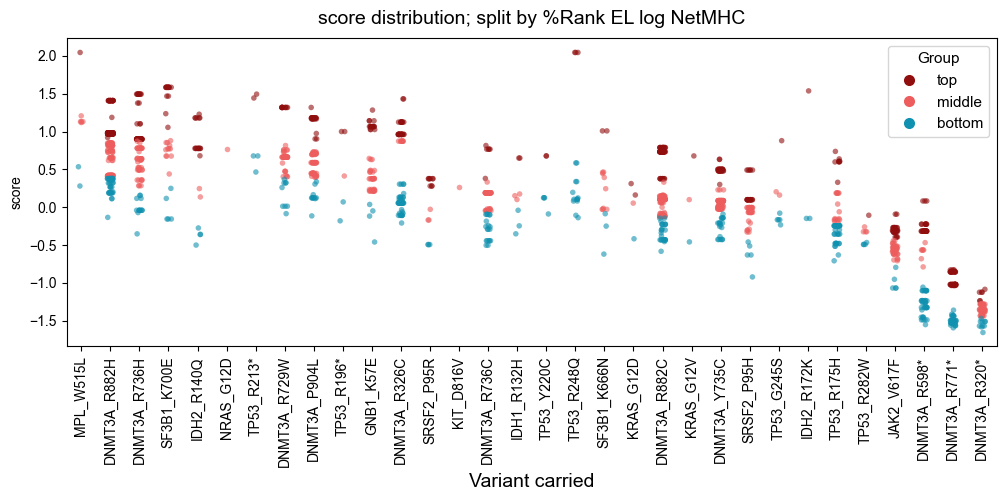

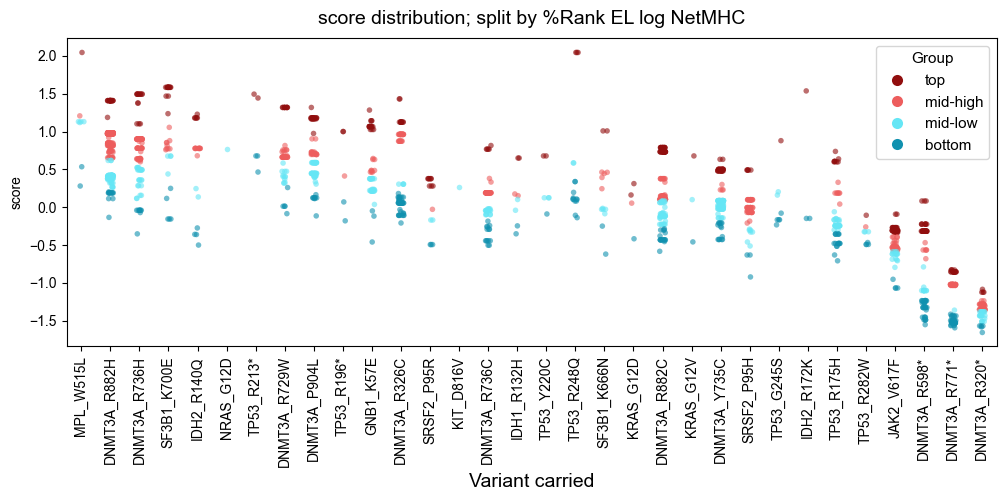

In [54]:

# df_names_to_label = ['ch_all_aff_log_labels', 'ch_all_ba_rank_log_labels', 'ch_all_el_rank_log_labels', 'prime_ch_all_el_rank_log_labels']
df_names_to_label = ['ch_all_el_rank_log_labels']

for name in df_names_to_label:

    df = globals()[name]
    
    # apply function separately to each category 
    df_groups3 = df.groupby('gene_var').apply(calculate_groups3)
    df_groups4 = df.groupby('gene_var').apply(calculate_groups4)

    colors1 = [col0, col1, col3]
    hue_order1 = ['top','middle', 'bottom']
    scores_groups3 = df_groups3.sort_values(by = 'score', ascending = False)
    plot_ranks(scores_groups3, 'gene_var', 'score', 'group', colors1, order_by_mean_log, 'jitter', hue_order1)

    colors2 = [col0, col1, col2, col3]
    hue_order2 = ['top','mid-high', 'mid-low', 'bottom']
    scores_groups4 = df_groups4.sort_values(by = 'score', ascending = False)
    plot_ranks(scores_groups4, 'gene_var', 'score', 'group', colors2, order_by_mean_log, 'jitter', hue_order2)



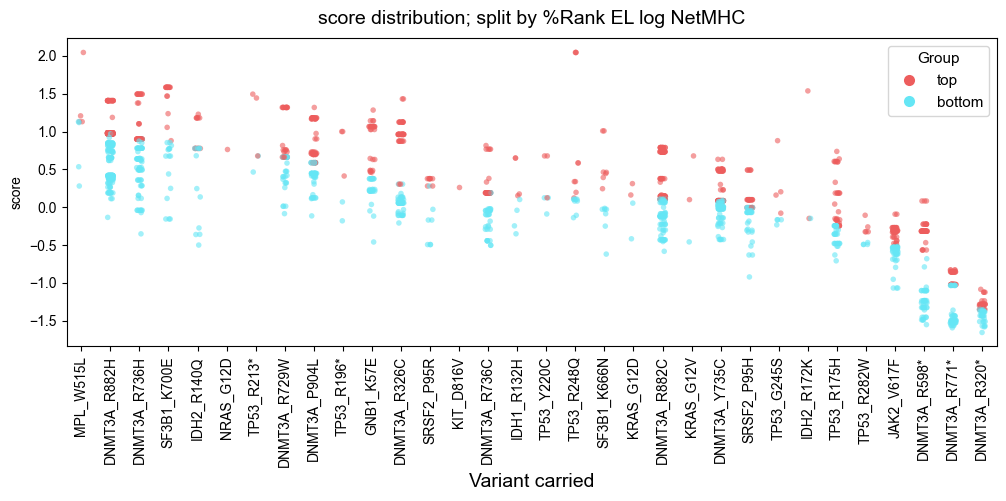

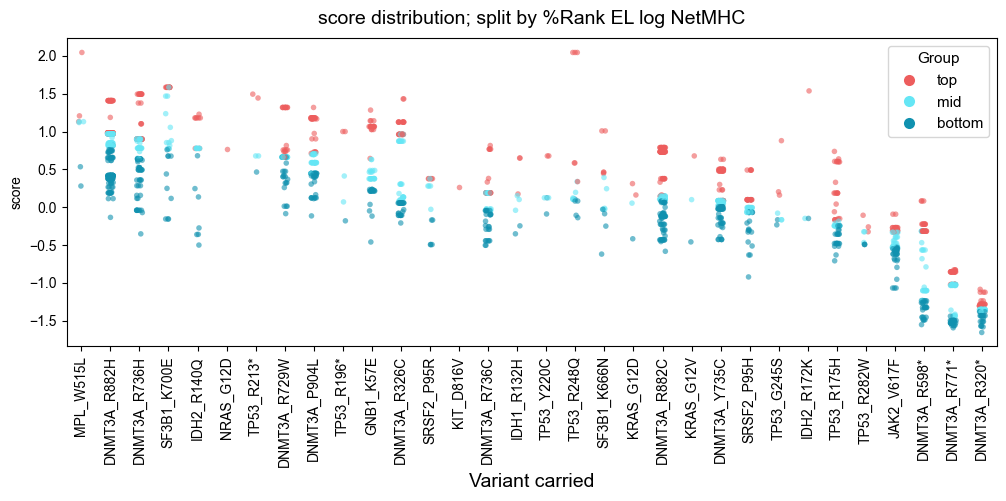

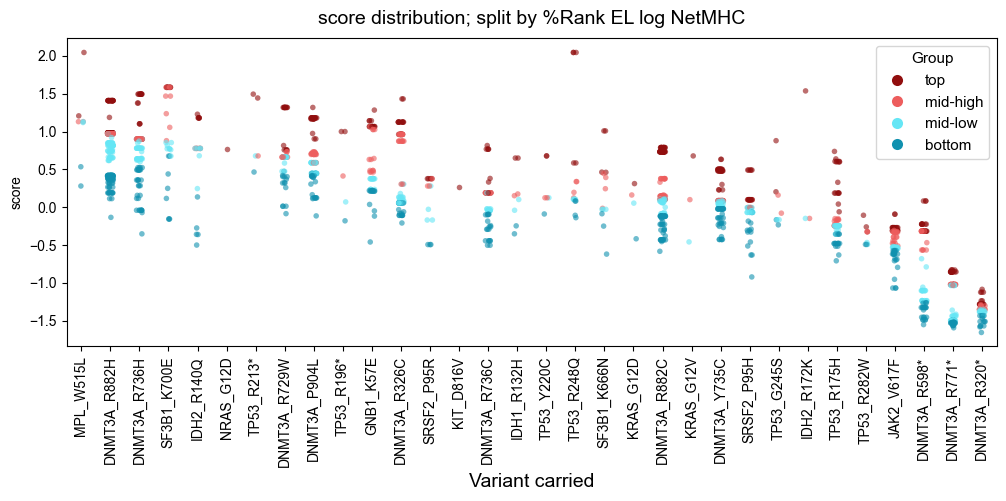

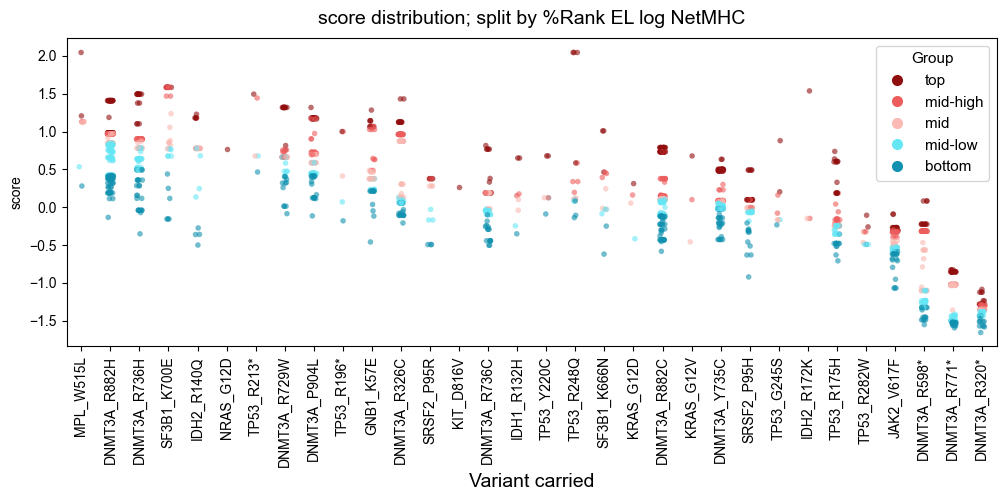

In [55]:

# split df into equal groups

# df_names_to_label = ['ch_all_aff_log_labels', 'ch_all_ba_rank_log_labels', 'ch_all_el_rank_log_labels', 'prime_ch_all_el_rank_log_labels']
df_names_to_label = ['ch_all_el_rank_log_labels']

for name in df_names_to_label:

    df = globals()[name]
    
    # apply function separately to each category 
    df_groups2_eqsize = df.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=2))
    df_groups3_eqsize = df.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=3))
    df_groups4_eqsize = df.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=4))
    df_groups5_eqsize = df.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=5))

    # add a more descriptive name for the group
    df_groups2_eqsize['group_name'] =  df_groups2_eqsize['group'].map({1: 'top', 2: 'bottom'})
    df_groups3_eqsize['group_name'] =  df_groups3_eqsize['group'].map({1: 'top', 2: 'mid', 3: 'bottom'})
    df_groups4_eqsize['group_name'] =  df_groups4_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid-low', 4: 'bottom'})
    df_groups5_eqsize['group_name'] =  df_groups5_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid', 4: 'mid-low', 5: 'bottom'})

    colors2 = [col1, col2]
    hue_order2 = ['top', 'bottom']
    scores_groups2_eqsize = df_groups2_eqsize.sort_values(by = 'score', ascending = False)
    plot_ranks(scores_groups2_eqsize, 'gene_var', 'score', 'group_name', colors2, order_by_mean_log, 'jitter', hue_order2)

    colors3 = [col1, col2, col3]
    hue_order3 = ['top','mid', 'bottom']
    scores_groups3_eqsize = df_groups3_eqsize.sort_values(by = 'score', ascending = False)
    plot_ranks(scores_groups3_eqsize, 'gene_var', 'score', 'group_name', colors3, order_by_mean_log, 'jitter', hue_order3)

    colors4 = [col0, col1, col2, col3]
    hue_order4 = ['top','mid-high', 'mid-low', 'bottom']
    scores_groups4_eqsize = df_groups4_eqsize.sort_values(by = 'score', ascending = False)
    plot_ranks(scores_groups4_eqsize, 'gene_var', 'score', 'group_name', colors4, order_by_mean_log, 'jitter', hue_order4)

    colors5 = [col0, col1, col1b, col2, col3]
    hue_order5 = ['top', 'mid-high', 'mid', 'mid-low', 'bottom']
    scores_groups5_eqsize = df_groups5_eqsize.sort_values(by = 'score', ascending = False)
    plot_ranks(scores_groups5_eqsize, 'gene_var', 'score', 'group_name', colors5, order_by_mean_log, 'jitter', hue_order5)

In [56]:

# for extreme groups in each split 
colors = [col0, col3]

dfs_list = ['df_groups2_eqsize','df_groups3_eqsize', 'df_groups4_eqsize', 'df_groups5_eqsize']

for name in dfs_list:

    df = globals()[name]

    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    nr_groups = re.search(r'\d', name).group() # find the digit in the df name 

    # look only at top and bottom groups
    groups_to_sel = ['top', 'bottom']
    df_sel = df[df['group_name'].isin(groups_to_sel)]
    
    variants = df_sel['gene_var'].unique()

    for var in variants: 

        data = df_sel[df_sel['gene_var'] == var]
        data = data.sort_values(by='VAF')
        
        N = data.shape[0]

        if N < 20:
            pass

        else:
            # split into equal groups (label)
            N_presents = data[data['group_name'] == 'top'].shape[0] # top quarter
            N_notpresents = data[data['group_name'] == 'bottom'].shape[0] # bottom quarter
            
            data = pd.concat([data, data.apply(presents_variant, axis=1, param = 'group_score')], axis=1)
            data['index_vaf_group'] = data.groupby('presents_variant_group_score')['VAF'].rank(ascending=False) # index by VAF
            data['fraction_index_presenter_group'] = data.apply(lambda row: row['index_vaf_group'] / N_presents if row['presents_variant_group_score'] else row['index_vaf_group'] / N_notpresents, axis=1)
            data[f'presents_variant_group_score_{nr_groups}'] = data['presents_variant_group_score'].map({True: f'top 1/{nr_groups} scores', False: f'bottom 1/{nr_groups} scores'})
    
            plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group', f'presents_variant_group_score_{nr_groups}', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', var, score, score_title, f'{nr_groups}_groups_eqsize_maxmin')

    # plot aggregate for all variants
    df_sel = df_sel.sort_values(by='VAF')

    N = df_sel.shape[0]
    
    N_presents = df_sel[df_sel['group_name'] == 'top'].shape[0]
    N_notpresents = df_sel[df_sel['group_name'] == 'bottom'].shape[0]

    df_sel = pd.concat([df_sel, df_sel.apply(presents_variant, axis=1, param = 'group_score')], axis=1)
    df_sel['index_vaf_group'] = df_sel.groupby('presents_variant_group_score')['VAF'].rank(ascending=False) # index by VAF
    df_sel['fraction_index_presenter_group'] = df_sel.apply(lambda row: row['index_vaf_group'] / N_presents_group if row['presents_variant_group_score'] else row['index_vaf_group'] / N_notpresents_group, axis=1)
    df_sel[f'presents_variant_group_score_{nr_groups}'] = df_sel['presents_variant_group_score'].map({True: f'top 1/{nr_groups} scores', False: f'bottom 1/{nr_groups} scores'})
    
    plot_cumulative(df_sel, 'VAF_percent', 'fraction_index_presenter_group', f'presents_variant_group_score_{nr_groups}', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', 'all_variants', score, score_title, f'{nr_groups}_groups_eqsize_maxmin') 

In [57]:

# now we switch this a little bit and plot all categories on one plot 

# for extreme groups in each split 
dfs_list = ['df_groups2_eqsize', 'df_groups3_eqsize', 'df_groups4_eqsize', 'df_groups5_eqsize']

for name in dfs_list:

    df = globals()[name]

    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    nr_groups = re.search(r'\d', name).group() # find the digit in the df name 

    # specify the colors 
    if nr_groups == '2':
        colors = [col1, col2]
    elif nr_groups == '3':
        colors = [col1, col2, col3]
    elif nr_groups == '4':
        colors = [col0, col1, col2, col3] 
    elif nr_groups == '5':
        colors = [col0, col1, col1b, col2, col3]

    variants = df['gene_var'].unique()

    # plot for each variant separately 
    for var in variants: 

        data = df[df['gene_var'] == var]
        data = data.sort_values(by='VAF')
        
        N = data.shape[0]

        if N < 20:
            pass

        else:
            # add number of people in each category 
            data['group_size'] = data.groupby('group')['group'].transform('count')
            data['index_vaf_group'] = data.groupby('group')['VAF'].rank(ascending=False) # index by VAF
            data['fraction_index_presenter_group'] = data['index_vaf_group'] / data['group_size']
            
            plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group', f'group', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', var, score, score_title, f'{nr_groups}_groups_eqsize_allon1')

    # plot aggregate for all variants
    df = df.sort_values(by='VAF')

    df['group_size'] = df.groupby('group')['group'].transform('count')
    df['index_vaf_group'] = df.groupby('group')['VAF'].rank(ascending=False) # index by VAF
    df['fraction_index_presenter_group'] = df['index_vaf_group'] / df['group_size']
    
    plot_cumulative(df, 'VAF_percent', 'fraction_index_presenter_group', f'group', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', 'all_variants', score, score_title, f'{nr_groups}_groups_eqsize_allon1') 

In [62]:

# now, divide everyone into binds strongly / weakly / does not bind based on score (< 0.5, < 2, > 2)
# thresholds are max 0.5 (for strong binding) and 2 (for weak binding)
threshold_strong = -1 * np.log10(0.5)
threshold_weak = -1 * np.log10(2)

conditions2 = [
    (df_groups5_eqsize['score'] > threshold_weak), # any binding (Jamie says they're getting binding with these)
    (df_groups5_eqsize['score'] <= threshold_weak) # no binding 
]
values2 = ['binding', 'no binding']
df_groups5_eqsize['binding_level2'] = np.select(conditions2, values2, default='unknown')

conditions3 = [
    (df_groups5_eqsize['score'] > threshold_strong),
    (df_groups5_eqsize['score'] > threshold_weak),
    (df_groups5_eqsize['score'] <= threshold_weak)
]
values3 = ['strong binding', 'weak binding', 'no binding']
df_groups5_eqsize['binding_level3'] = np.select(conditions3, values3, default='unknown')

# nb the scores are the same everywhere so it does not really matter on which dataframe you do it 


In [66]:

# okay no split based on threshold and plot for each variant and aggregate 

# now we switch this a little bit and plot all categories on one plot 

# for extreme groups in each split 

score = df_groups5_eqsize.score_type[0]
score_title = score.replace('_', ' ')

# specify the colors (not sure if I should use different ones given I have threshold stuff?)
variants = df_groups5_eqsize['gene_var'].unique()

# plot for each variant separately 
for var in variants: 

    data = df_groups5_eqsize[df_groups5_eqsize['gene_var'] == var]
    data = data.sort_values(by='VAF')
    
    # ignore cases where you have less than 5 cases in either category 
    if (data[data['binding_level2'] == 'binding'].shape[0] < 5 or data[data['binding_level2'] == 'no binding'].shape[0] < 5):
        pass

    else:
        # add number of people in each category 
        colors = [col0, col3]
        data['group_size_bind2'] = data.groupby('binding_level2')['binding_level2'].transform('count')
        data['index_vaf_group2'] = data.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group_bind2'] = data['index_vaf_group2'] / data['group_size_bind2']
        plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', var, score, score_title, f'{nr_groups}_groups_binding_2thresh')

    if (data[data['binding_level3'] == 'strong binding'].shape[0] < 5 or data[data['binding_level3'] == 'weak binding'].shape[0] < 5 or data[data['binding_level3'] == 'no binding'].shape[0] < 5):
        pass

    else:
        # add number of people in each category 
        colors = [col0, col1b, col3]
        data['group_size_bind3'] = data.groupby('binding_level3')['binding_level3'].transform('count')
        data['index_vaf_group3'] = data.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group_bind3'] = data['index_vaf_group3'] / data['group_size_bind3']
        plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', var, score, score_title, f'{nr_groups}_groups_binding_3thresh')


# plot aggregate for all variants
df_groups5_eqsize = df_groups5_eqsize.sort_values(by='VAF')
df_groups5_eqsize['index_vaf_group2'] = df_groups5_eqsize.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize['index_vaf_group3'] = df_groups5_eqsize.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize['group_size_bind2'] = df_groups5_eqsize.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize['group_size_bind3'] = df_groups5_eqsize.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize['fraction_index_presenter_group_bind2'] = df_groups5_eqsize['index_vaf_group2'] / df_groups5_eqsize['group_size_bind2']
df_groups5_eqsize['fraction_index_presenter_group_bind3'] = df_groups5_eqsize['index_vaf_group3'] / df_groups5_eqsize['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'all_variants', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'all_variants', score, score_title, f'{nr_groups}_groups_binding_3thresh') 

# okay so doing this by variant is a joke given how few cases with each variant across binding thresholds we are going to have
# BUT what I think would make sense is to divide up into substitutions (immunogenic) and stops (not immunogenic)
# BUT the problem with aggregation is that again, it may be that stuff that is not immunogenic reaches higher VAFs (higher intrinsic fitness variant etc etc.)

# STOP codons (expect no difference)
variants = set(df_groups5_eqsize.gene_var.tolist())
stops = ['DNMT3A_R320*', 'DNMT3A_R598*', 'DNMT3A_R771*','TP53_R213*', 'TP53_R196*']
subs = [var for var in variants if var not in stops]

# select for STOP codons
df_groups5_eqsize_stop = df_groups5_eqsize[df_groups5_eqsize.gene_var.isin(stops)]
df_groups5_eqsize_stop = df_groups5_eqsize_stop.sort_values(by='VAF')
df_groups5_eqsize_stop['index_vaf_group2'] = df_groups5_eqsize_stop.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_stop['index_vaf_group3'] = df_groups5_eqsize_stop.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_stop['group_size_bind2'] = df_groups5_eqsize_stop.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize_stop['group_size_bind3'] = df_groups5_eqsize_stop.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize_stop['fraction_index_presenter_group_bind2'] = df_groups5_eqsize_stop['index_vaf_group2'] / df_groups5_eqsize_stop['group_size_bind2']
df_groups5_eqsize_stop['fraction_index_presenter_group_bind3'] = df_groups5_eqsize_stop['index_vaf_group3'] / df_groups5_eqsize_stop['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize_stop, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'stop_variants', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize_stop, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'stop_variants', score, score_title, f'{nr_groups}_groups_binding_3thresh') 

# select for substitutions
df_groups5_eqsize_sub = df_groups5_eqsize[df_groups5_eqsize.gene_var.isin(subs)]
df_groups5_eqsize_sub = df_groups5_eqsize_sub.sort_values(by='VAF')
df_groups5_eqsize_sub['index_vaf_group2'] = df_groups5_eqsize_sub.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub['index_vaf_group3'] = df_groups5_eqsize_sub.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub['group_size_bind2'] = df_groups5_eqsize_sub.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize_sub['group_size_bind3'] = df_groups5_eqsize_sub.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize_sub['fraction_index_presenter_group_bind2'] = df_groups5_eqsize_sub['index_vaf_group2'] / df_groups5_eqsize_sub['group_size_bind2']
df_groups5_eqsize_sub['fraction_index_presenter_group_bind3'] = df_groups5_eqsize_sub['index_vaf_group3'] / df_groups5_eqsize_sub['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize_sub, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'sub_variants', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize_sub, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'sub_variants', score, score_title, f'{nr_groups}_groups_binding_3thresh') 

# what if we remove JAK2 from this 
# I would 100% conclude this is driven by JAK2 > don't do the same mistake that the cell people did!!!
subs_njk = [var for var in subs if var != 'JAK2_V617F']
df_groups5_eqsize_sub_njk = df_groups5_eqsize[df_groups5_eqsize.gene_var.isin(subs_njk)]
df_groups5_eqsize_sub_njk = df_groups5_eqsize_sub_njk.sort_values(by='VAF')
df_groups5_eqsize_sub_njk['index_vaf_group2'] = df_groups5_eqsize_sub_njk.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub_njk['index_vaf_group3'] = df_groups5_eqsize_sub_njk.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub_njk['group_size_bind2'] = df_groups5_eqsize_sub_njk.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize_sub_njk['group_size_bind3'] = df_groups5_eqsize_sub_njk.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize_sub_njk['fraction_index_presenter_group_bind2'] = df_groups5_eqsize_sub_njk['index_vaf_group2'] / df_groups5_eqsize_sub_njk['group_size_bind2']
df_groups5_eqsize_sub_njk['fraction_index_presenter_group_bind3'] = df_groups5_eqsize_sub_njk['index_vaf_group3'] / df_groups5_eqsize_sub_njk['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize_sub_njk, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'sub without JAK2', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize_sub_njk, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'sub without JAK2', score, score_title, f'{nr_groups}_groups_binding_3thresh') 


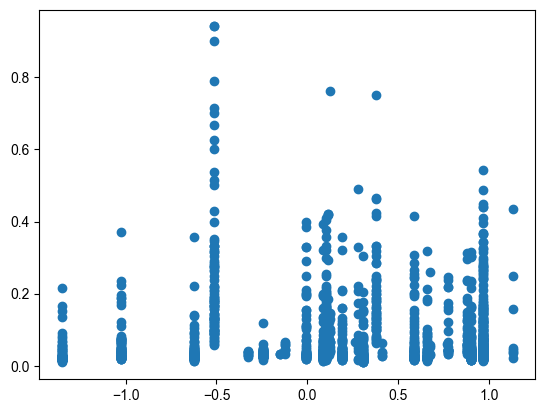

In [67]:

# NOTE THIS IS REALLY IMPORTANT BC I THINK AGAIN, AGGREGATION CAN LEAD TO ARTEFACTS HERE 
# BUT the problem with aggregation is that again, it may be that stuff that is not immunogenic reaches higher VAFs (higher intrinsic fitness variant etc etc.)
# can we just quickly do some sort of correlation of median score with VAF?
df_small = df_groups5_eqsize[['score', 'VAF']]
df_small['median_score'] = df_small.groupby('gene_var')['score'].transform('median')
df_small

plt.scatter(df_small['median_score'], df_small['VAF'])

# Compare to randomly selected reference datasets 

In [68]:

# we can add scores to EVERYONE we have HLA genotype for in the UKBB data (this is the df_hla dataset)

# cases who have CH with a genotyped variant (from one of the ones we were looking at) are in batch_gene_vars 

ch_sampleids = batch_gene_vars['Person_ID']
ukbb_no_ch = df_clean_hla1[~df_clean_hla1['Person_ID'].isin(ch_sampleids)]
hla_ukbb = ukbb_no_ch.filter(regex='\d').columns # identify HLA alleles carried by non-CH-individuals in the UKBB data

# prepare dataset with predictions (now just from NetMHC)
scores_netmhc_elrank = scores_netmhc[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
scores_netmhc_elrank_wide = pd.pivot(scores_netmhc_elrank, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')

hla_intersect = scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.isin(hla_ukbb)]
hla_intersect_list = hla_intersect.tolist() # select predictions for alleles which are available in NetMHC / PRIME

pred_sub_wide = scores_netmhc_elrank_wide[hla_intersect_list + scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.str.contains('gene_var_gt')].tolist()]

ukbb_no_ch_hla = ukbb_no_ch[hla_intersect]
ukbb_no_ch = pd.concat([ukbb_no_ch['Person_ID'], ukbb_no_ch_hla], axis = 1)
ukbb_no_ch.head()

ids_non_carriers_healthy = ukbb_no_ch.Person_ID.unique().tolist()
print('Number of healthy (non-CH) individuals examined:', len(ids_non_carriers_healthy))

# okay so now we have a dataset for everyone who does NOT have CH
# and for all of them, we have their alleles for which we can make predictions

# I am stupid and I can't move the index to the column so sorry but I will just a new column
pred_sub_wide['gene_var_gt'] = pred_sub_wide.index

Number of healthy (non-CH) individuals examined: 441608


In [69]:

# define new functions in case you want to get predictions for both CH and refseq

def find_best_score_for_all_variants_ref_ch(row, df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries
   
    # it may be that we don't have this column in case we are doing this for non-CH cases
   
    variants = df['gene_var_gt'] # get out variants which are present 
   
    scores = {} # initialise empy dictionaries

    # depending on the parameter, pick the minimum of maximum value 
    if param == "Aff_nM":
        for var in variants:
            # Find the minimum value for each variant in the category that is present
            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            # Update the dictionary with the minimum value for the corresponding variant
            scores[f'score_{var}'] = best_value
        return pd.Series(scores)

    elif param == "Score_BA":
        for var in variants:
            
            best_value = max(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value
        
        return pd.Series(scores)

    elif param == "Score_EL":
        for var in variants:
           
            best_value = max(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_EL":
        for var in variants:
            
            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


def find_best_score_all_variants_log_ref_ch(row, df, param):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries

    variants = df['gene_var_gt']
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":
        for var in variants:

            # take maximum of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            # take maxium of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "Aff_nM":
        for var in variants:

            # take maxium of the negative log score (low aff = more immunogenic)
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


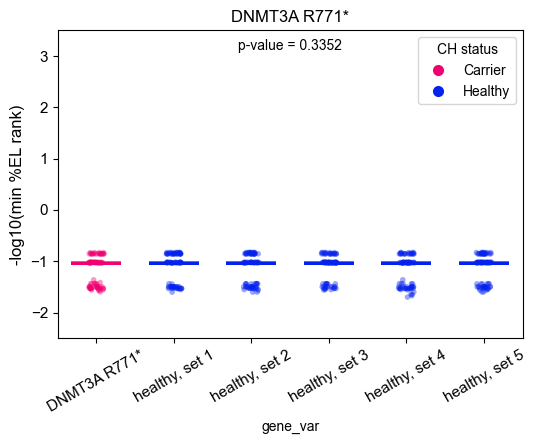

In [70]:

# full script to look across variants  

np.random.seed(10) # ensure this is all reproducible 

# specify list of variants to look at 
variants = batch_gene_vars.gene_var.unique()
colors = ['#f00071', '#0422ed']
cols_ch = ['Person_ID', 'gene_var', 'score']

variants = ['DNMT3A_R771*']
for var in variants:

    var_name = var.replace('_', ' ')
    
    # we will compare to %Rank EL (log) derived from NetMHC now
    ch_scores = ch_all_el_rank_log_labels[ch_all_el_rank_log_labels['gene_var'] == var]
    ch_scores = ch_scores[cols_ch]

    cols_no_ch = ['Person_ID', 'gene_var', f'score_{var}_ch']

    # get 5 random sets 
    sets_to_compare = {}

    n =  ch_scores.shape[0]

    if n > 20:

        for i in range(5):
            set = ukbb_no_ch.sample(n=n, replace=False)  # no duplicates
            sets_to_compare[i] = set

        set1, set2, set3, set4, set5 = sets_to_compare.values()

        # specify parameter 
        param = '%Rank_EL'

        # add scores 
        set1_scores = pd.concat([set1, set1.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        set2_scores = pd.concat([set2, set2.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        set3_scores = pd.concat([set3, set3.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        set4_scores = pd.concat([set4, set4.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        set5_scores = pd.concat([set5, set5.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)

        # add label to be able to melt the columns 
        set1_scores['gene_var'] = 'healthy, set 1'
        set2_scores['gene_var'] = 'healthy, set 2'
        set3_scores['gene_var'] = 'healthy, set 3'
        set4_scores['gene_var'] = 'healthy, set 4'
        set5_scores['gene_var'] = 'healthy, set 5'

        set1_scores_var = set1_scores[cols_no_ch]
        set2_scores_var = set2_scores[cols_no_ch]
        set3_scores_var = set3_scores[cols_no_ch]
        set4_scores_var = set4_scores[cols_no_ch]
        set5_scores_var = set5_scores[cols_no_ch]

        scores_ref = pd.concat([set1_scores_var, 
            set2_scores_var, set3_scores_var, set4_scores_var, set5_scores_var])
        
        # adjust column names
        scores_ref = scores_ref.rename(columns={f'score_{var}_ch': 'score'}) 

        # concatenate all dataframes
        scores_compare_all = pd.concat([ch_scores, scores_ref])
        # add color to indicate these people do not carry CH
        scores_compare_all["CH_variant_carrier"] = scores_compare_all['gene_var'] == var 
        scores_compare_all["CH_variant_carrier"] = scores_compare_all["CH_variant_carrier"].map({True: 'Carrier', False: 'Healthy'})

        # add p value 
        scores_ch = ch_scores.score.tolist()
        scores_h1 = set1_scores[f'score_{var}_ch'].tolist()
        scores_h2 = set2_scores[f'score_{var}_ch'].tolist()
        scores_h3 = set3_scores[f'score_{var}_ch'].tolist()
        scores_h4 = set4_scores[f'score_{var}_ch'].tolist()
        scores_h5 = set5_scores[f'score_{var}_ch'].tolist()

        H, p_value = kruskal(scores_ch, scores_h1, scores_h2, scores_h3, scores_h4, scores_h5)

        # boxplot 
        xaxis_labels = scores_compare_all.gene_var.str.replace('_', ' ')
        # plt.figure(figsize=(6,4)) # set figure size
        # sns.boxplot(y=f'score', x=xaxis_labels, hue = "CH_variant_carrier", data=scores_compare_all, showfliers = False, palette = colors)
        
        # plt.ylim(None, 0.5 + scores_compare_all.score.max())
        # plt.title(f'{var_name}', fontsize = 14)
        # plt.xlabel(f'Genotype', fontsize = 12)
        # plt.ylabel(f'-log10(min %EL rank)', fontsize = 12)
        # plt.legend(loc = 'upper right', fontsize = 11)
        # plt.xticks(rotation=30, fontsize = 11)
        # plt.yticks(fontsize = 11)
        
        # # add kruskall wallis test between groups 
        # plt.text(0.5, 0.95, f'p-value = {p_value:.4f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize = 10)
        # plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_method_UKBB_{param}_for_{var}_compare_5_random_sets_1k_box.pdf', bbox_inches='tight')
        
        # jitterplot 
        plt.figure(figsize=(6,4)) # set figure size
        sns.stripplot(y=f'score', x=xaxis_labels, hue = "CH_variant_carrier", data=scores_compare_all, dodge = False, jitter = True, palette = colors, size = 4, alpha = 0.4)
        
        plt.title(f'{var_name}')
        plt.ylabel(f'Genotype', fontsize = 12)
        plt.ylabel(f'-log10(min %EL rank)', fontsize = 12)
        plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right')
        plt.xticks(rotation=30, fontsize = 11)
        plt.yticks(fontsize = 11)
        plt.ylim(-2.5, 3.5)

        # add annotation to indicate median
        median_1 = ch_scores.score.median()
        median_2 = set1_scores[f'score_{var}_ch'].median()
        median_3 = set2_scores[f'score_{var}_ch'].median()
        median_4 = set3_scores[f'score_{var}_ch'].median()
        median_5 = set4_scores[f'score_{var}_ch'].median()
        median_6 = set5_scores[f'score_{var}_ch'].median()

        median_values = [median_1, median_2, median_3, median_4, median_5, median_6]
        for j in range(6):
            if j == 0:
                plt.text(j, median_values[j], '—', ha='center', va='center', fontsize=36, color = '#f00071')
            else:
                plt.text(j, median_values[j], '—', ha='center', va='center', fontsize=36, color = '#0422ed')

        legend = plt.gca().get_legend()
        for lh in legend.legendHandles:
            lh.set_alpha(1)

        # add kruskall wallis test between groups 
        plt.text(0.5, 0.95, f'p-value = {p_value:.4f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize = 10)
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_method_UKBB_{param}_for_{var}_compare_5_random_sets_1k_jitter.pdf', bbox_inches='tight')


In [71]:
# select only HLAs for which we have predictions
df_clean_hla1_hla = df_clean_hla1[hla_intersect]
df_clean_hla1_hla_sel = pd.concat([df_clean_hla1['Person_ID'], df_clean_hla1_hla], axis = 1)

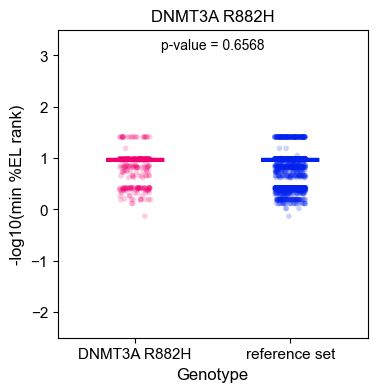

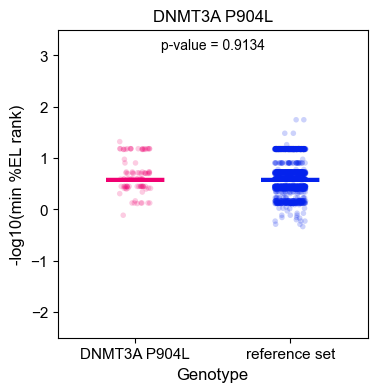

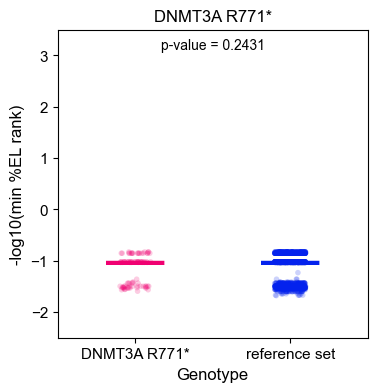

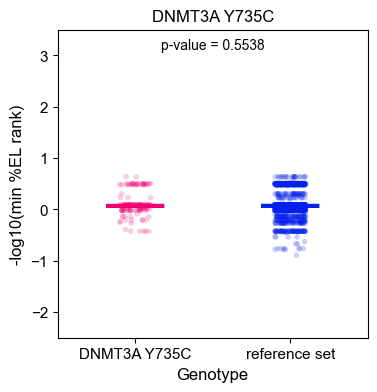

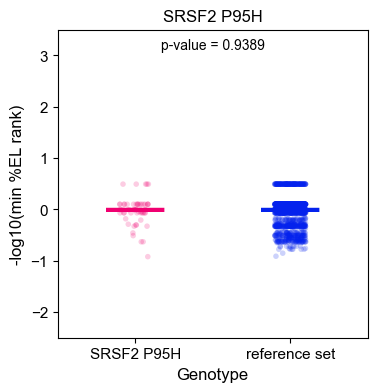

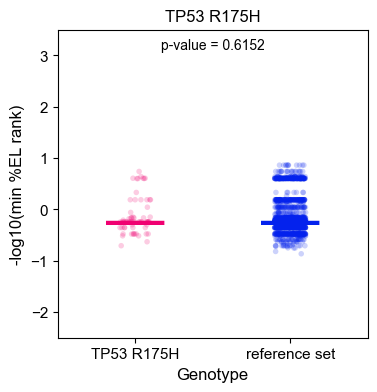

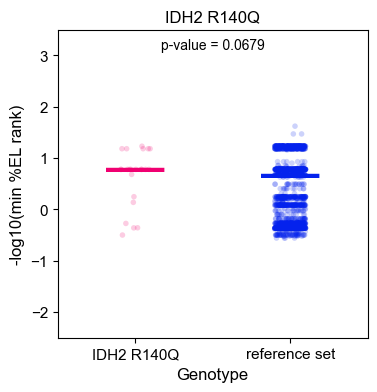

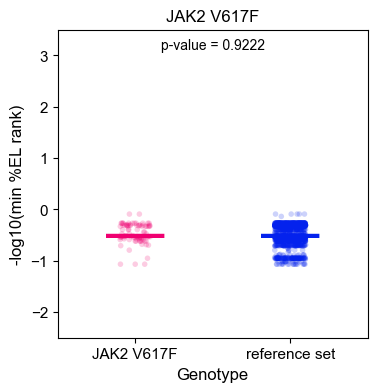

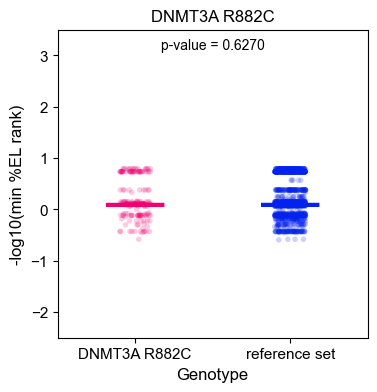

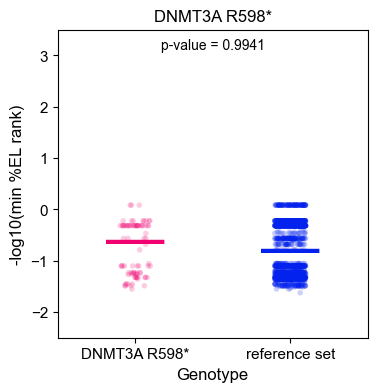

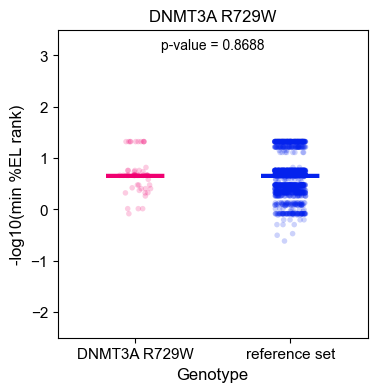

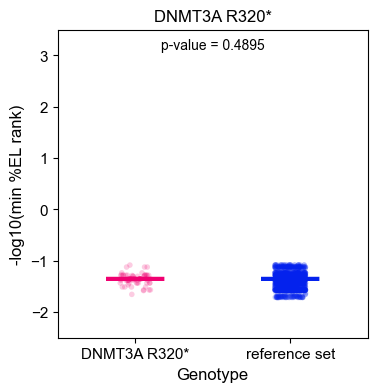

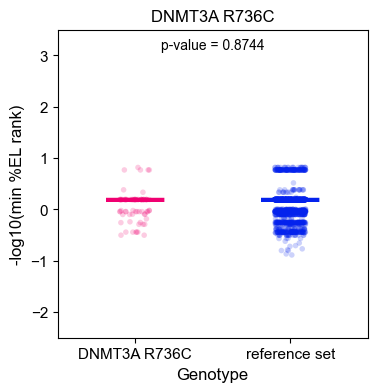

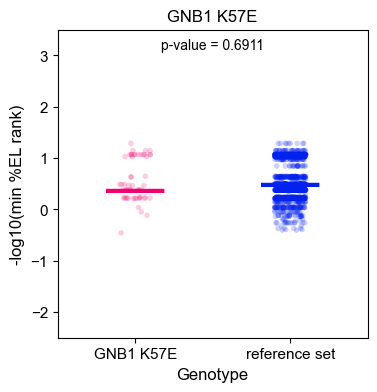

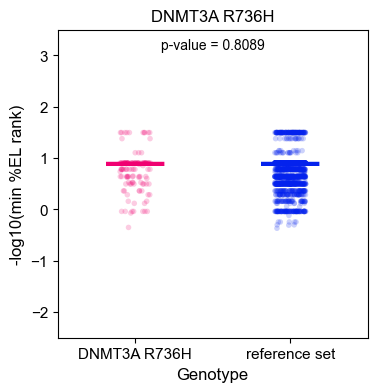

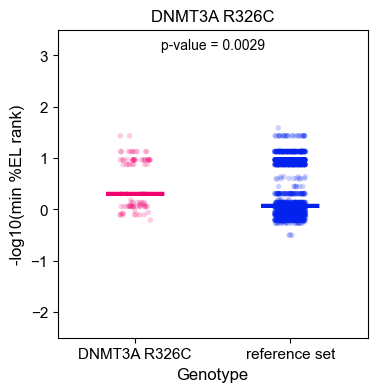

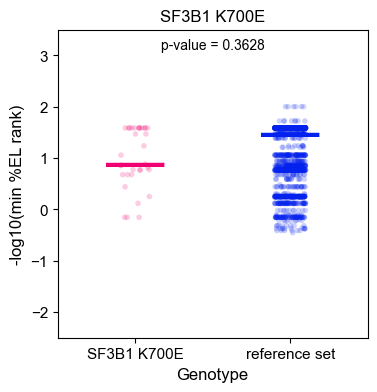

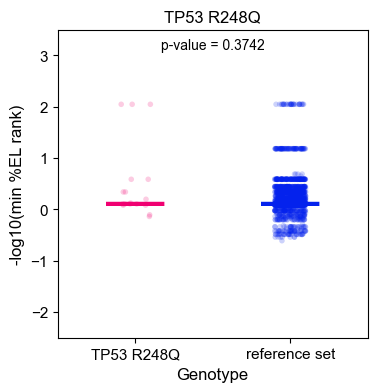

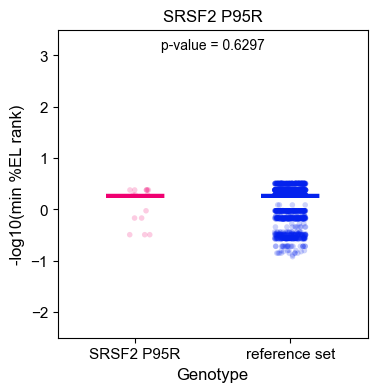

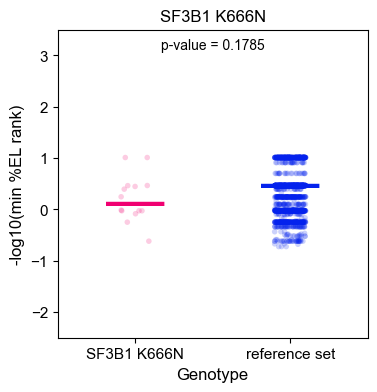

In [310]:

# new way of doing this where you do not sample 5x but you only sample ONE reference from EVERYONE who does not have this variant (CH with different variant or healthy)
# we use 2k for the reference to have a really good idea of how the distribution looks like 
# we also do the plot for all variants together 

# full script to look across variants  

np.random.seed(1) # ensure this is all reproducible 

# specify list of variants to look at 
variants = batch_gene_vars.gene_var.unique()
colors = ['#f00071', '#0422ed']
cols_ch = ['Person_ID', 'gene_var', 'score']

# initialize empty dataframe to store results in 
df_compare_to_ref = pd.DataFrame()

for var in variants:

    var_name = var.replace('_', ' ')
    
    # we will compare to %Rank EL (log) derived from NetMHC now
    ch_scores = ch_all_el_rank_log_labels[ch_all_el_rank_log_labels['gene_var'] == var]
    ch_scores = ch_scores[cols_ch]

    # identify number of variant carriers 
    n =  ch_scores.shape[0]

    if n > 10:

        # find all the dataset that you can sample from
        ids_non_carriers_ch = ch_all_el_rank_log_labels[ch_all_el_rank_log_labels['gene_var'] != var].Person_ID.unique().tolist()
        ids_non_carriers = ids_non_carriers_healthy + ids_non_carriers_ch
        ukbb_not_carrier = df_clean_hla1_hla_sel[df_clean_hla1_hla_sel.Person_ID.isin(ids_non_carriers)]
        ref = ukbb_not_carrier.sample(n=2000, replace=False) # no duplicates
            
        # specify parameter 
        param = '%Rank_EL'

        # add scores 
        ref_scores = pd.concat([ref, ref.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        ref_scores['gene_var'] = 'reference set'
        ref_scores.rename(columns={f'score_{var}_ch': 'score'}, inplace=True)
        ref_scores_var = ref_scores[cols_ch]
        
        # concatenate all dataframes
        scores_compare_all = pd.concat([ch_scores, ref_scores_var], axis=0)
        scores_compare_all["CH_variant_carrier"] = scores_compare_all['gene_var'] == var 
        scores_compare_all["CH_variant_carrier"] = scores_compare_all["CH_variant_carrier"].map({True: 'Carrier', False: 'Non-carrier'})

        # PLOTTING
        # calculate p value 
        scores_ch = scores_compare_all[scores_compare_all["CH_variant_carrier"] == 'Carrier'].score.tolist()
        scores_ref = scores_compare_all[scores_compare_all["CH_variant_carrier"] == 'Non-carrier'].score.tolist()
        H, p_value = mannwhitneyu(scores_ch, scores_ref)

        # format x axis for plotting 
        xaxis_labels = scores_compare_all.gene_var.str.replace('_', ' ')

        # jitterplot 
        plt.figure(figsize=(4,4)) # set figure size
        sns.stripplot(y=f'score', x=xaxis_labels, hue = "CH_variant_carrier", data=scores_compare_all, dodge = False, jitter = True, palette = colors, size = 4, alpha = 0.2, legend = False)
        
        plt.title(f'{var_name}')
        plt.xlabel(f'Genotype', fontsize = 12)
        plt.ylabel(f'-log10(min %EL rank)', fontsize = 12)
        plt.xticks(fontsize = 11)
        plt.yticks(fontsize = 11)
        plt.ylim(-2.5, 3.5)

        # add annotation to indicate median
        median_ch = ch_scores.score.median()
        median_ref = ref_scores_var.score.median()

        plt.text(0, median_ch, '—', ha='center', va='center', fontsize=42, color = '#f00071')
        plt.text(1, median_ref, '—', ha='center', va='center', fontsize=42, color = '#0422ed')

        # plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right')
        # legend = plt.gca().get_legend()
        # for lh in legend.legendHandles:
        #     lh.set_alpha(1)

        # add kruskall wallis test between groups 
        plt.text(0.5, 0.95, f'p-value = {p_value:.4f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize = 10)
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_method_UKBB_{param}_for_{var}_compare_to_ref_set_2k_jitter.pdf', bbox_inches='tight')
        plt.close()
        
        # add rows to dataframe with data for all variants
        df_compare_to_ref = pd.concat([df_compare_to_ref, scores_compare_all], axis = 0)


In [360]:

# okay we need to add a colum with the variant for everyone (because you have reference sets to a variant but the gene_var column does not say which variant this is reference for)
labels = []
current_label = None

# Iterate through the DataFrame
for idx, row in df_compare_to_ref.iterrows():
    # If the category is 'ch', update the current label
    if row['CH_variant_carrier'] == 'Carrier':
        current_label = row['gene_var']
    # Append the current label to the list
    labels.append(current_label)

# Add the labels list as a new column to the DataFrame
df_compare_to_ref['CH variant'] = labels

# add mutation type 
def add_mut_type(string):
    if string[-1] == '*':
        return 'stop codon'
    else:
        return 'substitution'

# Add column based on the last character of strings in the 'var' column
df_compare_to_ref['mutation_type'] = df_compare_to_ref['CH variant'].apply(add_mut_type)

In [370]:

# figure out desired order of variants on the plot 
ch_all_el_rank_log_melted_sort['median_score'] = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
ch_all_el_rank_log_melted_sort_sort = ch_all_el_rank_log_melted_sort.sort_values(by='median_score', ascending = False)
order = ch_all_el_rank_log_melted_sort_sort.gene_var.unique()
variants_examined = df_compare_to_ref['CH variant'].unique().tolist()
order_2 = [var for var in order if var in variants_examined]


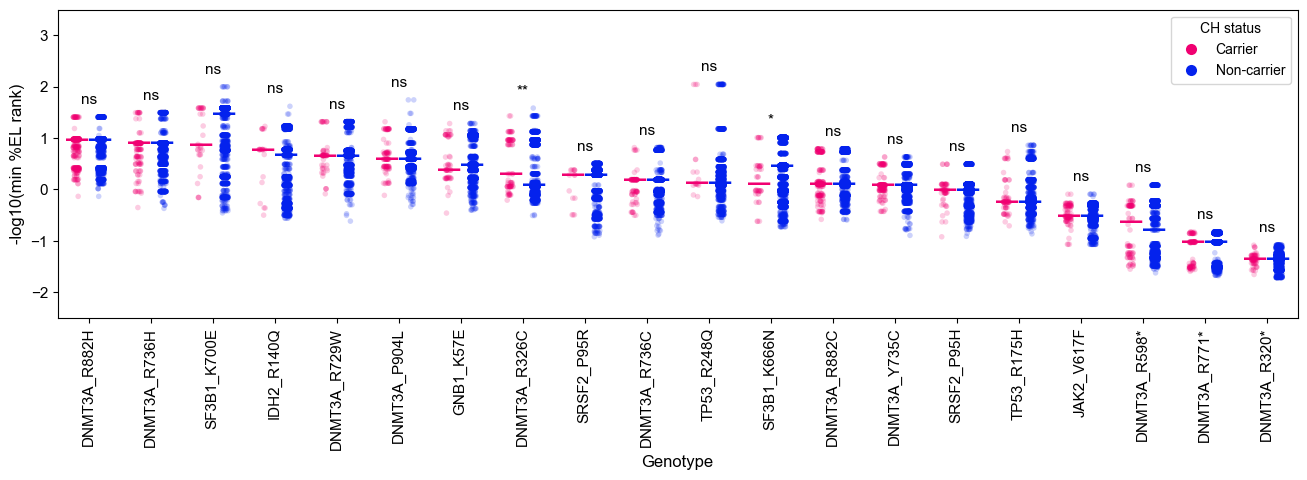

In [373]:

# plot for all variants together 

# jitterplot 
# facet by mutation type 

colors = ['#f00071', '#0422ed']

plt.figure(figsize=(16,4)) # set figure size
sns.stripplot(y=f'score', x='CH variant', hue = 'CH_variant_carrier', data=df_compare_to_ref, dodge = True, jitter = True, palette = colors, size = 4, alpha = 0.2, legend = True, order = order_2)

plt.xlabel(f'Genotype', fontsize = 12)
plt.ylabel(f'-log10(min %EL rank)', fontsize = 12)
plt.xticks(fontsize = 11, rotation = 90)
plt.yticks(fontsize = 11)
plt.ylim(-2.5, 3.5)

# add annotation to indicate median

for i, category in enumerate(order_2):
            
    median_carrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Carrier')].score.median()
    median_noncarrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Non-carrier')].score.median()

    # Plot text for each hue group
    plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#f00071')
    plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=16, fontweight='bold', color = '#0422ed')

# add kruskall wallis test between groups 
for i, category in enumerate(order_2):
    
    category_data = df_compare_to_ref[df_compare_to_ref['CH variant'] == f'{category}']
    max_value = category_data['score'].max()

    scores_carrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Carrier')].score.tolist()
    scores_noncarrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Non-carrier')].score.tolist()

    statistic, p_value = mannwhitneyu(scores_carrier, scores_noncarrier)
    significance = ''
    if p_value > 0.05:
        significance = 'ns'
    elif p_value < 0.01:
        significance = '**'
    else:
        significance = '*'
    plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right')
legend = plt.gca().get_legend()
for lh in legend.legendHandles:
    lh.set_alpha(1)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_method_UKBB_{param}_for_all_compare_to_ref_set_2k_jitter.pdf', bbox_inches='tight')


# MHC genotype > effect on CH risk 

In [72]:


# define a new function just to do it for one variant 
def find_best_score_one_variant_log_ref_ch(row, df, param, variant):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carrie
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":

        # take maximum of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "%Rank_BA":
        
        # take maxium of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "Aff_nM":
        
        # take maxium of the negative log score (low aff = more immunogenic)
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)


In [73]:

# define a function to split people into groups based on MHC presentation score 

def split_equal_groups_by_varscore(df, num_groups, var):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    
    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    return group_assignments


In [88]:

# for everyone in the UKBB, add binding score for each variant based on their MHC genotype
df_clean_hla1_hla_sel_scores = pd.concat([df_clean_hla1_hla_sel, df_clean_hla1_hla_sel.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_wide, param=param, variant = 'DNMT3A_R882H_ch', axis=1)], axis=1)

# order the df by rank
df_clean_hla1_hla_sel_scores['rank'] = df_clean_hla1_hla_sel_scores[f'score_DNMT3A_R882H_ch'].rank(method='first', ascending=False)
df_clean_hla1_hla_sel_scores_sort = df_clean_hla1_hla_sel_scores.sort_values(by = 'rank')


In [76]:

# split people into 3 or 4 groups for each variant (how strongly they bind)
df_clean_hla1_hla_sel_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 2, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_3'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 3, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_4'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 4, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_5'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 5, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_10'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 10, var = 'DNMT3A_R882H')

# okay now we need to add a column to indicate if that person has CH driven by this variant
ids_DNMT3A_R882H = batch_gene_vars[batch_gene_vars['gene_var']=='DNMT3A_R882H'].Person_ID.tolist()
df_clean_hla1_hla_sel_scores_sort['DNMT3A_R882H_positive'] = df_clean_hla1_hla_sel_scores_sort.Person_ID.isin(ids_DNMT3A_R882H) # added True if someone has the variant, False otherwise 

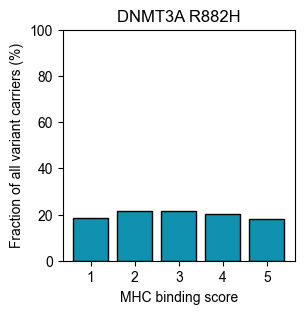

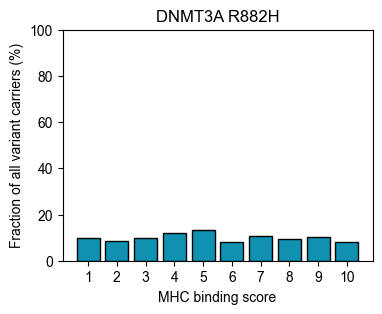

In [87]:

# now, you can calculate how many people with CH (out of all CH positive cases for this variant) are in each group
DNMT3A_R882H_counts5 = df_clean_hla1_hla_sel_scores_sort.groupby('groups_5')['DNMT3A_R882H_positive'].sum().reset_index()
DNMT3A_R882H_counts5['percentage_all_cases'] = DNMT3A_R882H_counts5.DNMT3A_R882H_positive / DNMT3A_R882H_counts5.DNMT3A_R882H_positive.sum() * 100
DNMT3A_R882H_counts5
plt.figure(figsize = (3,3))
plt.bar(DNMT3A_R882H_counts5['groups_5'], DNMT3A_R882H_counts5['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
plt.ylim(0, 100)
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('MHC binding score')
plt.ylabel('Fraction of all variant carriers (%)')
plt.title('DNMT3A R882H')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_DNMT3A_R882H_group5.pdf', bbox_inches='tight')

DNMT3A_R882H_counts10 = df_clean_hla1_hla_sel_scores_sort.groupby('groups_10')['DNMT3A_R882H_positive'].sum().reset_index()
DNMT3A_R882H_counts10['percentage_all_cases'] = DNMT3A_R882H_counts10.DNMT3A_R882H_positive / DNMT3A_R882H_counts10.DNMT3A_R882H_positive.sum() * 100
DNMT3A_R882H_counts10
plt.figure(figsize = (4,3))
plt.bar(DNMT3A_R882H_counts10['groups_10'], DNMT3A_R882H_counts10['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
plt.ylim(0, 100)
plt.xlabel('MHC binding score')
plt.ylabel('Fraction of all variant carriers (%)')
plt.title('DNMT3A R882H')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_DNMT3A_R882H_group10.pdf', bbox_inches='tight')

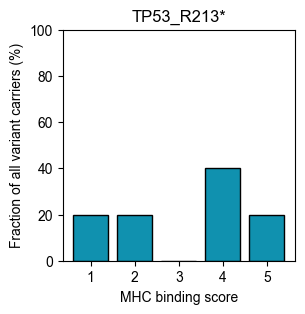

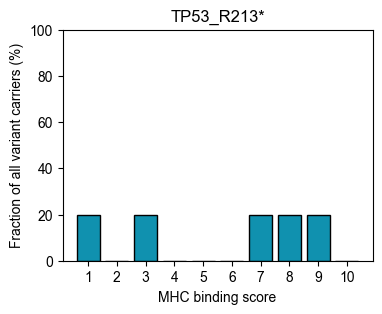

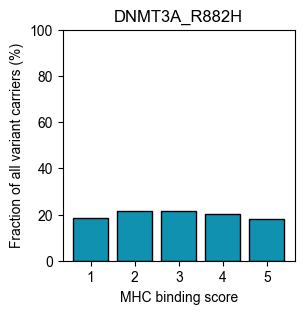

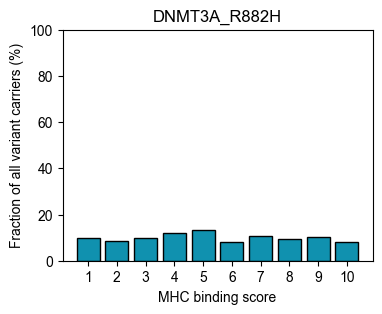

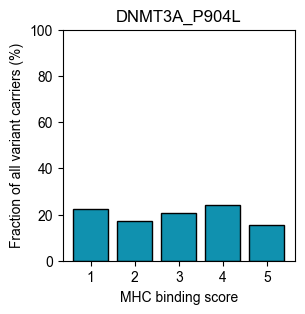

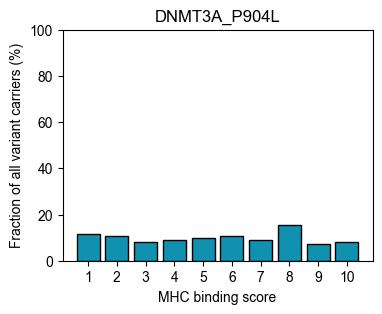

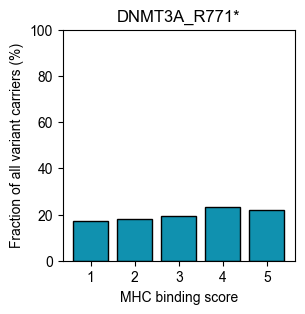

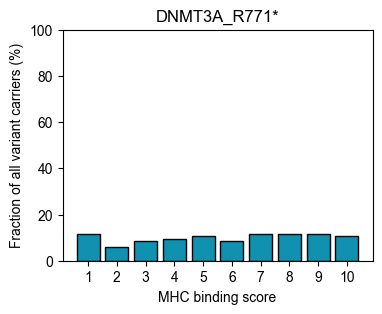

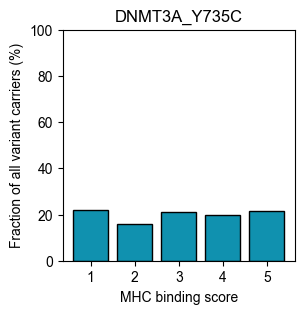

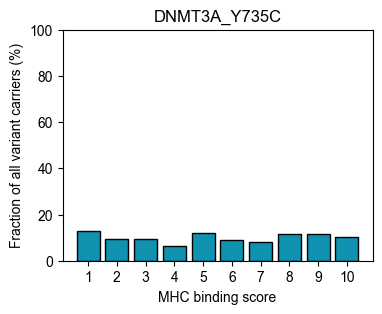

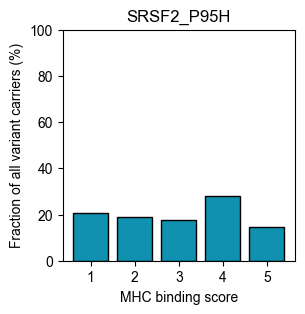

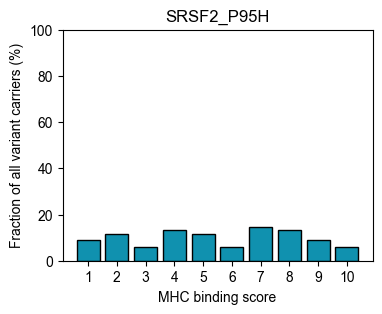

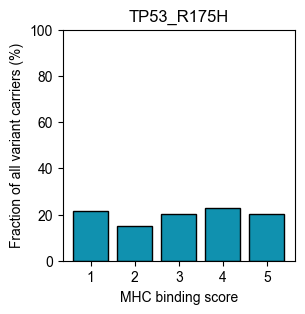

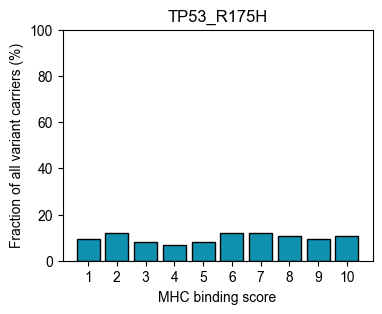

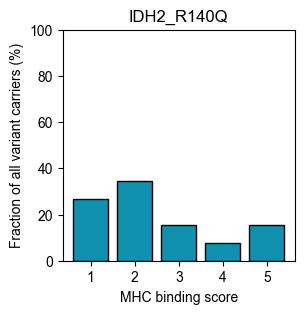

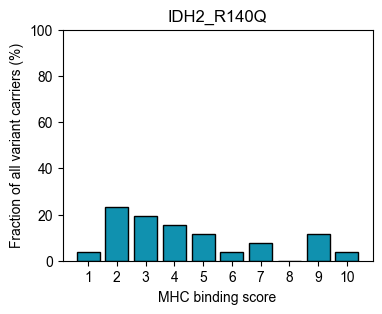

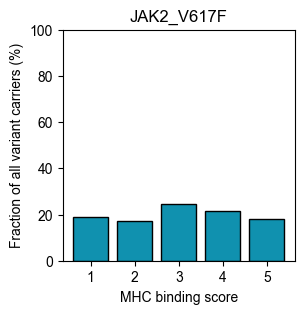

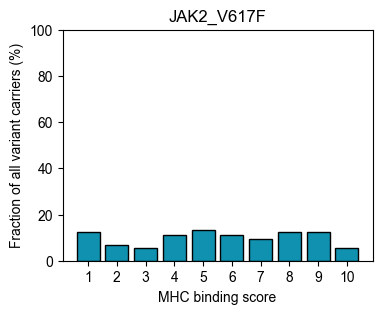

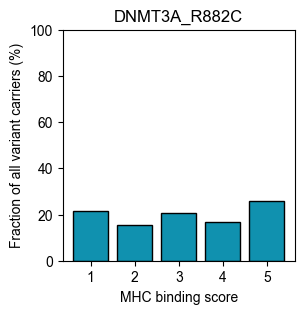

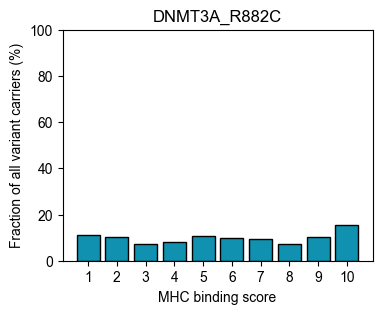

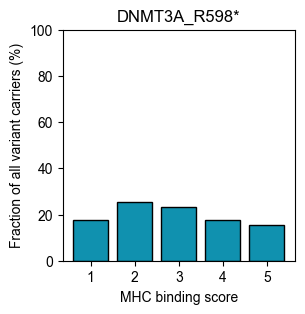

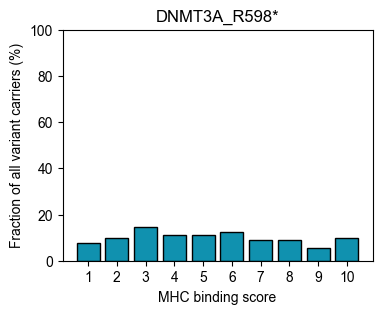

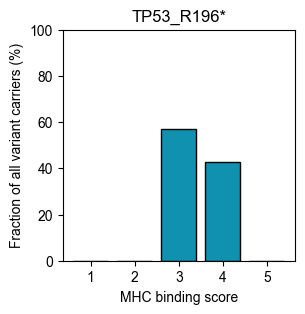

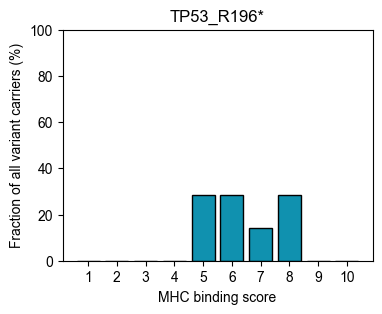

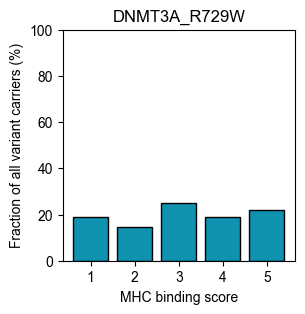

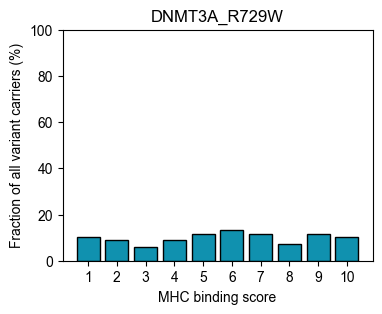

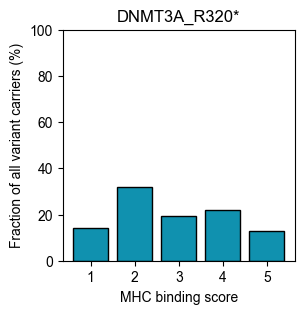

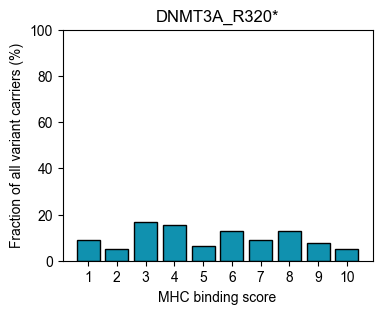

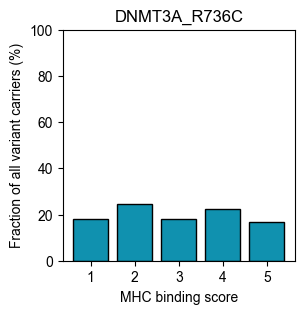

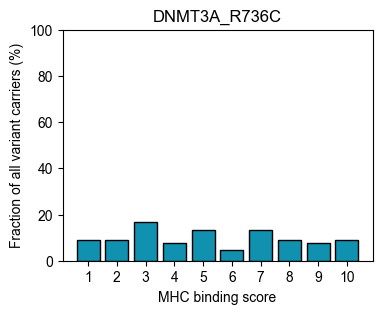

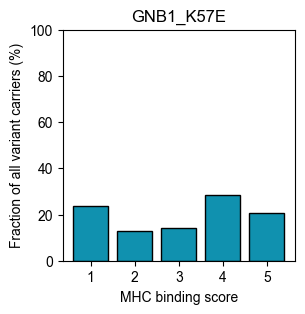

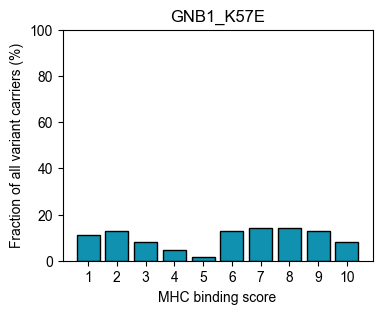

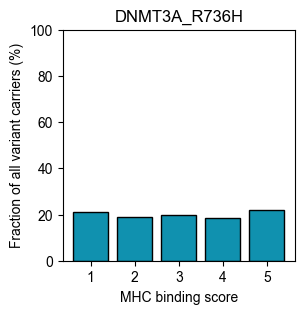

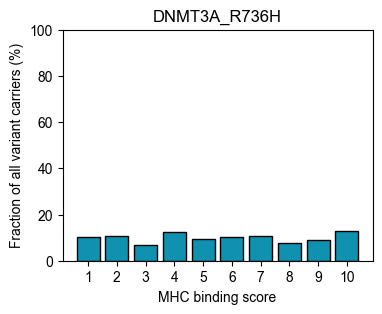

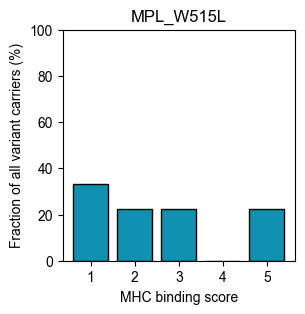

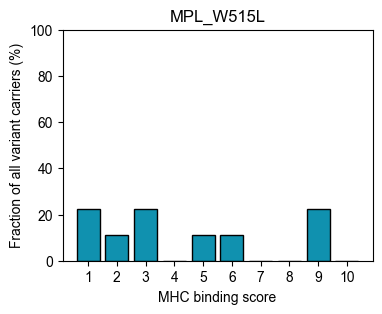

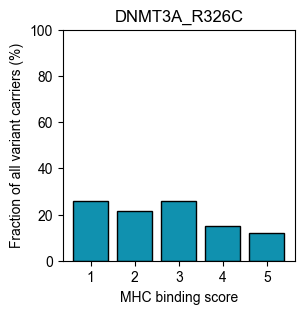

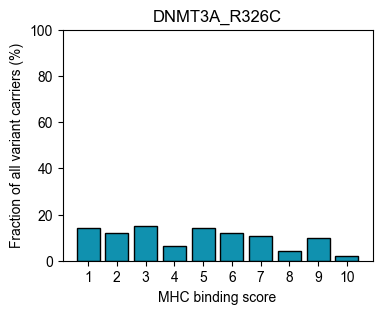

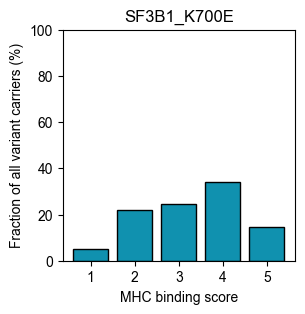

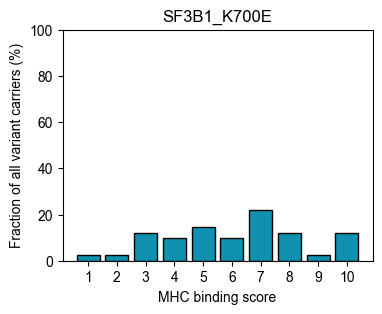

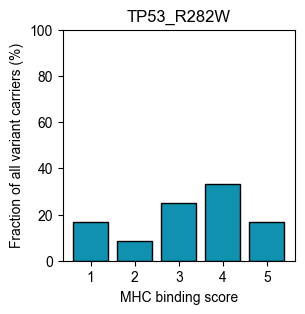

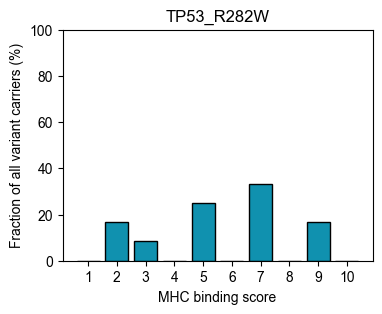

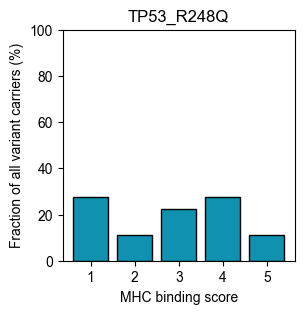

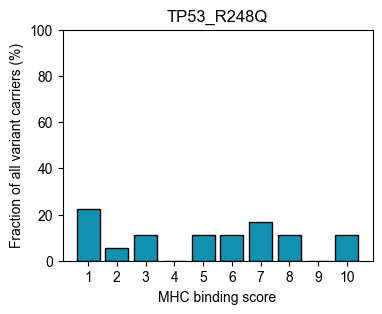

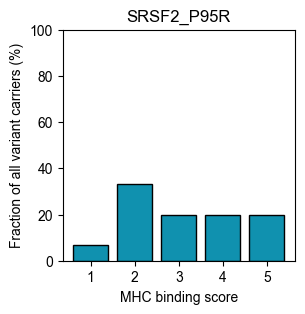

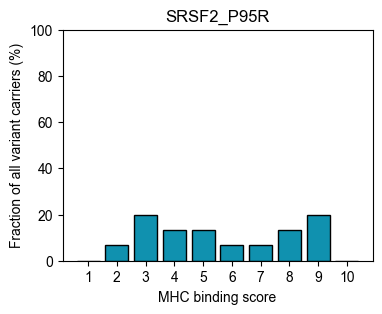

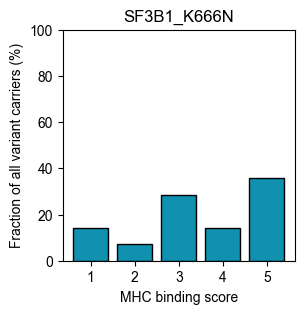

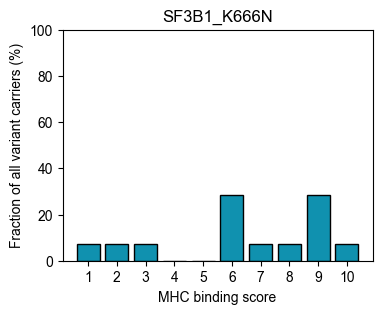

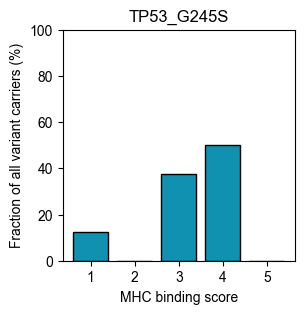

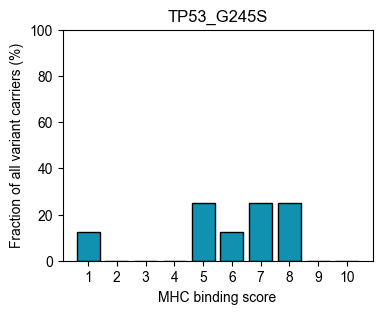

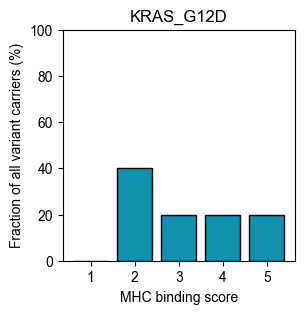

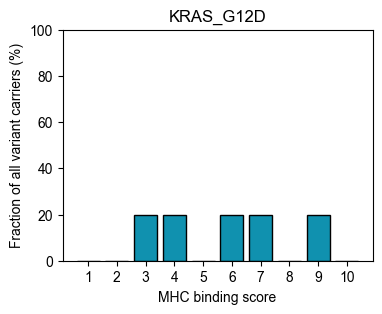

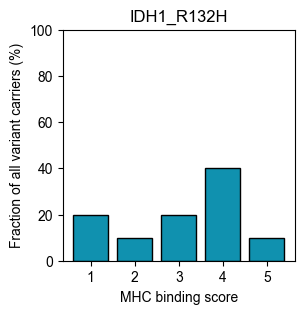

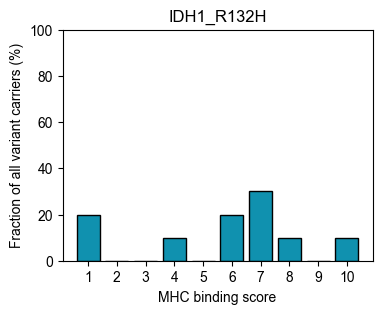

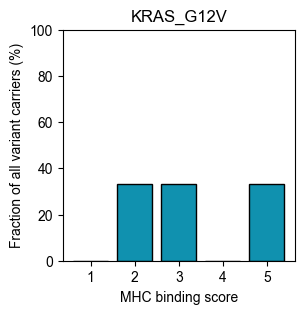

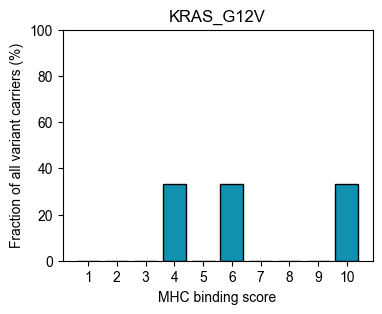

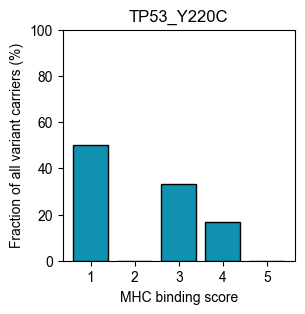

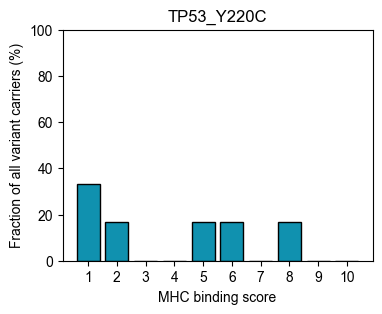

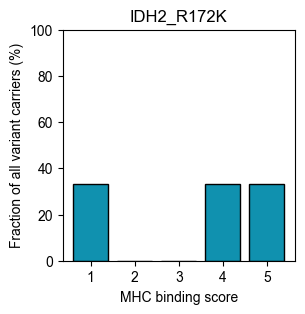

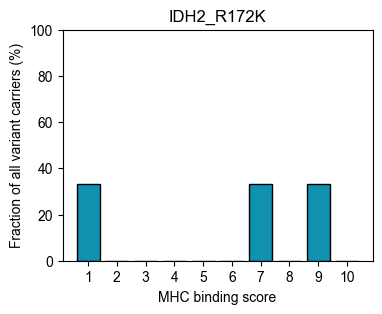

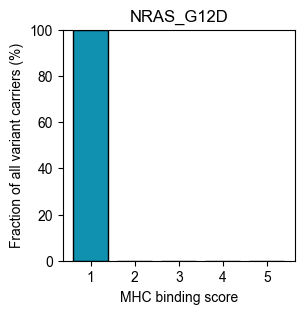

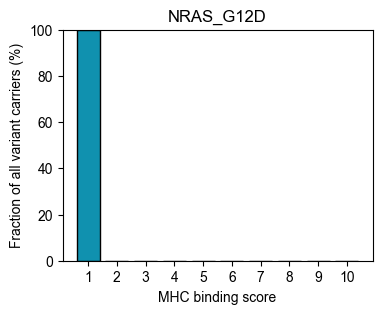

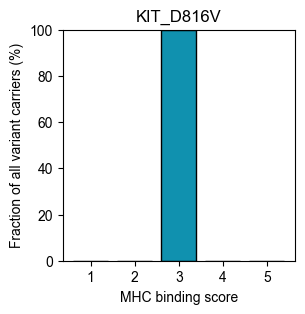

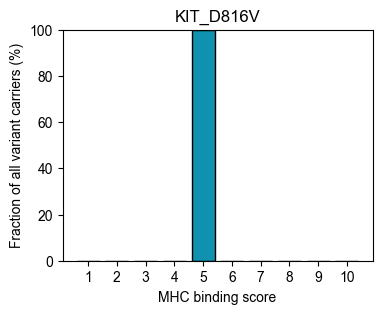

: 

In [94]:
# loop for all variants

variants = batch_gene_vars.gene_var.unique()

for var in variants:
    # for everyone in the UKBB, add binding score for each variant based on their MHC genotype
    df_all_ukbb_scores = pd.concat([df_clean_hla1_hla_sel, df_clean_hla1_hla_sel.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_wide, param=param, variant = f'{var}_ch', axis=1)], axis=1)

    # order the df by rank
    df_all_ukbb_scores['rank'] = df_all_ukbb_scores[f'score_{var}_ch'].rank(method='first', ascending=False)
    df_all_ukbb_scores_sort = df_all_ukbb_scores.sort_values(by = 'rank')

    # split people into 3 or 4 groups for each variant (how strongly they bind)
    df_all_ukbb_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 2, var = var)
    df_all_ukbb_scores_sort['groups_3'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 3, var = var)
    df_all_ukbb_scores_sort['groups_4'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 4, var = var)
    df_all_ukbb_scores_sort['groups_5'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 5, var = var)
    df_all_ukbb_scores_sort['groups_10'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 10, var = var)

    # okay now we need to add a column to indicate if that person has CH driven by this variant
    # identify IDs of people with the variant
    ids_var = batch_gene_vars[batch_gene_vars['gene_var']==var].Person_ID.tolist()
    df_all_ukbb_scores_sort[f'{var}_positive'] = df_all_ukbb_scores_sort.Person_ID.isin(ids_var) # added True if someone has the variant, False otherwise 

    # calculate % of people in each of the 5 or 10 groups (as % of total CH positive cases)
    counts5 = df_all_ukbb_scores_sort.groupby('groups_5')[f'{var}_positive'].sum().reset_index()
    counts5['percentage_all_cases'] = counts5[f'{var}_positive'] / counts5[f'{var}_positive'].sum() * 100
    counts10 = df_all_ukbb_scores_sort.groupby('groups_10')[f'{var}_positive'].sum().reset_index()
    counts10['percentage_all_cases'] = counts10[f'{var}_positive'] / counts10[f'{var}_positive'].sum() * 100
    
    # plotting 
    plt.figure(figsize = (3,3))
    plt.bar(counts5['groups_5'], counts5['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
    plt.ylim(0, 100)
    plt.xticks([1, 2, 3, 4, 5], fontsize = 10)
    plt.xlabel('MHC binding score', fontsize = 11)
    plt.ylabel('Fraction of all variant carriers (%)', fontsize = 11)
    plt.title(f'{var}', fontsize = 12)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_{var}_group5.pdf', bbox_inches='tight')

    plt.figure(figsize = (4,3))
    plt.bar(counts10['groups_10'], counts10['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
    plt.ylim(0, 100)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize = 10)
    plt.xlabel('MHC binding score', fontsize = 11)
    plt.ylabel('Fraction of all variant carriers (%)', fontsize = 11)
    plt.title(f'{var}', fontsize = 12)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_{var}_group10.pdf', bbox_inches='tight')
